In [1]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap                        

from utils.util import find_max_epoch, print_size, training_loss, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm

from imputers.DiffWaveImputer import DiffWaveImputer
from imputers.SSSDSAImputer import SSSDSAImputer
from imputers.SSSDS4Imputer import SSSDS4Imputer


CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json')  
# parser.add_argument('-c', '--config', type=str, default='./config/config_DiffWave-sp500.json') 
                                                                                                                                                                                                                               
args = parser.parse_args(args=[])

with open(args.config) as f:
    data = f.read()

config = json.loads(data)

In [3]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  # dictionary of all diffusion hyperparameters

global model_config

if train_config['use_model'] == 0:
    model_config = config['wavenet_config']
elif train_config['use_model'] == 1:
    model_config = config['sashimi_config']
elif train_config['use_model'] == 2:
    model_config = config['wavenet_config']
       
model_config['num_res_layers']=18           

In [4]:
output_directory = './results/mujoco/90'
ckpt_iter = 'max'
n_iters = 10000
iters_per_ckpt = 100
iters_per_logging = 100
# batch_size_per_gpu              
learning_rate = 0.0002
use_model = 2
only_generate_missing = 1       
masking = 'rm'               
missing_k = 20

In [5]:
local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])

output_directory = os.path.join(output_directory, local_path)
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)
    os.chmod(output_directory, 0o775)               
print("output directory", output_directory, flush=True)

# map diffusion hyperparameters to gpu
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        
        
# predefine model
if use_model == 0:
    net = DiffWaveImputer(**model_config).cuda()
elif use_model == 1:
    net = SSSDSAImputer(**model_config).cuda()
elif use_model == 2:
    net = SSSDS4Imputer(**model_config).cuda()    
else:
    print('Model chosen not available.')
    
print_size(net)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

output directory ./results/mujoco/90\T200_beta00.0001_betaT0.02
SSSDS4Imputer Parameters: 7.547142M


In [6]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)

(5775, 30, 6)


In [7]:
training_data = np.split(training_data, 55, 0)      
print(len(training_data), training_data[0].shape)

training_data = np.array(training_data)
training_data = torch.from_numpy(training_data).float().cuda()
print(training_data.shape)


55 (105, 30, 6)
torch.Size([55, 105, 30, 6])


In [8]:
missing_k = 20                    
iters = 0
loss_list=[]

# while iters < n_iters + 1:

#     for batch in training_data:             
#         transposed_mask = get_mask_rm(batch[0], missing_k)     
#         mask = transposed_mask.permute(1, 0)    
#         mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()  
#         loss_mask = ~mask.bool()        
#         batch = batch.permute(0, 2, 1)   
#         optimizer.zero_grad()
#         X = batch, batch, mask, loss_mask    
#         loss = training_loss(net, nn.MSELoss(), X, diffusion_hyperparams,
#                              only_generate_missing=only_generate_missing)

#         loss.backward()
#         optimizer.step()
           
#         if iters % iters_per_logging == 0:
#                 print("iteration: {} \tloss: {}".format(iters, loss.item()))
                
#         loss_list.append(loss.item())
        
#         iters += 1
  

In [9]:
# torch.save( net.state_dict(),"./sp500_S4_iter_10000.pth" )

In [10]:
'保存和导入模型参数'

net = SSSDS4Imputer(**model_config).cuda()
net.load_state_dict(torch.load( "./sp500_S4_iter_10000.pth"))

# net.eval()

<All keys matched successfully>

In [12]:
def std_normal(size):
    """
    Generate the standard Gaussian variable of a certain size
    """
    return torch.normal(0, 1, size=size).cuda()


size=(5775,6,30)

_dh = diffusion_hyperparams
T, Alpha, Alpha_bar, Sigma = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Sigma"]

assert len(Alpha) == T
assert len(Alpha_bar) == T
assert len(Sigma) == T
assert len(size) == 3

# print(T, Alpha)

x = std_normal(size)      # xT  
cond = 1
mask = 1


In [13]:
with torch.no_grad():      
        for t in range(T - 1, -1, -1):              
            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step             
            epsilon_theta = net((x, cond, mask, diffusion_steps,))  # predict \epsilon according to \epsilon_\theta 
            x = (x - (1 - Alpha[t]) / torch.sqrt(1 - Alpha_bar[t]) * epsilon_theta) / torch.sqrt(Alpha[t])     
            if t > 0:
                x = x + Sigma[t] * std_normal(size)  
                     

In [14]:
result = x.permute(0, 2, 1)

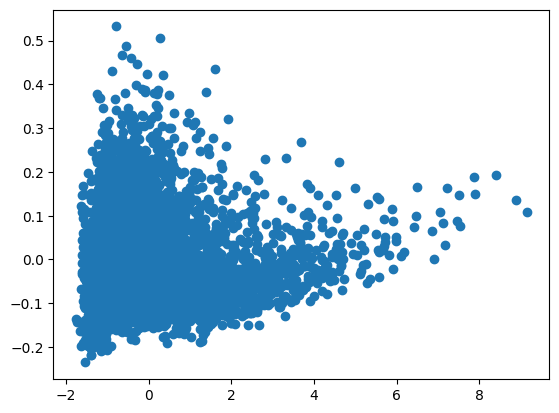

In [15]:
result = result.cpu().numpy().reshape(5775,-1)
# result = result.cpu().numpy().reshape(-1,14)[0:2000]

pca = PCA(2)
pca_res1 = pca.fit_transform(result)

plt.figure()
plt.scatter(pca_res1[:,0],pca_res1[:,1])

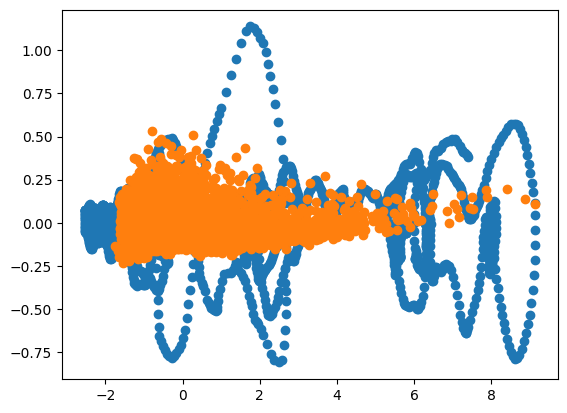

In [16]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
ori_data = training_data.reshape(5775,-1)

pca = PCA(2)
pca_res = pca.fit_transform(ori_data)

plt.figure()
plt.scatter(pca_res[:,0],pca_res[:,1])
plt.scatter(pca_res1[:,0],pca_res1[:,1])

In [17]:
concat_data = np.concatenate((result, ori_data), axis=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    # 固定随机种子random_state=20
tsne_results = tsne.fit_transform(concat_data) 

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.003s...
[t-SNE] Computed neighbors for 11550 samples in 0.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 0.064924
[t-SNE] KL divergenc

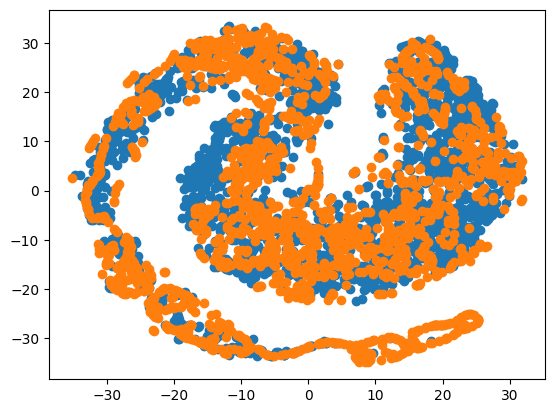

In [18]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[5775:7775,0],tsne_results[5775:7775,1])

C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\PC123\AppData\Local\Temp\ipykernel_13408\135986510.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
C:\Users\PC123\AppData\Local\Temp\ipykernel_13408\135986510.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)


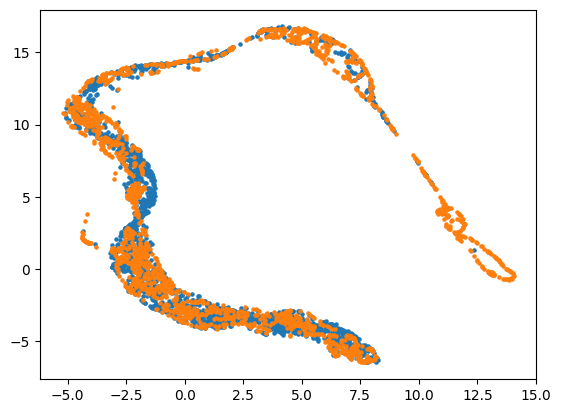

In [19]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(concat_data)

plt.figure()
plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)

In [20]:
ori_data = training_data
generated_data = x.permute(0, 2, 1).cpu().numpy()

anal_sample_no = min([4000, len(ori_data)])      
idx = np.random.permutation(len(ori_data))[:anal_sample_no]

ori_data = np.asarray(ori_data)
generated_data = np.asarray(generated_data)

ori_data = ori_data[idx]
generated_data = generated_data[idx]

for i in range(4000):
    if i == 0:
        prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data = np.concatenate(
            (prep_data, np.reshape(np.mean(ori_data[i, :, :], 1), [1, 30]))
        )


for i in range(4000):
    if i == 0:
        prep_data1 = np.reshape(np.mean(generated_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data1 = np.concatenate(
            (prep_data1, np.reshape(np.mean(generated_data[i, :, :], 1), [1, 30]))
        )
        
x2 = np.concatenate((prep_data, prep_data1), axis=0)

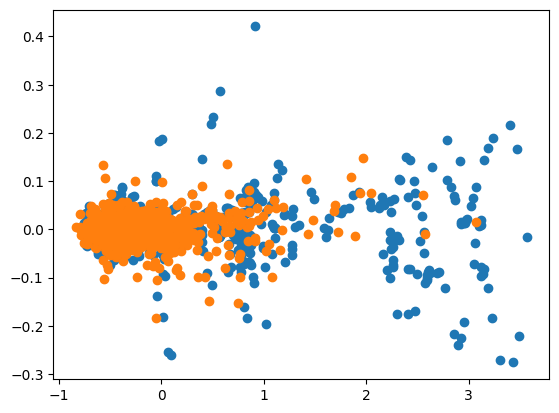

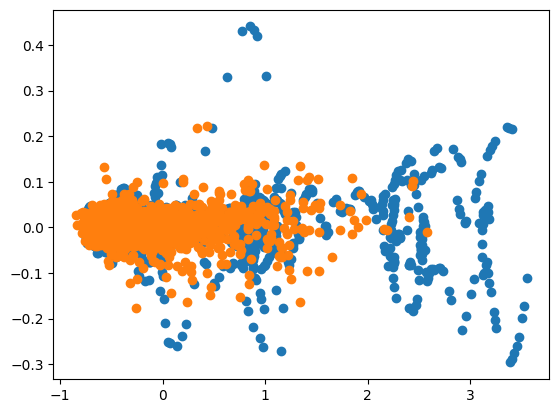

In [21]:
pca = PCA(2)
pca_res = pca.fit_transform(x2)

indexe1=np.random.permutation(4000)[:1000]
indexe2=np.random.permutation( range(4000,8000) )[:1000]

plt.figure()
plt.scatter(pca_res[indexe1,0],pca_res[indexe1,1])
plt.scatter(pca_res[indexe2,0],pca_res[indexe2,1])

plt.figure()
plt.scatter(pca_res[:2000,0],pca_res[:2000,1])
plt.scatter(pca_res[4000:6000,0],pca_res[4000:6000,1])

In [22]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    # 固定随机种子random_state=20
tsne_results = tsne.fit_transform(x2)           # 拼接后一起训练

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.014853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.588799
[t-SNE] KL divergence after 500 iterations: 1.258977


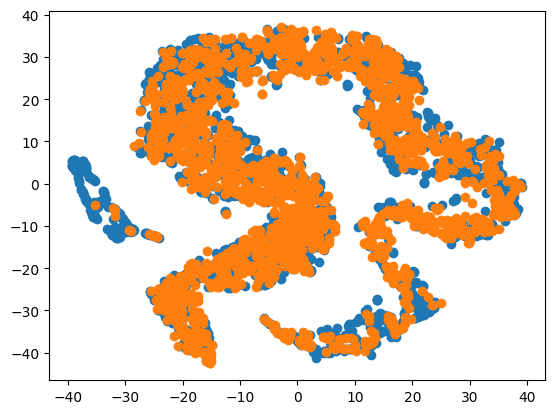

In [23]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[4000:6000,0],tsne_results[4000:6000,1])

In [12]:
'------ae重构实验----------'

import matplotlib.pyplot as plt

'one-shot 单个样本'
training_data = np.load(trainset_config['train_data_path'])
training_data = np.array(training_data)
x = torch.from_numpy(training_data).float().cuda()
x = x[30:31].permute(0,2,1)
print(x.shape)


torch.Size([1, 6, 30])


In [18]:
'获取x0的逆推码xT'
'注意里面噪声模块和下面的公式里有相同的参数x 就是同一个结果在不停迭代改变'
'注意torch.ones后的参数和样本数一致'
'注意ddim和 ddpm采样时 t可以不用取端点 因为公式里有t-1  用ddim inversion也一样 不用取端点 因为有t+1'

inverted_x = x

with torch.no_grad():        
    for t in range(0, T-1, 1):                       # 0到198 不取最后一步 因为有t+1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((inverted_x, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        inverted_x = ( torch.sqrt(Alpha_bar[t+1]) * (inverted_x - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                                     torch.sqrt(1-Alpha_bar[t+1])* epsilon_theta
  

In [19]:
print(inverted_x.shape)
criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(x, inverted_x))
print(RMSE)


torch.Size([1, 6, 30])
tensor(0.5631, device='cuda:0')


In [20]:
'从逆推码xT通过ddim恢复原x0'

recove = inverted_x

with torch.no_grad():        
    for t in range(T-1, 0, -1):                       #  199到1  因为有t-1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((recove, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        recove = ( torch.sqrt(Alpha_bar[t-1]) * (recove - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                              torch.sqrt(1-Alpha_bar[t-1])* epsilon_theta

In [25]:
print(x.shape)
print(recove.shape)

criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(x, recove))
print(RMSE)

torch.Size([1, 6, 30])
torch.Size([1, 6, 30])
tensor(0.0026, device='cuda:0')


(1, 30, 6)
(30,)


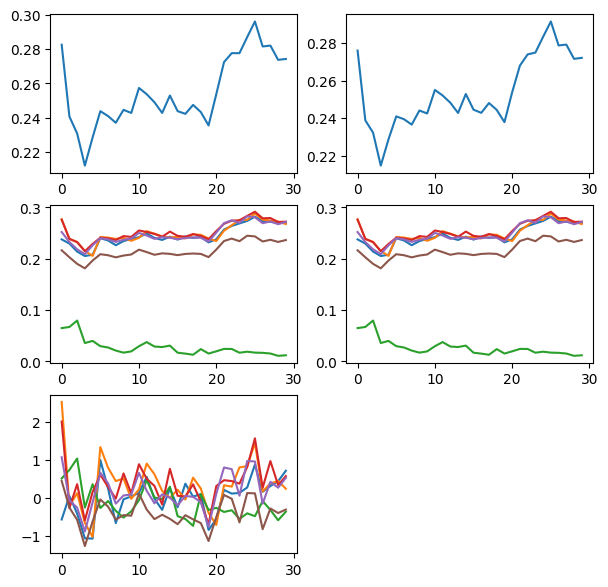

In [26]:
x_plot = x.permute(0, 2, 1).cpu().numpy()
print(x_plot.shape)
print(x_plot[0][:,1].shape)

recove_plot = recove.permute(0, 2, 1).cpu().numpy()

inverted_plot = inverted_x.permute(0, 2, 1).cpu().numpy()


fig = plt.figure(figsize=(7,7))

plt.subplot(3,2,1)
plt.plot(x_plot[0][:,3])       # 第二列属性

plt.subplot(3,2,2)
plt.plot(recove_plot[0][:,3])      


plt.subplot(3,2,3)
plt.plot(recove_plot[0][:,:])  

plt.subplot(3,2,4)
plt.plot(recove_plot[0][:,:]) 


plt.subplot(3,2,5)
plt.plot(inverted_plot[0][:,:]) 

In [9]:
'-----样本进行缺失后brits补全-----'
'这个样本照理来说不应该在原数据集里'
from torch.autograd import Variable
from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import MRNN,BRITS,SAITS
from pypots.utils.metrics import cal_mse,cal_rmse,cal_mae
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
'----使用原数据集-----'

training_data = np.load(trainset_config['train_data_path'])
training_data = np.array(training_data)
x = torch.from_numpy(training_data).float().cuda()
# x = x[30:31].permute(0,2,1)      # saits训练不用换维度
x = x[30:31]
print(x.shape)
print(x[0][0])


np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

'对数据进行缺失 '
'X_ori是原数据  X_missed是缺失后的数据 '
'missing_mask是缺失掩码 0为缺失 1为保留    indicating_mask和missing_mask相反 显示哪些位置缺失 缺失了显示1 '
X_ori, X_missed, missing_mask, indicating_mask = mcar(x, 0.3, np.nan)   # 可以用0或np.nan来填补缺失位置
print(X_ori[0][0])
print(X_missed[0][0])
print(missing_mask[0][0])
print(indicating_mask[0][0])

In [12]:
'使用其他数据集  上下两个数据用一个即可 zero-shot补全'

oneshot_data = np.loadtxt('AAL.csv',delimiter = ",")
norm_data = MinMaxScaler().fit_transform(oneshot_data)
x_oneshot = np.array(norm_data[10:40])
x_oneshot = torch.from_numpy(x_oneshot).float().cuda()
x_oneshot = x_oneshot.unsqueeze(dim=0)
print(x_oneshot.shape)

X_ori, X_missed, missing_mask, indicating_mask = mcar(x_oneshot, 0.3, np.nan)
print(X_ori[0][0])

torch.Size([1, 30, 6])
tensor([0.3361, 0.3359, 0.0015, 0.3310, 0.3304, 0.3304], device='cuda:0')


In [13]:
'用saits进行初步补全'

import gc
gc.collect()
torch.cuda.empty_cache()


rmse_list =[]
imputation_list = []

for i in range(1):             # 运行5次计算标准差
    
   
    saits = SAITS(n_steps=30, n_features=6, n_layers=2, d_model=128, d_inner=64, n_heads=4, d_k=64, d_v=64, dropout=0.1, batch_size=10, epochs=3000)
    
#     saits = BRITS(n_steps=30, n_features=6, rnn_hidden_size=64, batch_size=1, epochs=50)
#     saits = MRNN(n_steps=30, n_features=6, rnn_hidden_size=64, batch_size=1, epochs=100)
    
    dataset = {"X": X_missed}
    
    saits.fit(dataset)               # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
    imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
    imputation_list.append(imputation)
    
    imputation = torch.from_numpy(imputation).cuda()

    mae = cal_mae(imputation, X_ori, indicating_mask)    # 计算缺失位置的损失
    mse = cal_mse(imputation, X_ori, indicating_mask)
    rmse = cal_rmse(imputation, X_ori, indicating_mask)
    print(mae,mse, rmse)
    
    rmse_list.append(rmse)
    
'''
 np.random.seed(5)
 
 mr 0.3                                            mr 05                                         mr 0.7                                     

epoch     mae        mse        rmse               epoch     mae        mse        rmse              mae        mse        rmse      
2000      0.0069   8.6589e-05   0.0093(0.0090)                                                       0.0133      0.0003    0.0175
3000      0.0075   0.0001       0.0084 (0.0082)                                                               0.0123      0.0003    0.0160
5000      0.0053   5.6983e-05   0.0075(0.0074)                                                       0.00885     0.000152  0.01233
7000      0.0057   7.5455e-05   0.0087                                                               0.0104      0.0002    0.0138
10000     0.0066   7.9513e-05    0.0089                                                              0.0149      0.0006    0.0248

'''

2024-11-25 18:06:15 [INFO]: No given device, using default device: cuda
2024-11-25 18:06:15 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 18:06:15 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 18:06:16 [INFO]: epoch 0: training loss 0.6360
2024-11-25 18:06:16 [INFO]: epoch 1: training loss 0.5773
2024-11-25 18:06:16 [INFO]: epoch 2: training loss 0.6984
2024-11-25 18:06:16 [INFO]: epoch 3: training loss 0.5839
2024-11-25 18:06:16 [INFO]: epoch 4: training loss 0.5237
2024-11-25 18:06:16 [INFO]: epoch 5: training loss 0.4360
2024-11-25 18:06:16 [INFO]: epoch 6: training loss 0.4538
2024-11-25 18:06:16 [INFO]: epoch 7: training loss 0.4306
2024-11-25 18:06:16 [INFO]: epoch 8: training loss 0.4051
2024-11-25 18:06:16 [INFO]: epoch 9: training loss 0.4046
2024-11-25 18:06:16 [INFO]: epoch 10: training loss 0.3213
2024-11-25 18:06:16 [INFO]: epoch 11: training loss 0.3356
2024-11-25 18:06:16

2024-11-25 18:06:17 [INFO]: epoch 134: training loss 0.0760
2024-11-25 18:06:17 [INFO]: epoch 135: training loss 0.0846
2024-11-25 18:06:17 [INFO]: epoch 136: training loss 0.0827
2024-11-25 18:06:17 [INFO]: epoch 137: training loss 0.0944
2024-11-25 18:06:17 [INFO]: epoch 138: training loss 0.0810
2024-11-25 18:06:17 [INFO]: epoch 139: training loss 0.0792
2024-11-25 18:06:17 [INFO]: epoch 140: training loss 0.0904
2024-11-25 18:06:17 [INFO]: epoch 141: training loss 0.0775
2024-11-25 18:06:17 [INFO]: epoch 142: training loss 0.0806
2024-11-25 18:06:17 [INFO]: epoch 143: training loss 0.0815
2024-11-25 18:06:17 [INFO]: epoch 144: training loss 0.0842
2024-11-25 18:06:18 [INFO]: epoch 145: training loss 0.0854
2024-11-25 18:06:18 [INFO]: epoch 146: training loss 0.0897
2024-11-25 18:06:18 [INFO]: epoch 147: training loss 0.0757
2024-11-25 18:06:18 [INFO]: epoch 148: training loss 0.0803
2024-11-25 18:06:18 [INFO]: epoch 149: training loss 0.1010
2024-11-25 18:06:18 [INFO]: epoch 150: t

2024-11-25 18:06:19 [INFO]: epoch 271: training loss 0.0686
2024-11-25 18:06:19 [INFO]: epoch 272: training loss 0.0644
2024-11-25 18:06:19 [INFO]: epoch 273: training loss 0.0651
2024-11-25 18:06:19 [INFO]: epoch 274: training loss 0.0638
2024-11-25 18:06:19 [INFO]: epoch 275: training loss 0.0580
2024-11-25 18:06:19 [INFO]: epoch 276: training loss 0.0578
2024-11-25 18:06:19 [INFO]: epoch 277: training loss 0.0559
2024-11-25 18:06:19 [INFO]: epoch 278: training loss 0.0546
2024-11-25 18:06:19 [INFO]: epoch 279: training loss 0.0560
2024-11-25 18:06:19 [INFO]: epoch 280: training loss 0.0577
2024-11-25 18:06:19 [INFO]: epoch 281: training loss 0.0592
2024-11-25 18:06:19 [INFO]: epoch 282: training loss 0.0529
2024-11-25 18:06:19 [INFO]: epoch 283: training loss 0.0580
2024-11-25 18:06:19 [INFO]: epoch 284: training loss 0.0546
2024-11-25 18:06:19 [INFO]: epoch 285: training loss 0.0523
2024-11-25 18:06:19 [INFO]: epoch 286: training loss 0.0544
2024-11-25 18:06:19 [INFO]: epoch 287: t

2024-11-25 18:06:21 [INFO]: epoch 408: training loss 0.0496
2024-11-25 18:06:21 [INFO]: epoch 409: training loss 0.0506
2024-11-25 18:06:21 [INFO]: epoch 410: training loss 0.0403
2024-11-25 18:06:21 [INFO]: epoch 411: training loss 0.0424
2024-11-25 18:06:21 [INFO]: epoch 412: training loss 0.0499
2024-11-25 18:06:21 [INFO]: epoch 413: training loss 0.0440
2024-11-25 18:06:21 [INFO]: epoch 414: training loss 0.0495
2024-11-25 18:06:21 [INFO]: epoch 415: training loss 0.0447
2024-11-25 18:06:21 [INFO]: epoch 416: training loss 0.0438
2024-11-25 18:06:21 [INFO]: epoch 417: training loss 0.0417
2024-11-25 18:06:21 [INFO]: epoch 418: training loss 0.0426
2024-11-25 18:06:21 [INFO]: epoch 419: training loss 0.0420
2024-11-25 18:06:21 [INFO]: epoch 420: training loss 0.0417
2024-11-25 18:06:21 [INFO]: epoch 421: training loss 0.0505
2024-11-25 18:06:21 [INFO]: epoch 422: training loss 0.0404
2024-11-25 18:06:21 [INFO]: epoch 423: training loss 0.0410
2024-11-25 18:06:21 [INFO]: epoch 424: t

2024-11-25 18:06:23 [INFO]: epoch 545: training loss 0.0386
2024-11-25 18:06:23 [INFO]: epoch 546: training loss 0.0379
2024-11-25 18:06:23 [INFO]: epoch 547: training loss 0.0314
2024-11-25 18:06:23 [INFO]: epoch 548: training loss 0.0407
2024-11-25 18:06:23 [INFO]: epoch 549: training loss 0.0415
2024-11-25 18:06:23 [INFO]: epoch 550: training loss 0.0366
2024-11-25 18:06:23 [INFO]: epoch 551: training loss 0.0350
2024-11-25 18:06:23 [INFO]: epoch 552: training loss 0.0436
2024-11-25 18:06:23 [INFO]: epoch 553: training loss 0.0430
2024-11-25 18:06:23 [INFO]: epoch 554: training loss 0.0398
2024-11-25 18:06:23 [INFO]: epoch 555: training loss 0.0409
2024-11-25 18:06:23 [INFO]: epoch 556: training loss 0.0373
2024-11-25 18:06:23 [INFO]: epoch 557: training loss 0.0382
2024-11-25 18:06:23 [INFO]: epoch 558: training loss 0.0319
2024-11-25 18:06:23 [INFO]: epoch 559: training loss 0.0392
2024-11-25 18:06:23 [INFO]: epoch 560: training loss 0.0333
2024-11-25 18:06:23 [INFO]: epoch 561: t

2024-11-25 18:06:25 [INFO]: epoch 682: training loss 0.0329
2024-11-25 18:06:25 [INFO]: epoch 683: training loss 0.0331
2024-11-25 18:06:25 [INFO]: epoch 684: training loss 0.0297
2024-11-25 18:06:25 [INFO]: epoch 685: training loss 0.0304
2024-11-25 18:06:25 [INFO]: epoch 686: training loss 0.0298
2024-11-25 18:06:25 [INFO]: epoch 687: training loss 0.0302
2024-11-25 18:06:25 [INFO]: epoch 688: training loss 0.0338
2024-11-25 18:06:25 [INFO]: epoch 689: training loss 0.0313
2024-11-25 18:06:25 [INFO]: epoch 690: training loss 0.0314
2024-11-25 18:06:25 [INFO]: epoch 691: training loss 0.0349
2024-11-25 18:06:25 [INFO]: epoch 692: training loss 0.0306
2024-11-25 18:06:25 [INFO]: epoch 693: training loss 0.0318
2024-11-25 18:06:25 [INFO]: epoch 694: training loss 0.0309
2024-11-25 18:06:25 [INFO]: epoch 695: training loss 0.0292
2024-11-25 18:06:25 [INFO]: epoch 696: training loss 0.0309
2024-11-25 18:06:25 [INFO]: epoch 697: training loss 0.0305
2024-11-25 18:06:25 [INFO]: epoch 698: t

2024-11-25 18:06:26 [INFO]: epoch 819: training loss 0.0234
2024-11-25 18:06:26 [INFO]: epoch 820: training loss 0.0283
2024-11-25 18:06:26 [INFO]: epoch 821: training loss 0.0230
2024-11-25 18:06:26 [INFO]: epoch 822: training loss 0.0293
2024-11-25 18:06:26 [INFO]: epoch 823: training loss 0.0278
2024-11-25 18:06:26 [INFO]: epoch 824: training loss 0.0301
2024-11-25 18:06:26 [INFO]: epoch 825: training loss 0.0246
2024-11-25 18:06:26 [INFO]: epoch 826: training loss 0.0337
2024-11-25 18:06:26 [INFO]: epoch 827: training loss 0.0308
2024-11-25 18:06:26 [INFO]: epoch 828: training loss 0.0258
2024-11-25 18:06:27 [INFO]: epoch 829: training loss 0.0305
2024-11-25 18:06:27 [INFO]: epoch 830: training loss 0.0257
2024-11-25 18:06:27 [INFO]: epoch 831: training loss 0.0316
2024-11-25 18:06:27 [INFO]: epoch 832: training loss 0.0267
2024-11-25 18:06:27 [INFO]: epoch 833: training loss 0.0249
2024-11-25 18:06:27 [INFO]: epoch 834: training loss 0.0262
2024-11-25 18:06:27 [INFO]: epoch 835: t

2024-11-25 18:06:28 [INFO]: epoch 956: training loss 0.0251
2024-11-25 18:06:28 [INFO]: epoch 957: training loss 0.0226
2024-11-25 18:06:28 [INFO]: epoch 958: training loss 0.0240
2024-11-25 18:06:28 [INFO]: epoch 959: training loss 0.0214
2024-11-25 18:06:28 [INFO]: epoch 960: training loss 0.0240
2024-11-25 18:06:28 [INFO]: epoch 961: training loss 0.0273
2024-11-25 18:06:28 [INFO]: epoch 962: training loss 0.0257
2024-11-25 18:06:28 [INFO]: epoch 963: training loss 0.0260
2024-11-25 18:06:28 [INFO]: epoch 964: training loss 0.0242
2024-11-25 18:06:28 [INFO]: epoch 965: training loss 0.0247
2024-11-25 18:06:28 [INFO]: epoch 966: training loss 0.0269
2024-11-25 18:06:28 [INFO]: epoch 967: training loss 0.0270
2024-11-25 18:06:28 [INFO]: epoch 968: training loss 0.0250
2024-11-25 18:06:28 [INFO]: epoch 969: training loss 0.0282
2024-11-25 18:06:28 [INFO]: epoch 970: training loss 0.0289
2024-11-25 18:06:28 [INFO]: epoch 971: training loss 0.0261
2024-11-25 18:06:28 [INFO]: epoch 972: t

tensor(0.0149, device='cuda:0') tensor(0.0004, device='cuda:0') tensor(0.0194, device='cuda:0')


2024-11-25 18:06:29 [INFO]: epoch 13: training loss 0.3218
2024-11-25 18:06:29 [INFO]: epoch 14: training loss 0.3404
2024-11-25 18:06:29 [INFO]: epoch 15: training loss 0.3460
2024-11-25 18:06:29 [INFO]: epoch 16: training loss 0.3399
2024-11-25 18:06:29 [INFO]: epoch 17: training loss 0.3185
2024-11-25 18:06:29 [INFO]: epoch 18: training loss 0.3049
2024-11-25 18:06:29 [INFO]: epoch 19: training loss 0.2956
2024-11-25 18:06:29 [INFO]: epoch 20: training loss 0.3155
2024-11-25 18:06:29 [INFO]: epoch 21: training loss 0.3234
2024-11-25 18:06:29 [INFO]: epoch 22: training loss 0.2981
2024-11-25 18:06:29 [INFO]: epoch 23: training loss 0.3226
2024-11-25 18:06:29 [INFO]: epoch 24: training loss 0.3278
2024-11-25 18:06:29 [INFO]: epoch 25: training loss 0.3053
2024-11-25 18:06:29 [INFO]: epoch 26: training loss 0.3203
2024-11-25 18:06:29 [INFO]: epoch 27: training loss 0.2929
2024-11-25 18:06:29 [INFO]: epoch 28: training loss 0.2550
2024-11-25 18:06:29 [INFO]: epoch 29: training loss 0.27

2024-11-25 18:06:31 [INFO]: epoch 151: training loss 0.1064
2024-11-25 18:06:31 [INFO]: epoch 152: training loss 0.1015
2024-11-25 18:06:31 [INFO]: epoch 153: training loss 0.1076
2024-11-25 18:06:31 [INFO]: epoch 154: training loss 0.0926
2024-11-25 18:06:31 [INFO]: epoch 155: training loss 0.0897
2024-11-25 18:06:31 [INFO]: epoch 156: training loss 0.1098
2024-11-25 18:06:31 [INFO]: epoch 157: training loss 0.0939
2024-11-25 18:06:31 [INFO]: epoch 158: training loss 0.0987
2024-11-25 18:06:31 [INFO]: epoch 159: training loss 0.0919
2024-11-25 18:06:31 [INFO]: epoch 160: training loss 0.0937
2024-11-25 18:06:31 [INFO]: epoch 161: training loss 0.0881
2024-11-25 18:06:31 [INFO]: epoch 162: training loss 0.1109
2024-11-25 18:06:31 [INFO]: epoch 163: training loss 0.1003
2024-11-25 18:06:31 [INFO]: epoch 164: training loss 0.0913
2024-11-25 18:06:31 [INFO]: epoch 165: training loss 0.1079
2024-11-25 18:06:31 [INFO]: epoch 166: training loss 0.1030
2024-11-25 18:06:31 [INFO]: epoch 167: t

2024-11-25 18:06:33 [INFO]: epoch 288: training loss 0.0696
2024-11-25 18:06:33 [INFO]: epoch 289: training loss 0.0685
2024-11-25 18:06:33 [INFO]: epoch 290: training loss 0.0646
2024-11-25 18:06:33 [INFO]: epoch 291: training loss 0.0638
2024-11-25 18:06:33 [INFO]: epoch 292: training loss 0.0665
2024-11-25 18:06:33 [INFO]: epoch 293: training loss 0.0757
2024-11-25 18:06:33 [INFO]: epoch 294: training loss 0.0737
2024-11-25 18:06:33 [INFO]: epoch 295: training loss 0.0665
2024-11-25 18:06:33 [INFO]: epoch 296: training loss 0.0651
2024-11-25 18:06:33 [INFO]: epoch 297: training loss 0.0604
2024-11-25 18:06:33 [INFO]: epoch 298: training loss 0.0688
2024-11-25 18:06:33 [INFO]: epoch 299: training loss 0.0648
2024-11-25 18:06:33 [INFO]: epoch 300: training loss 0.0699
2024-11-25 18:06:33 [INFO]: epoch 301: training loss 0.0637
2024-11-25 18:06:33 [INFO]: epoch 302: training loss 0.0609
2024-11-25 18:06:33 [INFO]: epoch 303: training loss 0.0646
2024-11-25 18:06:33 [INFO]: epoch 304: t

2024-11-25 18:06:34 [INFO]: epoch 425: training loss 0.0591
2024-11-25 18:06:34 [INFO]: epoch 426: training loss 0.0597
2024-11-25 18:06:34 [INFO]: epoch 427: training loss 0.0527
2024-11-25 18:06:34 [INFO]: epoch 428: training loss 0.0613
2024-11-25 18:06:34 [INFO]: epoch 429: training loss 0.0601
2024-11-25 18:06:34 [INFO]: epoch 430: training loss 0.0500
2024-11-25 18:06:34 [INFO]: epoch 431: training loss 0.0629
2024-11-25 18:06:35 [INFO]: epoch 432: training loss 0.0523
2024-11-25 18:06:35 [INFO]: epoch 433: training loss 0.0709
2024-11-25 18:06:35 [INFO]: epoch 434: training loss 0.0673
2024-11-25 18:06:35 [INFO]: epoch 435: training loss 0.0495
2024-11-25 18:06:35 [INFO]: epoch 436: training loss 0.0689
2024-11-25 18:06:35 [INFO]: epoch 437: training loss 0.0683
2024-11-25 18:06:35 [INFO]: epoch 438: training loss 0.0540
2024-11-25 18:06:35 [INFO]: epoch 439: training loss 0.0508
2024-11-25 18:06:35 [INFO]: epoch 440: training loss 0.0556
2024-11-25 18:06:35 [INFO]: epoch 441: t

2024-11-25 18:06:36 [INFO]: epoch 562: training loss 0.0418
2024-11-25 18:06:36 [INFO]: epoch 563: training loss 0.0490
2024-11-25 18:06:36 [INFO]: epoch 564: training loss 0.0460
2024-11-25 18:06:36 [INFO]: epoch 565: training loss 0.0499
2024-11-25 18:06:36 [INFO]: epoch 566: training loss 0.0453
2024-11-25 18:06:36 [INFO]: epoch 567: training loss 0.0509
2024-11-25 18:06:36 [INFO]: epoch 568: training loss 0.0577
2024-11-25 18:06:36 [INFO]: epoch 569: training loss 0.0448
2024-11-25 18:06:36 [INFO]: epoch 570: training loss 0.0457
2024-11-25 18:06:36 [INFO]: epoch 571: training loss 0.0449
2024-11-25 18:06:36 [INFO]: epoch 572: training loss 0.0455
2024-11-25 18:06:36 [INFO]: epoch 573: training loss 0.0474
2024-11-25 18:06:36 [INFO]: epoch 574: training loss 0.0485
2024-11-25 18:06:36 [INFO]: epoch 575: training loss 0.0485
2024-11-25 18:06:36 [INFO]: epoch 576: training loss 0.0431
2024-11-25 18:06:36 [INFO]: epoch 577: training loss 0.0438
2024-11-25 18:06:36 [INFO]: epoch 578: t

2024-11-25 18:06:38 [INFO]: epoch 699: training loss 0.0558
2024-11-25 18:06:38 [INFO]: epoch 700: training loss 0.0476
2024-11-25 18:06:38 [INFO]: epoch 701: training loss 0.0464
2024-11-25 18:06:38 [INFO]: epoch 702: training loss 0.0637
2024-11-25 18:06:38 [INFO]: epoch 703: training loss 0.0518
2024-11-25 18:06:38 [INFO]: epoch 704: training loss 0.0402
2024-11-25 18:06:38 [INFO]: epoch 705: training loss 0.0383
2024-11-25 18:06:38 [INFO]: epoch 706: training loss 0.0546
2024-11-25 18:06:38 [INFO]: epoch 707: training loss 0.0565
2024-11-25 18:06:38 [INFO]: epoch 708: training loss 0.0511
2024-11-25 18:06:38 [INFO]: epoch 709: training loss 0.0435
2024-11-25 18:06:38 [INFO]: epoch 710: training loss 0.0431
2024-11-25 18:06:38 [INFO]: epoch 711: training loss 0.0440
2024-11-25 18:06:38 [INFO]: epoch 712: training loss 0.0416
2024-11-25 18:06:38 [INFO]: epoch 713: training loss 0.0414
2024-11-25 18:06:38 [INFO]: epoch 714: training loss 0.0405
2024-11-25 18:06:38 [INFO]: epoch 715: t

2024-11-25 18:06:40 [INFO]: epoch 836: training loss 0.0373
2024-11-25 18:06:40 [INFO]: epoch 837: training loss 0.0357
2024-11-25 18:06:40 [INFO]: epoch 838: training loss 0.0388
2024-11-25 18:06:40 [INFO]: epoch 839: training loss 0.0387
2024-11-25 18:06:40 [INFO]: epoch 840: training loss 0.0383
2024-11-25 18:06:40 [INFO]: epoch 841: training loss 0.0386
2024-11-25 18:06:40 [INFO]: epoch 842: training loss 0.0388
2024-11-25 18:06:40 [INFO]: epoch 843: training loss 0.0411
2024-11-25 18:06:40 [INFO]: epoch 844: training loss 0.0374
2024-11-25 18:06:40 [INFO]: epoch 845: training loss 0.0354
2024-11-25 18:06:40 [INFO]: epoch 846: training loss 0.0345
2024-11-25 18:06:40 [INFO]: epoch 847: training loss 0.0379
2024-11-25 18:06:40 [INFO]: epoch 848: training loss 0.0362
2024-11-25 18:06:40 [INFO]: epoch 849: training loss 0.0329
2024-11-25 18:06:40 [INFO]: epoch 850: training loss 0.0376
2024-11-25 18:06:40 [INFO]: epoch 851: training loss 0.0344
2024-11-25 18:06:40 [INFO]: epoch 852: t

2024-11-25 18:06:42 [INFO]: epoch 973: training loss 0.0315
2024-11-25 18:06:42 [INFO]: epoch 974: training loss 0.0341
2024-11-25 18:06:42 [INFO]: epoch 975: training loss 0.0327
2024-11-25 18:06:42 [INFO]: epoch 976: training loss 0.0327
2024-11-25 18:06:42 [INFO]: epoch 977: training loss 0.0309
2024-11-25 18:06:42 [INFO]: epoch 978: training loss 0.0341
2024-11-25 18:06:42 [INFO]: epoch 979: training loss 0.0384
2024-11-25 18:06:42 [INFO]: epoch 980: training loss 0.0337
2024-11-25 18:06:42 [INFO]: epoch 981: training loss 0.0335
2024-11-25 18:06:42 [INFO]: epoch 982: training loss 0.0370
2024-11-25 18:06:42 [INFO]: epoch 983: training loss 0.0340
2024-11-25 18:06:42 [INFO]: epoch 984: training loss 0.0351
2024-11-25 18:06:42 [INFO]: epoch 985: training loss 0.0378
2024-11-25 18:06:42 [INFO]: epoch 986: training loss 0.0364
2024-11-25 18:06:42 [INFO]: epoch 987: training loss 0.0396
2024-11-25 18:06:42 [INFO]: epoch 988: training loss 0.0361
2024-11-25 18:06:42 [INFO]: epoch 989: t

tensor(0.0175, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0219, device='cuda:0')


2024-11-25 18:06:42 [INFO]: epoch 13: training loss 0.3364
2024-11-25 18:06:42 [INFO]: epoch 14: training loss 0.3742
2024-11-25 18:06:42 [INFO]: epoch 15: training loss 0.3741
2024-11-25 18:06:42 [INFO]: epoch 16: training loss 0.3420
2024-11-25 18:06:42 [INFO]: epoch 17: training loss 0.3313
2024-11-25 18:06:42 [INFO]: epoch 18: training loss 0.3513
2024-11-25 18:06:42 [INFO]: epoch 19: training loss 0.4111
2024-11-25 18:06:42 [INFO]: epoch 20: training loss 0.3515
2024-11-25 18:06:42 [INFO]: epoch 21: training loss 0.3422
2024-11-25 18:06:42 [INFO]: epoch 22: training loss 0.3455
2024-11-25 18:06:42 [INFO]: epoch 23: training loss 0.3957
2024-11-25 18:06:42 [INFO]: epoch 24: training loss 0.3622
2024-11-25 18:06:42 [INFO]: epoch 25: training loss 0.3274
2024-11-25 18:06:42 [INFO]: epoch 26: training loss 0.3324
2024-11-25 18:06:42 [INFO]: epoch 27: training loss 0.3528
2024-11-25 18:06:42 [INFO]: epoch 28: training loss 0.3667
2024-11-25 18:06:42 [INFO]: epoch 29: training loss 0.35

2024-11-25 18:06:44 [INFO]: epoch 151: training loss 0.2102
2024-11-25 18:06:44 [INFO]: epoch 152: training loss 0.1977
2024-11-25 18:06:44 [INFO]: epoch 153: training loss 0.1907
2024-11-25 18:06:44 [INFO]: epoch 154: training loss 0.1883
2024-11-25 18:06:44 [INFO]: epoch 155: training loss 0.1842
2024-11-25 18:06:44 [INFO]: epoch 156: training loss 0.1966
2024-11-25 18:06:44 [INFO]: epoch 157: training loss 0.2012
2024-11-25 18:06:44 [INFO]: epoch 158: training loss 0.1956
2024-11-25 18:06:44 [INFO]: epoch 159: training loss 0.1948
2024-11-25 18:06:44 [INFO]: epoch 160: training loss 0.1910
2024-11-25 18:06:44 [INFO]: epoch 161: training loss 0.1802
2024-11-25 18:06:44 [INFO]: epoch 162: training loss 0.1768
2024-11-25 18:06:44 [INFO]: epoch 163: training loss 0.1955
2024-11-25 18:06:44 [INFO]: epoch 164: training loss 0.1769
2024-11-25 18:06:44 [INFO]: epoch 165: training loss 0.1818
2024-11-25 18:06:44 [INFO]: epoch 166: training loss 0.1898
2024-11-25 18:06:44 [INFO]: epoch 167: t

2024-11-25 18:06:46 [INFO]: epoch 288: training loss 0.1480
2024-11-25 18:06:46 [INFO]: epoch 289: training loss 0.1331
2024-11-25 18:06:46 [INFO]: epoch 290: training loss 0.1367
2024-11-25 18:06:46 [INFO]: epoch 291: training loss 0.1450
2024-11-25 18:06:46 [INFO]: epoch 292: training loss 0.1620
2024-11-25 18:06:46 [INFO]: epoch 293: training loss 0.1518
2024-11-25 18:06:46 [INFO]: epoch 294: training loss 0.1428
2024-11-25 18:06:46 [INFO]: epoch 295: training loss 0.1405
2024-11-25 18:06:46 [INFO]: epoch 296: training loss 0.1493
2024-11-25 18:06:46 [INFO]: epoch 297: training loss 0.1545
2024-11-25 18:06:46 [INFO]: epoch 298: training loss 0.1547
2024-11-25 18:06:46 [INFO]: epoch 299: training loss 0.1513
2024-11-25 18:06:46 [INFO]: epoch 300: training loss 0.1454
2024-11-25 18:06:46 [INFO]: epoch 301: training loss 0.1370
2024-11-25 18:06:46 [INFO]: epoch 302: training loss 0.1379
2024-11-25 18:06:46 [INFO]: epoch 303: training loss 0.1370
2024-11-25 18:06:46 [INFO]: epoch 304: t

2024-11-25 18:06:48 [INFO]: epoch 425: training loss 0.1235
2024-11-25 18:06:48 [INFO]: epoch 426: training loss 0.1031
2024-11-25 18:06:48 [INFO]: epoch 427: training loss 0.1161
2024-11-25 18:06:48 [INFO]: epoch 428: training loss 0.1153
2024-11-25 18:06:48 [INFO]: epoch 429: training loss 0.1098
2024-11-25 18:06:48 [INFO]: epoch 430: training loss 0.1171
2024-11-25 18:06:48 [INFO]: epoch 431: training loss 0.1134
2024-11-25 18:06:48 [INFO]: epoch 432: training loss 0.1108
2024-11-25 18:06:48 [INFO]: epoch 433: training loss 0.1092
2024-11-25 18:06:48 [INFO]: epoch 434: training loss 0.1125
2024-11-25 18:06:48 [INFO]: epoch 435: training loss 0.1008
2024-11-25 18:06:48 [INFO]: epoch 436: training loss 0.1086
2024-11-25 18:06:48 [INFO]: epoch 437: training loss 0.1035
2024-11-25 18:06:48 [INFO]: epoch 438: training loss 0.1062
2024-11-25 18:06:48 [INFO]: epoch 439: training loss 0.1095
2024-11-25 18:06:48 [INFO]: epoch 440: training loss 0.1076
2024-11-25 18:06:48 [INFO]: epoch 441: t

2024-11-25 18:06:50 [INFO]: epoch 562: training loss 0.0826
2024-11-25 18:06:50 [INFO]: epoch 563: training loss 0.0892
2024-11-25 18:06:50 [INFO]: epoch 564: training loss 0.0911
2024-11-25 18:06:50 [INFO]: epoch 565: training loss 0.0936
2024-11-25 18:06:50 [INFO]: epoch 566: training loss 0.0838
2024-11-25 18:06:50 [INFO]: epoch 567: training loss 0.0914
2024-11-25 18:06:50 [INFO]: epoch 568: training loss 0.0845
2024-11-25 18:06:50 [INFO]: epoch 569: training loss 0.0852
2024-11-25 18:06:50 [INFO]: epoch 570: training loss 0.0831
2024-11-25 18:06:50 [INFO]: epoch 571: training loss 0.0865
2024-11-25 18:06:50 [INFO]: epoch 572: training loss 0.0919
2024-11-25 18:06:50 [INFO]: epoch 573: training loss 0.0844
2024-11-25 18:06:50 [INFO]: epoch 574: training loss 0.0929
2024-11-25 18:06:50 [INFO]: epoch 575: training loss 0.0913
2024-11-25 18:06:50 [INFO]: epoch 576: training loss 0.0846
2024-11-25 18:06:50 [INFO]: epoch 577: training loss 0.0826
2024-11-25 18:06:50 [INFO]: epoch 578: t

2024-11-25 18:06:51 [INFO]: epoch 699: training loss 0.0620
2024-11-25 18:06:51 [INFO]: epoch 700: training loss 0.0653
2024-11-25 18:06:51 [INFO]: epoch 701: training loss 0.0613
2024-11-25 18:06:51 [INFO]: epoch 702: training loss 0.0682
2024-11-25 18:06:51 [INFO]: epoch 703: training loss 0.0714
2024-11-25 18:06:51 [INFO]: epoch 704: training loss 0.0718
2024-11-25 18:06:51 [INFO]: epoch 705: training loss 0.0702
2024-11-25 18:06:51 [INFO]: epoch 706: training loss 0.0726
2024-11-25 18:06:51 [INFO]: epoch 707: training loss 0.0714
2024-11-25 18:06:51 [INFO]: epoch 708: training loss 0.0711
2024-11-25 18:06:51 [INFO]: epoch 709: training loss 0.0692
2024-11-25 18:06:51 [INFO]: epoch 710: training loss 0.0647
2024-11-25 18:06:51 [INFO]: epoch 711: training loss 0.0683
2024-11-25 18:06:51 [INFO]: epoch 712: training loss 0.0764
2024-11-25 18:06:52 [INFO]: epoch 713: training loss 0.0674
2024-11-25 18:06:52 [INFO]: epoch 714: training loss 0.0668
2024-11-25 18:06:52 [INFO]: epoch 715: t

2024-11-25 18:06:53 [INFO]: epoch 836: training loss 0.0519
2024-11-25 18:06:53 [INFO]: epoch 837: training loss 0.0566
2024-11-25 18:06:53 [INFO]: epoch 838: training loss 0.0532
2024-11-25 18:06:53 [INFO]: epoch 839: training loss 0.0574
2024-11-25 18:06:53 [INFO]: epoch 840: training loss 0.0538
2024-11-25 18:06:53 [INFO]: epoch 841: training loss 0.0495
2024-11-25 18:06:53 [INFO]: epoch 842: training loss 0.0524
2024-11-25 18:06:53 [INFO]: epoch 843: training loss 0.0539
2024-11-25 18:06:53 [INFO]: epoch 844: training loss 0.0597
2024-11-25 18:06:53 [INFO]: epoch 845: training loss 0.0522
2024-11-25 18:06:53 [INFO]: epoch 846: training loss 0.0531
2024-11-25 18:06:53 [INFO]: epoch 847: training loss 0.0525
2024-11-25 18:06:53 [INFO]: epoch 848: training loss 0.0570
2024-11-25 18:06:53 [INFO]: epoch 849: training loss 0.0515
2024-11-25 18:06:53 [INFO]: epoch 850: training loss 0.0583
2024-11-25 18:06:53 [INFO]: epoch 851: training loss 0.0525
2024-11-25 18:06:53 [INFO]: epoch 852: t

2024-11-25 18:06:55 [INFO]: epoch 973: training loss 0.0468
2024-11-25 18:06:55 [INFO]: epoch 974: training loss 0.0487
2024-11-25 18:06:55 [INFO]: epoch 975: training loss 0.0430
2024-11-25 18:06:55 [INFO]: epoch 976: training loss 0.0433
2024-11-25 18:06:55 [INFO]: epoch 977: training loss 0.0461
2024-11-25 18:06:55 [INFO]: epoch 978: training loss 0.0485
2024-11-25 18:06:55 [INFO]: epoch 979: training loss 0.0477
2024-11-25 18:06:55 [INFO]: epoch 980: training loss 0.0433
2024-11-25 18:06:55 [INFO]: epoch 981: training loss 0.0461
2024-11-25 18:06:55 [INFO]: epoch 982: training loss 0.0459
2024-11-25 18:06:55 [INFO]: epoch 983: training loss 0.0443
2024-11-25 18:06:55 [INFO]: epoch 984: training loss 0.0405
2024-11-25 18:06:55 [INFO]: epoch 985: training loss 0.0474
2024-11-25 18:06:55 [INFO]: epoch 986: training loss 0.0433
2024-11-25 18:06:55 [INFO]: epoch 987: training loss 0.0449
2024-11-25 18:06:55 [INFO]: epoch 988: training loss 0.0450
2024-11-25 18:06:55 [INFO]: epoch 989: t

tensor(0.0165, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0228, device='cuda:0')


2024-11-25 18:06:56 [INFO]: epoch 13: training loss 0.4687
2024-11-25 18:06:56 [INFO]: epoch 14: training loss 0.3874
2024-11-25 18:06:56 [INFO]: epoch 15: training loss 0.3919
2024-11-25 18:06:56 [INFO]: epoch 16: training loss 0.3956
2024-11-25 18:06:56 [INFO]: epoch 17: training loss 0.3558
2024-11-25 18:06:56 [INFO]: epoch 18: training loss 0.3614
2024-11-25 18:06:56 [INFO]: epoch 19: training loss 0.3573
2024-11-25 18:06:56 [INFO]: epoch 20: training loss 0.3220
2024-11-25 18:06:56 [INFO]: epoch 21: training loss 0.4186
2024-11-25 18:06:56 [INFO]: epoch 22: training loss 0.3832
2024-11-25 18:06:56 [INFO]: epoch 23: training loss 0.3277
2024-11-25 18:06:56 [INFO]: epoch 24: training loss 0.3354
2024-11-25 18:06:56 [INFO]: epoch 25: training loss 0.3393
2024-11-25 18:06:56 [INFO]: epoch 26: training loss 0.3246
2024-11-25 18:06:56 [INFO]: epoch 27: training loss 0.3239
2024-11-25 18:06:56 [INFO]: epoch 28: training loss 0.3786
2024-11-25 18:06:56 [INFO]: epoch 29: training loss 0.31

2024-11-25 18:06:57 [INFO]: epoch 151: training loss 0.1285
2024-11-25 18:06:57 [INFO]: epoch 152: training loss 0.1352
2024-11-25 18:06:57 [INFO]: epoch 153: training loss 0.1138
2024-11-25 18:06:57 [INFO]: epoch 154: training loss 0.1365
2024-11-25 18:06:57 [INFO]: epoch 155: training loss 0.1215
2024-11-25 18:06:57 [INFO]: epoch 156: training loss 0.1301
2024-11-25 18:06:57 [INFO]: epoch 157: training loss 0.1211
2024-11-25 18:06:57 [INFO]: epoch 158: training loss 0.1269
2024-11-25 18:06:57 [INFO]: epoch 159: training loss 0.1277
2024-11-25 18:06:57 [INFO]: epoch 160: training loss 0.1339
2024-11-25 18:06:57 [INFO]: epoch 161: training loss 0.1255
2024-11-25 18:06:57 [INFO]: epoch 162: training loss 0.1203
2024-11-25 18:06:57 [INFO]: epoch 163: training loss 0.1233
2024-11-25 18:06:58 [INFO]: epoch 164: training loss 0.1243
2024-11-25 18:06:58 [INFO]: epoch 165: training loss 0.1224
2024-11-25 18:06:58 [INFO]: epoch 166: training loss 0.1242
2024-11-25 18:06:58 [INFO]: epoch 167: t

2024-11-25 18:06:59 [INFO]: epoch 288: training loss 0.0572
2024-11-25 18:06:59 [INFO]: epoch 289: training loss 0.0715
2024-11-25 18:06:59 [INFO]: epoch 290: training loss 0.0611
2024-11-25 18:06:59 [INFO]: epoch 291: training loss 0.0585
2024-11-25 18:06:59 [INFO]: epoch 292: training loss 0.0614
2024-11-25 18:06:59 [INFO]: epoch 293: training loss 0.0653
2024-11-25 18:06:59 [INFO]: epoch 294: training loss 0.0615
2024-11-25 18:06:59 [INFO]: epoch 295: training loss 0.0519
2024-11-25 18:06:59 [INFO]: epoch 296: training loss 0.0672
2024-11-25 18:06:59 [INFO]: epoch 297: training loss 0.0643
2024-11-25 18:06:59 [INFO]: epoch 298: training loss 0.0582
2024-11-25 18:06:59 [INFO]: epoch 299: training loss 0.0684
2024-11-25 18:06:59 [INFO]: epoch 300: training loss 0.0580
2024-11-25 18:06:59 [INFO]: epoch 301: training loss 0.0637
2024-11-25 18:06:59 [INFO]: epoch 302: training loss 0.0534
2024-11-25 18:06:59 [INFO]: epoch 303: training loss 0.0702
2024-11-25 18:06:59 [INFO]: epoch 304: t

2024-11-25 18:07:01 [INFO]: epoch 425: training loss 0.0509
2024-11-25 18:07:01 [INFO]: epoch 426: training loss 0.0439
2024-11-25 18:07:01 [INFO]: epoch 427: training loss 0.0436
2024-11-25 18:07:01 [INFO]: epoch 428: training loss 0.0514
2024-11-25 18:07:01 [INFO]: epoch 429: training loss 0.0393
2024-11-25 18:07:01 [INFO]: epoch 430: training loss 0.0502
2024-11-25 18:07:01 [INFO]: epoch 431: training loss 0.0554
2024-11-25 18:07:01 [INFO]: epoch 432: training loss 0.0406
2024-11-25 18:07:01 [INFO]: epoch 433: training loss 0.0522
2024-11-25 18:07:01 [INFO]: epoch 434: training loss 0.0532
2024-11-25 18:07:01 [INFO]: epoch 435: training loss 0.0452
2024-11-25 18:07:01 [INFO]: epoch 436: training loss 0.0471
2024-11-25 18:07:01 [INFO]: epoch 437: training loss 0.0715
2024-11-25 18:07:01 [INFO]: epoch 438: training loss 0.0535
2024-11-25 18:07:01 [INFO]: epoch 439: training loss 0.0536
2024-11-25 18:07:01 [INFO]: epoch 440: training loss 0.0487
2024-11-25 18:07:01 [INFO]: epoch 441: t

2024-11-25 18:07:03 [INFO]: epoch 562: training loss 0.0369
2024-11-25 18:07:03 [INFO]: epoch 563: training loss 0.0432
2024-11-25 18:07:03 [INFO]: epoch 564: training loss 0.0373
2024-11-25 18:07:03 [INFO]: epoch 565: training loss 0.0373
2024-11-25 18:07:03 [INFO]: epoch 566: training loss 0.0353
2024-11-25 18:07:03 [INFO]: epoch 567: training loss 0.0361
2024-11-25 18:07:03 [INFO]: epoch 568: training loss 0.0331
2024-11-25 18:07:03 [INFO]: epoch 569: training loss 0.0398
2024-11-25 18:07:03 [INFO]: epoch 570: training loss 0.0368
2024-11-25 18:07:03 [INFO]: epoch 571: training loss 0.0346
2024-11-25 18:07:03 [INFO]: epoch 572: training loss 0.0341
2024-11-25 18:07:03 [INFO]: epoch 573: training loss 0.0357
2024-11-25 18:07:03 [INFO]: epoch 574: training loss 0.0392
2024-11-25 18:07:03 [INFO]: epoch 575: training loss 0.0364
2024-11-25 18:07:03 [INFO]: epoch 576: training loss 0.0381
2024-11-25 18:07:03 [INFO]: epoch 577: training loss 0.0340
2024-11-25 18:07:03 [INFO]: epoch 578: t

2024-11-25 18:07:05 [INFO]: epoch 699: training loss 0.0359
2024-11-25 18:07:05 [INFO]: epoch 700: training loss 0.0354
2024-11-25 18:07:05 [INFO]: epoch 701: training loss 0.0392
2024-11-25 18:07:05 [INFO]: epoch 702: training loss 0.0370
2024-11-25 18:07:05 [INFO]: epoch 703: training loss 0.0349
2024-11-25 18:07:05 [INFO]: epoch 704: training loss 0.0342
2024-11-25 18:07:05 [INFO]: epoch 705: training loss 0.0366
2024-11-25 18:07:05 [INFO]: epoch 706: training loss 0.0342
2024-11-25 18:07:05 [INFO]: epoch 707: training loss 0.0364
2024-11-25 18:07:05 [INFO]: epoch 708: training loss 0.0339
2024-11-25 18:07:05 [INFO]: epoch 709: training loss 0.0365
2024-11-25 18:07:05 [INFO]: epoch 710: training loss 0.0340
2024-11-25 18:07:05 [INFO]: epoch 711: training loss 0.0384
2024-11-25 18:07:05 [INFO]: epoch 712: training loss 0.0351
2024-11-25 18:07:05 [INFO]: epoch 713: training loss 0.0296
2024-11-25 18:07:05 [INFO]: epoch 714: training loss 0.0327
2024-11-25 18:07:05 [INFO]: epoch 715: t

2024-11-25 18:07:06 [INFO]: epoch 836: training loss 0.0324
2024-11-25 18:07:06 [INFO]: epoch 837: training loss 0.0307
2024-11-25 18:07:06 [INFO]: epoch 838: training loss 0.0293
2024-11-25 18:07:06 [INFO]: epoch 839: training loss 0.0297
2024-11-25 18:07:06 [INFO]: epoch 840: training loss 0.0381
2024-11-25 18:07:07 [INFO]: epoch 841: training loss 0.0316
2024-11-25 18:07:07 [INFO]: epoch 842: training loss 0.0307
2024-11-25 18:07:07 [INFO]: epoch 843: training loss 0.0279
2024-11-25 18:07:07 [INFO]: epoch 844: training loss 0.0265
2024-11-25 18:07:07 [INFO]: epoch 845: training loss 0.0302
2024-11-25 18:07:07 [INFO]: epoch 846: training loss 0.0271
2024-11-25 18:07:07 [INFO]: epoch 847: training loss 0.0283
2024-11-25 18:07:07 [INFO]: epoch 848: training loss 0.0292
2024-11-25 18:07:07 [INFO]: epoch 849: training loss 0.0309
2024-11-25 18:07:07 [INFO]: epoch 850: training loss 0.0306
2024-11-25 18:07:07 [INFO]: epoch 851: training loss 0.0278
2024-11-25 18:07:07 [INFO]: epoch 852: t

2024-11-25 18:07:08 [INFO]: epoch 973: training loss 0.0297
2024-11-25 18:07:08 [INFO]: epoch 974: training loss 0.0293
2024-11-25 18:07:08 [INFO]: epoch 975: training loss 0.0390
2024-11-25 18:07:08 [INFO]: epoch 976: training loss 0.0378
2024-11-25 18:07:08 [INFO]: epoch 977: training loss 0.0288
2024-11-25 18:07:08 [INFO]: epoch 978: training loss 0.0362
2024-11-25 18:07:08 [INFO]: epoch 979: training loss 0.0338
2024-11-25 18:07:08 [INFO]: epoch 980: training loss 0.0263
2024-11-25 18:07:08 [INFO]: epoch 981: training loss 0.0324
2024-11-25 18:07:08 [INFO]: epoch 982: training loss 0.0347
2024-11-25 18:07:08 [INFO]: epoch 983: training loss 0.0278
2024-11-25 18:07:08 [INFO]: epoch 984: training loss 0.0301
2024-11-25 18:07:08 [INFO]: epoch 985: training loss 0.0342
2024-11-25 18:07:08 [INFO]: epoch 986: training loss 0.0299
2024-11-25 18:07:08 [INFO]: epoch 987: training loss 0.0253
2024-11-25 18:07:08 [INFO]: epoch 988: training loss 0.0297
2024-11-25 18:07:08 [INFO]: epoch 989: t

tensor(0.0144, device='cuda:0') tensor(0.0004, device='cuda:0') tensor(0.0202, device='cuda:0')


2024-11-25 18:07:09 [INFO]: epoch 13: training loss 0.3699
2024-11-25 18:07:09 [INFO]: epoch 14: training loss 0.3303
2024-11-25 18:07:09 [INFO]: epoch 15: training loss 0.3218
2024-11-25 18:07:09 [INFO]: epoch 16: training loss 0.3095
2024-11-25 18:07:09 [INFO]: epoch 17: training loss 0.2936
2024-11-25 18:07:09 [INFO]: epoch 18: training loss 0.3316
2024-11-25 18:07:09 [INFO]: epoch 19: training loss 0.3185
2024-11-25 18:07:09 [INFO]: epoch 20: training loss 0.3139
2024-11-25 18:07:09 [INFO]: epoch 21: training loss 0.3082
2024-11-25 18:07:09 [INFO]: epoch 22: training loss 0.3358
2024-11-25 18:07:09 [INFO]: epoch 23: training loss 0.3327
2024-11-25 18:07:09 [INFO]: epoch 24: training loss 0.3165
2024-11-25 18:07:09 [INFO]: epoch 25: training loss 0.2521
2024-11-25 18:07:09 [INFO]: epoch 26: training loss 0.2564
2024-11-25 18:07:09 [INFO]: epoch 27: training loss 0.2878
2024-11-25 18:07:09 [INFO]: epoch 28: training loss 0.2848
2024-11-25 18:07:09 [INFO]: epoch 29: training loss 0.23

2024-11-25 18:07:11 [INFO]: epoch 151: training loss 0.0960
2024-11-25 18:07:11 [INFO]: epoch 152: training loss 0.0955
2024-11-25 18:07:11 [INFO]: epoch 153: training loss 0.0917
2024-11-25 18:07:11 [INFO]: epoch 154: training loss 0.1080
2024-11-25 18:07:11 [INFO]: epoch 155: training loss 0.1014
2024-11-25 18:07:11 [INFO]: epoch 156: training loss 0.1091
2024-11-25 18:07:11 [INFO]: epoch 157: training loss 0.1072
2024-11-25 18:07:11 [INFO]: epoch 158: training loss 0.0787
2024-11-25 18:07:11 [INFO]: epoch 159: training loss 0.0976
2024-11-25 18:07:11 [INFO]: epoch 160: training loss 0.0918
2024-11-25 18:07:11 [INFO]: epoch 161: training loss 0.0911
2024-11-25 18:07:11 [INFO]: epoch 162: training loss 0.0780
2024-11-25 18:07:11 [INFO]: epoch 163: training loss 0.0951
2024-11-25 18:07:11 [INFO]: epoch 164: training loss 0.0810
2024-11-25 18:07:11 [INFO]: epoch 165: training loss 0.0750
2024-11-25 18:07:11 [INFO]: epoch 166: training loss 0.0901
2024-11-25 18:07:11 [INFO]: epoch 167: t

2024-11-25 18:07:12 [INFO]: epoch 288: training loss 0.0613
2024-11-25 18:07:12 [INFO]: epoch 289: training loss 0.0517
2024-11-25 18:07:12 [INFO]: epoch 290: training loss 0.0656
2024-11-25 18:07:12 [INFO]: epoch 291: training loss 0.0598
2024-11-25 18:07:13 [INFO]: epoch 292: training loss 0.0625
2024-11-25 18:07:13 [INFO]: epoch 293: training loss 0.0546
2024-11-25 18:07:13 [INFO]: epoch 294: training loss 0.0590
2024-11-25 18:07:13 [INFO]: epoch 295: training loss 0.0582
2024-11-25 18:07:13 [INFO]: epoch 296: training loss 0.0635
2024-11-25 18:07:13 [INFO]: epoch 297: training loss 0.0586
2024-11-25 18:07:13 [INFO]: epoch 298: training loss 0.0593
2024-11-25 18:07:13 [INFO]: epoch 299: training loss 0.0710
2024-11-25 18:07:13 [INFO]: epoch 300: training loss 0.0515
2024-11-25 18:07:13 [INFO]: epoch 301: training loss 0.0687
2024-11-25 18:07:13 [INFO]: epoch 302: training loss 0.0682
2024-11-25 18:07:13 [INFO]: epoch 303: training loss 0.0448
2024-11-25 18:07:13 [INFO]: epoch 304: t

2024-11-25 18:07:14 [INFO]: epoch 425: training loss 0.0466
2024-11-25 18:07:14 [INFO]: epoch 426: training loss 0.0433
2024-11-25 18:07:14 [INFO]: epoch 427: training loss 0.0442
2024-11-25 18:07:14 [INFO]: epoch 428: training loss 0.0467
2024-11-25 18:07:14 [INFO]: epoch 429: training loss 0.0492
2024-11-25 18:07:14 [INFO]: epoch 430: training loss 0.0502
2024-11-25 18:07:14 [INFO]: epoch 431: training loss 0.0471
2024-11-25 18:07:14 [INFO]: epoch 432: training loss 0.0513
2024-11-25 18:07:14 [INFO]: epoch 433: training loss 0.0488
2024-11-25 18:07:14 [INFO]: epoch 434: training loss 0.0419
2024-11-25 18:07:14 [INFO]: epoch 435: training loss 0.0401
2024-11-25 18:07:14 [INFO]: epoch 436: training loss 0.0516
2024-11-25 18:07:14 [INFO]: epoch 437: training loss 0.0480
2024-11-25 18:07:14 [INFO]: epoch 438: training loss 0.0502
2024-11-25 18:07:14 [INFO]: epoch 439: training loss 0.0618
2024-11-25 18:07:14 [INFO]: epoch 440: training loss 0.0423
2024-11-25 18:07:14 [INFO]: epoch 441: t

2024-11-25 18:07:16 [INFO]: epoch 562: training loss 0.0357
2024-11-25 18:07:16 [INFO]: epoch 563: training loss 0.0379
2024-11-25 18:07:16 [INFO]: epoch 564: training loss 0.0484
2024-11-25 18:07:16 [INFO]: epoch 565: training loss 0.0358
2024-11-25 18:07:16 [INFO]: epoch 566: training loss 0.0400
2024-11-25 18:07:16 [INFO]: epoch 567: training loss 0.0505
2024-11-25 18:07:16 [INFO]: epoch 568: training loss 0.0455
2024-11-25 18:07:16 [INFO]: epoch 569: training loss 0.0398
2024-11-25 18:07:16 [INFO]: epoch 570: training loss 0.0380
2024-11-25 18:07:16 [INFO]: epoch 571: training loss 0.0334
2024-11-25 18:07:16 [INFO]: epoch 572: training loss 0.0422
2024-11-25 18:07:16 [INFO]: epoch 573: training loss 0.0456
2024-11-25 18:07:16 [INFO]: epoch 574: training loss 0.0489
2024-11-25 18:07:16 [INFO]: epoch 575: training loss 0.0452
2024-11-25 18:07:16 [INFO]: epoch 576: training loss 0.0406
2024-11-25 18:07:16 [INFO]: epoch 577: training loss 0.0342
2024-11-25 18:07:16 [INFO]: epoch 578: t

2024-11-25 18:07:18 [INFO]: epoch 699: training loss 0.0296
2024-11-25 18:07:18 [INFO]: epoch 700: training loss 0.0296
2024-11-25 18:07:18 [INFO]: epoch 701: training loss 0.0289
2024-11-25 18:07:18 [INFO]: epoch 702: training loss 0.0293
2024-11-25 18:07:18 [INFO]: epoch 703: training loss 0.0350
2024-11-25 18:07:18 [INFO]: epoch 704: training loss 0.0321
2024-11-25 18:07:18 [INFO]: epoch 705: training loss 0.0306
2024-11-25 18:07:18 [INFO]: epoch 706: training loss 0.0297
2024-11-25 18:07:18 [INFO]: epoch 707: training loss 0.0277
2024-11-25 18:07:18 [INFO]: epoch 708: training loss 0.0308
2024-11-25 18:07:18 [INFO]: epoch 709: training loss 0.0278
2024-11-25 18:07:18 [INFO]: epoch 710: training loss 0.0306
2024-11-25 18:07:18 [INFO]: epoch 711: training loss 0.0339
2024-11-25 18:07:18 [INFO]: epoch 712: training loss 0.0341
2024-11-25 18:07:18 [INFO]: epoch 713: training loss 0.0316
2024-11-25 18:07:18 [INFO]: epoch 714: training loss 0.0290
2024-11-25 18:07:18 [INFO]: epoch 715: t

2024-11-25 18:07:20 [INFO]: epoch 836: training loss 0.0324
2024-11-25 18:07:20 [INFO]: epoch 837: training loss 0.0279
2024-11-25 18:07:20 [INFO]: epoch 838: training loss 0.0300
2024-11-25 18:07:20 [INFO]: epoch 839: training loss 0.0261
2024-11-25 18:07:20 [INFO]: epoch 840: training loss 0.0287
2024-11-25 18:07:20 [INFO]: epoch 841: training loss 0.0305
2024-11-25 18:07:20 [INFO]: epoch 842: training loss 0.0282
2024-11-25 18:07:20 [INFO]: epoch 843: training loss 0.0330
2024-11-25 18:07:20 [INFO]: epoch 844: training loss 0.0296
2024-11-25 18:07:20 [INFO]: epoch 845: training loss 0.0328
2024-11-25 18:07:20 [INFO]: epoch 846: training loss 0.0289
2024-11-25 18:07:20 [INFO]: epoch 847: training loss 0.0264
2024-11-25 18:07:20 [INFO]: epoch 848: training loss 0.0325
2024-11-25 18:07:20 [INFO]: epoch 849: training loss 0.0280
2024-11-25 18:07:20 [INFO]: epoch 850: training loss 0.0276
2024-11-25 18:07:20 [INFO]: epoch 851: training loss 0.0299
2024-11-25 18:07:20 [INFO]: epoch 852: t

2024-11-25 18:07:22 [INFO]: epoch 973: training loss 0.0257
2024-11-25 18:07:22 [INFO]: epoch 974: training loss 0.0280
2024-11-25 18:07:22 [INFO]: epoch 975: training loss 0.0270
2024-11-25 18:07:22 [INFO]: epoch 976: training loss 0.0313
2024-11-25 18:07:22 [INFO]: epoch 977: training loss 0.0340
2024-11-25 18:07:22 [INFO]: epoch 978: training loss 0.0252
2024-11-25 18:07:22 [INFO]: epoch 979: training loss 0.0282
2024-11-25 18:07:22 [INFO]: epoch 980: training loss 0.0260
2024-11-25 18:07:22 [INFO]: epoch 981: training loss 0.0247
2024-11-25 18:07:22 [INFO]: epoch 982: training loss 0.0253
2024-11-25 18:07:22 [INFO]: epoch 983: training loss 0.0259
2024-11-25 18:07:22 [INFO]: epoch 984: training loss 0.0308
2024-11-25 18:07:22 [INFO]: epoch 985: training loss 0.0243
2024-11-25 18:07:22 [INFO]: epoch 986: training loss 0.0315
2024-11-25 18:07:22 [INFO]: epoch 987: training loss 0.0342
2024-11-25 18:07:22 [INFO]: epoch 988: training loss 0.0243
2024-11-25 18:07:22 [INFO]: epoch 989: t

tensor(0.0126, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0149, device='cuda:0')


2024-11-25 18:07:22 [INFO]: epoch 12: training loss 0.4421
2024-11-25 18:07:22 [INFO]: epoch 13: training loss 0.4008
2024-11-25 18:07:22 [INFO]: epoch 14: training loss 0.4009
2024-11-25 18:07:22 [INFO]: epoch 15: training loss 0.4224
2024-11-25 18:07:22 [INFO]: epoch 16: training loss 0.3999
2024-11-25 18:07:22 [INFO]: epoch 17: training loss 0.4338
2024-11-25 18:07:22 [INFO]: epoch 18: training loss 0.4099
2024-11-25 18:07:22 [INFO]: epoch 19: training loss 0.3935
2024-11-25 18:07:22 [INFO]: epoch 20: training loss 0.4028
2024-11-25 18:07:22 [INFO]: epoch 21: training loss 0.3507
2024-11-25 18:07:22 [INFO]: epoch 22: training loss 0.3915
2024-11-25 18:07:22 [INFO]: epoch 23: training loss 0.3586
2024-11-25 18:07:22 [INFO]: epoch 24: training loss 0.4138
2024-11-25 18:07:22 [INFO]: epoch 25: training loss 0.3871
2024-11-25 18:07:22 [INFO]: epoch 26: training loss 0.4095
2024-11-25 18:07:22 [INFO]: epoch 27: training loss 0.4264
2024-11-25 18:07:22 [INFO]: epoch 28: training loss 0.37

2024-11-25 18:07:24 [INFO]: epoch 151: training loss 0.2249
2024-11-25 18:07:24 [INFO]: epoch 152: training loss 0.2313
2024-11-25 18:07:24 [INFO]: epoch 153: training loss 0.2479
2024-11-25 18:07:24 [INFO]: epoch 154: training loss 0.2295
2024-11-25 18:07:24 [INFO]: epoch 155: training loss 0.2377
2024-11-25 18:07:24 [INFO]: epoch 156: training loss 0.2368
2024-11-25 18:07:24 [INFO]: epoch 157: training loss 0.2313
2024-11-25 18:07:24 [INFO]: epoch 158: training loss 0.2336
2024-11-25 18:07:24 [INFO]: epoch 159: training loss 0.2490
2024-11-25 18:07:24 [INFO]: epoch 160: training loss 0.2487
2024-11-25 18:07:24 [INFO]: epoch 161: training loss 0.2223
2024-11-25 18:07:24 [INFO]: epoch 162: training loss 0.2373
2024-11-25 18:07:24 [INFO]: epoch 163: training loss 0.2136
2024-11-25 18:07:24 [INFO]: epoch 164: training loss 0.2147
2024-11-25 18:07:24 [INFO]: epoch 165: training loss 0.2451
2024-11-25 18:07:24 [INFO]: epoch 166: training loss 0.2281
2024-11-25 18:07:24 [INFO]: epoch 167: t

2024-11-25 18:07:26 [INFO]: epoch 288: training loss 0.1630
2024-11-25 18:07:26 [INFO]: epoch 289: training loss 0.1658
2024-11-25 18:07:26 [INFO]: epoch 290: training loss 0.1652
2024-11-25 18:07:26 [INFO]: epoch 291: training loss 0.1595
2024-11-25 18:07:26 [INFO]: epoch 292: training loss 0.1626
2024-11-25 18:07:26 [INFO]: epoch 293: training loss 0.1674
2024-11-25 18:07:26 [INFO]: epoch 294: training loss 0.1702
2024-11-25 18:07:26 [INFO]: epoch 295: training loss 0.1733
2024-11-25 18:07:26 [INFO]: epoch 296: training loss 0.1615
2024-11-25 18:07:26 [INFO]: epoch 297: training loss 0.1647
2024-11-25 18:07:26 [INFO]: epoch 298: training loss 0.1638
2024-11-25 18:07:26 [INFO]: epoch 299: training loss 0.1731
2024-11-25 18:07:26 [INFO]: epoch 300: training loss 0.1578
2024-11-25 18:07:26 [INFO]: epoch 301: training loss 0.1569
2024-11-25 18:07:26 [INFO]: epoch 302: training loss 0.1697
2024-11-25 18:07:26 [INFO]: epoch 303: training loss 0.1671
2024-11-25 18:07:26 [INFO]: epoch 304: t

2024-11-25 18:07:28 [INFO]: epoch 425: training loss 0.1239
2024-11-25 18:07:28 [INFO]: epoch 426: training loss 0.1271
2024-11-25 18:07:28 [INFO]: epoch 427: training loss 0.1300
2024-11-25 18:07:28 [INFO]: epoch 428: training loss 0.1271
2024-11-25 18:07:28 [INFO]: epoch 429: training loss 0.1297
2024-11-25 18:07:28 [INFO]: epoch 430: training loss 0.1258
2024-11-25 18:07:28 [INFO]: epoch 431: training loss 0.1281
2024-11-25 18:07:28 [INFO]: epoch 432: training loss 0.1164
2024-11-25 18:07:28 [INFO]: epoch 433: training loss 0.1259
2024-11-25 18:07:28 [INFO]: epoch 434: training loss 0.1263
2024-11-25 18:07:28 [INFO]: epoch 435: training loss 0.1308
2024-11-25 18:07:28 [INFO]: epoch 436: training loss 0.1366
2024-11-25 18:07:28 [INFO]: epoch 437: training loss 0.1136
2024-11-25 18:07:28 [INFO]: epoch 438: training loss 0.1152
2024-11-25 18:07:28 [INFO]: epoch 439: training loss 0.1245
2024-11-25 18:07:28 [INFO]: epoch 440: training loss 0.1270
2024-11-25 18:07:28 [INFO]: epoch 441: t

2024-11-25 18:07:29 [INFO]: epoch 562: training loss 0.1025
2024-11-25 18:07:29 [INFO]: epoch 563: training loss 0.0957
2024-11-25 18:07:29 [INFO]: epoch 564: training loss 0.1024
2024-11-25 18:07:29 [INFO]: epoch 565: training loss 0.1035
2024-11-25 18:07:29 [INFO]: epoch 566: training loss 0.0987
2024-11-25 18:07:30 [INFO]: epoch 567: training loss 0.0996
2024-11-25 18:07:30 [INFO]: epoch 568: training loss 0.0916
2024-11-25 18:07:30 [INFO]: epoch 569: training loss 0.0984
2024-11-25 18:07:30 [INFO]: epoch 570: training loss 0.0996
2024-11-25 18:07:30 [INFO]: epoch 571: training loss 0.0910
2024-11-25 18:07:30 [INFO]: epoch 572: training loss 0.0913
2024-11-25 18:07:30 [INFO]: epoch 573: training loss 0.0927
2024-11-25 18:07:30 [INFO]: epoch 574: training loss 0.0883
2024-11-25 18:07:30 [INFO]: epoch 575: training loss 0.0934
2024-11-25 18:07:30 [INFO]: epoch 576: training loss 0.0976
2024-11-25 18:07:30 [INFO]: epoch 577: training loss 0.0978
2024-11-25 18:07:30 [INFO]: epoch 578: t

2024-11-25 18:07:31 [INFO]: epoch 699: training loss 0.0693
2024-11-25 18:07:31 [INFO]: epoch 700: training loss 0.0762
2024-11-25 18:07:31 [INFO]: epoch 701: training loss 0.0679
2024-11-25 18:07:31 [INFO]: epoch 702: training loss 0.0732
2024-11-25 18:07:31 [INFO]: epoch 703: training loss 0.0661
2024-11-25 18:07:31 [INFO]: epoch 704: training loss 0.0691
2024-11-25 18:07:31 [INFO]: epoch 705: training loss 0.0737
2024-11-25 18:07:31 [INFO]: epoch 706: training loss 0.0701
2024-11-25 18:07:31 [INFO]: epoch 707: training loss 0.0684
2024-11-25 18:07:31 [INFO]: epoch 708: training loss 0.0724
2024-11-25 18:07:31 [INFO]: epoch 709: training loss 0.0675
2024-11-25 18:07:31 [INFO]: epoch 710: training loss 0.0621
2024-11-25 18:07:31 [INFO]: epoch 711: training loss 0.0649
2024-11-25 18:07:31 [INFO]: epoch 712: training loss 0.0666
2024-11-25 18:07:31 [INFO]: epoch 713: training loss 0.0706
2024-11-25 18:07:31 [INFO]: epoch 714: training loss 0.0694
2024-11-25 18:07:31 [INFO]: epoch 715: t

2024-11-25 18:07:33 [INFO]: epoch 836: training loss 0.0530
2024-11-25 18:07:33 [INFO]: epoch 837: training loss 0.0581
2024-11-25 18:07:33 [INFO]: epoch 838: training loss 0.0520
2024-11-25 18:07:33 [INFO]: epoch 839: training loss 0.0562
2024-11-25 18:07:33 [INFO]: epoch 840: training loss 0.0554
2024-11-25 18:07:33 [INFO]: epoch 841: training loss 0.0536
2024-11-25 18:07:33 [INFO]: epoch 842: training loss 0.0550
2024-11-25 18:07:33 [INFO]: epoch 843: training loss 0.0484
2024-11-25 18:07:33 [INFO]: epoch 844: training loss 0.0481
2024-11-25 18:07:33 [INFO]: epoch 845: training loss 0.0523
2024-11-25 18:07:33 [INFO]: epoch 846: training loss 0.0519
2024-11-25 18:07:33 [INFO]: epoch 847: training loss 0.0517
2024-11-25 18:07:33 [INFO]: epoch 848: training loss 0.0515
2024-11-25 18:07:33 [INFO]: epoch 849: training loss 0.0452
2024-11-25 18:07:33 [INFO]: epoch 850: training loss 0.0489
2024-11-25 18:07:33 [INFO]: epoch 851: training loss 0.0518
2024-11-25 18:07:33 [INFO]: epoch 852: t

2024-11-25 18:07:35 [INFO]: epoch 973: training loss 0.0428
2024-11-25 18:07:35 [INFO]: epoch 974: training loss 0.0450
2024-11-25 18:07:35 [INFO]: epoch 975: training loss 0.0481
2024-11-25 18:07:35 [INFO]: epoch 976: training loss 0.0531
2024-11-25 18:07:35 [INFO]: epoch 977: training loss 0.0487
2024-11-25 18:07:35 [INFO]: epoch 978: training loss 0.0465
2024-11-25 18:07:35 [INFO]: epoch 979: training loss 0.0501
2024-11-25 18:07:35 [INFO]: epoch 980: training loss 0.0534
2024-11-25 18:07:35 [INFO]: epoch 981: training loss 0.0482
2024-11-25 18:07:35 [INFO]: epoch 982: training loss 0.0423
2024-11-25 18:07:35 [INFO]: epoch 983: training loss 0.0479
2024-11-25 18:07:35 [INFO]: epoch 984: training loss 0.0500
2024-11-25 18:07:35 [INFO]: epoch 985: training loss 0.0449
2024-11-25 18:07:35 [INFO]: epoch 986: training loss 0.0485
2024-11-25 18:07:35 [INFO]: epoch 987: training loss 0.0490
2024-11-25 18:07:35 [INFO]: epoch 988: training loss 0.0447
2024-11-25 18:07:35 [INFO]: epoch 989: t

tensor(0.0225, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0.0290, device='cuda:0')


2024-11-25 18:07:35 [INFO]: epoch 14: training loss 0.3349
2024-11-25 18:07:35 [INFO]: epoch 15: training loss 0.2789
2024-11-25 18:07:35 [INFO]: epoch 16: training loss 0.3171
2024-11-25 18:07:35 [INFO]: epoch 17: training loss 0.3231
2024-11-25 18:07:35 [INFO]: epoch 18: training loss 0.3700
2024-11-25 18:07:35 [INFO]: epoch 19: training loss 0.3097
2024-11-25 18:07:36 [INFO]: epoch 20: training loss 0.2887
2024-11-25 18:07:36 [INFO]: epoch 21: training loss 0.3411
2024-11-25 18:07:36 [INFO]: epoch 22: training loss 0.3160
2024-11-25 18:07:36 [INFO]: epoch 23: training loss 0.2876
2024-11-25 18:07:36 [INFO]: epoch 24: training loss 0.3694
2024-11-25 18:07:36 [INFO]: epoch 25: training loss 0.3798
2024-11-25 18:07:36 [INFO]: epoch 26: training loss 0.4062
2024-11-25 18:07:36 [INFO]: epoch 27: training loss 0.3118
2024-11-25 18:07:36 [INFO]: epoch 28: training loss 0.2657
2024-11-25 18:07:36 [INFO]: epoch 29: training loss 0.2917
2024-11-25 18:07:36 [INFO]: epoch 30: training loss 0.26

2024-11-25 18:07:37 [INFO]: epoch 152: training loss 0.1626
2024-11-25 18:07:37 [INFO]: epoch 153: training loss 0.1576
2024-11-25 18:07:37 [INFO]: epoch 154: training loss 0.1589
2024-11-25 18:07:37 [INFO]: epoch 155: training loss 0.1373
2024-11-25 18:07:37 [INFO]: epoch 156: training loss 0.1490
2024-11-25 18:07:37 [INFO]: epoch 157: training loss 0.1478
2024-11-25 18:07:37 [INFO]: epoch 158: training loss 0.1661
2024-11-25 18:07:37 [INFO]: epoch 159: training loss 0.1605
2024-11-25 18:07:37 [INFO]: epoch 160: training loss 0.1590
2024-11-25 18:07:37 [INFO]: epoch 161: training loss 0.1510
2024-11-25 18:07:37 [INFO]: epoch 162: training loss 0.1431
2024-11-25 18:07:37 [INFO]: epoch 163: training loss 0.1518
2024-11-25 18:07:37 [INFO]: epoch 164: training loss 0.1438
2024-11-25 18:07:37 [INFO]: epoch 165: training loss 0.1427
2024-11-25 18:07:37 [INFO]: epoch 166: training loss 0.1308
2024-11-25 18:07:37 [INFO]: epoch 167: training loss 0.1476
2024-11-25 18:07:37 [INFO]: epoch 168: t

2024-11-25 18:07:39 [INFO]: epoch 289: training loss 0.0974
2024-11-25 18:07:39 [INFO]: epoch 290: training loss 0.1017
2024-11-25 18:07:39 [INFO]: epoch 291: training loss 0.1030
2024-11-25 18:07:39 [INFO]: epoch 292: training loss 0.0931
2024-11-25 18:07:39 [INFO]: epoch 293: training loss 0.0966
2024-11-25 18:07:39 [INFO]: epoch 294: training loss 0.0981
2024-11-25 18:07:39 [INFO]: epoch 295: training loss 0.1039
2024-11-25 18:07:39 [INFO]: epoch 296: training loss 0.1015
2024-11-25 18:07:39 [INFO]: epoch 297: training loss 0.1168
2024-11-25 18:07:39 [INFO]: epoch 298: training loss 0.1060
2024-11-25 18:07:39 [INFO]: epoch 299: training loss 0.1077
2024-11-25 18:07:39 [INFO]: epoch 300: training loss 0.1066
2024-11-25 18:07:39 [INFO]: epoch 301: training loss 0.0949
2024-11-25 18:07:39 [INFO]: epoch 302: training loss 0.0969
2024-11-25 18:07:39 [INFO]: epoch 303: training loss 0.0982
2024-11-25 18:07:39 [INFO]: epoch 304: training loss 0.1010
2024-11-25 18:07:39 [INFO]: epoch 305: t

2024-11-25 18:07:41 [INFO]: epoch 426: training loss 0.0887
2024-11-25 18:07:41 [INFO]: epoch 427: training loss 0.0841
2024-11-25 18:07:41 [INFO]: epoch 428: training loss 0.0845
2024-11-25 18:07:41 [INFO]: epoch 429: training loss 0.0870
2024-11-25 18:07:41 [INFO]: epoch 430: training loss 0.0792
2024-11-25 18:07:41 [INFO]: epoch 431: training loss 0.0920
2024-11-25 18:07:41 [INFO]: epoch 432: training loss 0.0873
2024-11-25 18:07:41 [INFO]: epoch 433: training loss 0.0851
2024-11-25 18:07:41 [INFO]: epoch 434: training loss 0.0880
2024-11-25 18:07:41 [INFO]: epoch 435: training loss 0.0763
2024-11-25 18:07:41 [INFO]: epoch 436: training loss 0.0878
2024-11-25 18:07:41 [INFO]: epoch 437: training loss 0.0813
2024-11-25 18:07:41 [INFO]: epoch 438: training loss 0.0887
2024-11-25 18:07:41 [INFO]: epoch 439: training loss 0.0851
2024-11-25 18:07:41 [INFO]: epoch 440: training loss 0.0837
2024-11-25 18:07:41 [INFO]: epoch 441: training loss 0.0874
2024-11-25 18:07:41 [INFO]: epoch 442: t

2024-11-25 18:07:43 [INFO]: epoch 563: training loss 0.0718
2024-11-25 18:07:43 [INFO]: epoch 564: training loss 0.0693
2024-11-25 18:07:43 [INFO]: epoch 565: training loss 0.0706
2024-11-25 18:07:43 [INFO]: epoch 566: training loss 0.0656
2024-11-25 18:07:43 [INFO]: epoch 567: training loss 0.0718
2024-11-25 18:07:43 [INFO]: epoch 568: training loss 0.0680
2024-11-25 18:07:43 [INFO]: epoch 569: training loss 0.0725
2024-11-25 18:07:43 [INFO]: epoch 570: training loss 0.0690
2024-11-25 18:07:43 [INFO]: epoch 571: training loss 0.0725
2024-11-25 18:07:43 [INFO]: epoch 572: training loss 0.0721
2024-11-25 18:07:43 [INFO]: epoch 573: training loss 0.0717
2024-11-25 18:07:43 [INFO]: epoch 574: training loss 0.0782
2024-11-25 18:07:43 [INFO]: epoch 575: training loss 0.0672
2024-11-25 18:07:43 [INFO]: epoch 576: training loss 0.0710
2024-11-25 18:07:43 [INFO]: epoch 577: training loss 0.0702
2024-11-25 18:07:43 [INFO]: epoch 578: training loss 0.0656
2024-11-25 18:07:43 [INFO]: epoch 579: t

2024-11-25 18:07:45 [INFO]: epoch 700: training loss 0.0599
2024-11-25 18:07:45 [INFO]: epoch 701: training loss 0.0582
2024-11-25 18:07:45 [INFO]: epoch 702: training loss 0.0636
2024-11-25 18:07:45 [INFO]: epoch 703: training loss 0.0636
2024-11-25 18:07:45 [INFO]: epoch 704: training loss 0.0646
2024-11-25 18:07:45 [INFO]: epoch 705: training loss 0.0596
2024-11-25 18:07:45 [INFO]: epoch 706: training loss 0.0620
2024-11-25 18:07:45 [INFO]: epoch 707: training loss 0.0612
2024-11-25 18:07:45 [INFO]: epoch 708: training loss 0.0543
2024-11-25 18:07:45 [INFO]: epoch 709: training loss 0.0588
2024-11-25 18:07:45 [INFO]: epoch 710: training loss 0.0653
2024-11-25 18:07:45 [INFO]: epoch 711: training loss 0.0612
2024-11-25 18:07:45 [INFO]: epoch 712: training loss 0.0601
2024-11-25 18:07:45 [INFO]: epoch 713: training loss 0.0669
2024-11-25 18:07:45 [INFO]: epoch 714: training loss 0.0703
2024-11-25 18:07:45 [INFO]: epoch 715: training loss 0.0690
2024-11-25 18:07:45 [INFO]: epoch 716: t

2024-11-25 18:07:46 [INFO]: epoch 837: training loss 0.0530
2024-11-25 18:07:46 [INFO]: epoch 838: training loss 0.0573
2024-11-25 18:07:46 [INFO]: epoch 839: training loss 0.0500
2024-11-25 18:07:46 [INFO]: epoch 840: training loss 0.0521
2024-11-25 18:07:46 [INFO]: epoch 841: training loss 0.0490
2024-11-25 18:07:46 [INFO]: epoch 842: training loss 0.0583
2024-11-25 18:07:46 [INFO]: epoch 843: training loss 0.0526
2024-11-25 18:07:46 [INFO]: epoch 844: training loss 0.0548
2024-11-25 18:07:46 [INFO]: epoch 845: training loss 0.0479
2024-11-25 18:07:47 [INFO]: epoch 846: training loss 0.0529
2024-11-25 18:07:47 [INFO]: epoch 847: training loss 0.0537
2024-11-25 18:07:47 [INFO]: epoch 848: training loss 0.0560
2024-11-25 18:07:47 [INFO]: epoch 849: training loss 0.0534
2024-11-25 18:07:47 [INFO]: epoch 850: training loss 0.0580
2024-11-25 18:07:47 [INFO]: epoch 851: training loss 0.0554
2024-11-25 18:07:47 [INFO]: epoch 852: training loss 0.0534
2024-11-25 18:07:47 [INFO]: epoch 853: t

2024-11-25 18:07:48 [INFO]: epoch 974: training loss 0.0518
2024-11-25 18:07:48 [INFO]: epoch 975: training loss 0.0461
2024-11-25 18:07:48 [INFO]: epoch 976: training loss 0.0485
2024-11-25 18:07:48 [INFO]: epoch 977: training loss 0.0471
2024-11-25 18:07:48 [INFO]: epoch 978: training loss 0.0482
2024-11-25 18:07:48 [INFO]: epoch 979: training loss 0.0512
2024-11-25 18:07:48 [INFO]: epoch 980: training loss 0.0464
2024-11-25 18:07:48 [INFO]: epoch 981: training loss 0.0479
2024-11-25 18:07:48 [INFO]: epoch 982: training loss 0.0484
2024-11-25 18:07:48 [INFO]: epoch 983: training loss 0.0476
2024-11-25 18:07:48 [INFO]: epoch 984: training loss 0.0477
2024-11-25 18:07:48 [INFO]: epoch 985: training loss 0.0474
2024-11-25 18:07:48 [INFO]: epoch 986: training loss 0.0452
2024-11-25 18:07:48 [INFO]: epoch 987: training loss 0.0430
2024-11-25 18:07:48 [INFO]: epoch 988: training loss 0.0496
2024-11-25 18:07:48 [INFO]: epoch 989: training loss 0.0438
2024-11-25 18:07:48 [INFO]: epoch 990: t

tensor(0.0140, device='cuda:0') tensor(0.0004, device='cuda:0') tensor(0.0200, device='cuda:0')


2024-11-25 18:07:49 [INFO]: epoch 13: training loss 0.4300
2024-11-25 18:07:49 [INFO]: epoch 14: training loss 0.4333
2024-11-25 18:07:49 [INFO]: epoch 15: training loss 0.4233
2024-11-25 18:07:49 [INFO]: epoch 16: training loss 0.4210
2024-11-25 18:07:49 [INFO]: epoch 17: training loss 0.3884
2024-11-25 18:07:49 [INFO]: epoch 18: training loss 0.4464
2024-11-25 18:07:49 [INFO]: epoch 19: training loss 0.4050
2024-11-25 18:07:49 [INFO]: epoch 20: training loss 0.4309
2024-11-25 18:07:49 [INFO]: epoch 21: training loss 0.4086
2024-11-25 18:07:49 [INFO]: epoch 22: training loss 0.4217
2024-11-25 18:07:49 [INFO]: epoch 23: training loss 0.4390
2024-11-25 18:07:49 [INFO]: epoch 24: training loss 0.3822
2024-11-25 18:07:49 [INFO]: epoch 25: training loss 0.3921
2024-11-25 18:07:49 [INFO]: epoch 26: training loss 0.3760
2024-11-25 18:07:49 [INFO]: epoch 27: training loss 0.3812
2024-11-25 18:07:49 [INFO]: epoch 28: training loss 0.3650
2024-11-25 18:07:49 [INFO]: epoch 29: training loss 0.37

2024-11-25 18:07:51 [INFO]: epoch 151: training loss 0.2339
2024-11-25 18:07:51 [INFO]: epoch 152: training loss 0.2468
2024-11-25 18:07:51 [INFO]: epoch 153: training loss 0.2335
2024-11-25 18:07:51 [INFO]: epoch 154: training loss 0.2424
2024-11-25 18:07:51 [INFO]: epoch 155: training loss 0.2414
2024-11-25 18:07:51 [INFO]: epoch 156: training loss 0.2426
2024-11-25 18:07:51 [INFO]: epoch 157: training loss 0.2263
2024-11-25 18:07:51 [INFO]: epoch 158: training loss 0.2353
2024-11-25 18:07:51 [INFO]: epoch 159: training loss 0.2270
2024-11-25 18:07:51 [INFO]: epoch 160: training loss 0.2149
2024-11-25 18:07:51 [INFO]: epoch 161: training loss 0.2279
2024-11-25 18:07:51 [INFO]: epoch 162: training loss 0.2225
2024-11-25 18:07:51 [INFO]: epoch 163: training loss 0.2309
2024-11-25 18:07:51 [INFO]: epoch 164: training loss 0.2325
2024-11-25 18:07:51 [INFO]: epoch 165: training loss 0.2477
2024-11-25 18:07:51 [INFO]: epoch 166: training loss 0.2409
2024-11-25 18:07:51 [INFO]: epoch 167: t

2024-11-25 18:07:52 [INFO]: epoch 288: training loss 0.1945
2024-11-25 18:07:52 [INFO]: epoch 289: training loss 0.1947
2024-11-25 18:07:52 [INFO]: epoch 290: training loss 0.1758
2024-11-25 18:07:52 [INFO]: epoch 291: training loss 0.1813
2024-11-25 18:07:52 [INFO]: epoch 292: training loss 0.1654
2024-11-25 18:07:52 [INFO]: epoch 293: training loss 0.1712
2024-11-25 18:07:52 [INFO]: epoch 294: training loss 0.1632
2024-11-25 18:07:52 [INFO]: epoch 295: training loss 0.1665
2024-11-25 18:07:52 [INFO]: epoch 296: training loss 0.1706
2024-11-25 18:07:53 [INFO]: epoch 297: training loss 0.1578
2024-11-25 18:07:53 [INFO]: epoch 298: training loss 0.1583
2024-11-25 18:07:53 [INFO]: epoch 299: training loss 0.1663
2024-11-25 18:07:53 [INFO]: epoch 300: training loss 0.1684
2024-11-25 18:07:53 [INFO]: epoch 301: training loss 0.1545
2024-11-25 18:07:53 [INFO]: epoch 302: training loss 0.1524
2024-11-25 18:07:53 [INFO]: epoch 303: training loss 0.1616
2024-11-25 18:07:53 [INFO]: epoch 304: t

2024-11-25 18:07:54 [INFO]: epoch 425: training loss 0.1061
2024-11-25 18:07:54 [INFO]: epoch 426: training loss 0.1128
2024-11-25 18:07:54 [INFO]: epoch 427: training loss 0.1161
2024-11-25 18:07:54 [INFO]: epoch 428: training loss 0.1213
2024-11-25 18:07:54 [INFO]: epoch 429: training loss 0.1134
2024-11-25 18:07:54 [INFO]: epoch 430: training loss 0.1107
2024-11-25 18:07:54 [INFO]: epoch 431: training loss 0.1185
2024-11-25 18:07:54 [INFO]: epoch 432: training loss 0.1131
2024-11-25 18:07:54 [INFO]: epoch 433: training loss 0.1214
2024-11-25 18:07:54 [INFO]: epoch 434: training loss 0.1204
2024-11-25 18:07:54 [INFO]: epoch 435: training loss 0.1076
2024-11-25 18:07:54 [INFO]: epoch 436: training loss 0.1066
2024-11-25 18:07:54 [INFO]: epoch 437: training loss 0.1081
2024-11-25 18:07:54 [INFO]: epoch 438: training loss 0.1099
2024-11-25 18:07:54 [INFO]: epoch 439: training loss 0.1104
2024-11-25 18:07:54 [INFO]: epoch 440: training loss 0.1149
2024-11-25 18:07:54 [INFO]: epoch 441: t

2024-11-25 18:07:56 [INFO]: epoch 562: training loss 0.0845
2024-11-25 18:07:56 [INFO]: epoch 563: training loss 0.0739
2024-11-25 18:07:56 [INFO]: epoch 564: training loss 0.0755
2024-11-25 18:07:56 [INFO]: epoch 565: training loss 0.0861
2024-11-25 18:07:56 [INFO]: epoch 566: training loss 0.0913
2024-11-25 18:07:56 [INFO]: epoch 567: training loss 0.0805
2024-11-25 18:07:56 [INFO]: epoch 568: training loss 0.0731
2024-11-25 18:07:56 [INFO]: epoch 569: training loss 0.0723
2024-11-25 18:07:56 [INFO]: epoch 570: training loss 0.0802
2024-11-25 18:07:56 [INFO]: epoch 571: training loss 0.0855
2024-11-25 18:07:56 [INFO]: epoch 572: training loss 0.0739
2024-11-25 18:07:56 [INFO]: epoch 573: training loss 0.0825
2024-11-25 18:07:56 [INFO]: epoch 574: training loss 0.0822
2024-11-25 18:07:56 [INFO]: epoch 575: training loss 0.0779
2024-11-25 18:07:56 [INFO]: epoch 576: training loss 0.0736
2024-11-25 18:07:56 [INFO]: epoch 577: training loss 0.0789
2024-11-25 18:07:56 [INFO]: epoch 578: t

2024-11-25 18:07:58 [INFO]: epoch 699: training loss 0.0591
2024-11-25 18:07:58 [INFO]: epoch 700: training loss 0.0662
2024-11-25 18:07:58 [INFO]: epoch 701: training loss 0.0641
2024-11-25 18:07:58 [INFO]: epoch 702: training loss 0.0628
2024-11-25 18:07:58 [INFO]: epoch 703: training loss 0.0642
2024-11-25 18:07:58 [INFO]: epoch 704: training loss 0.0647
2024-11-25 18:07:58 [INFO]: epoch 705: training loss 0.0666
2024-11-25 18:07:58 [INFO]: epoch 706: training loss 0.0694
2024-11-25 18:07:58 [INFO]: epoch 707: training loss 0.0620
2024-11-25 18:07:58 [INFO]: epoch 708: training loss 0.0668
2024-11-25 18:07:58 [INFO]: epoch 709: training loss 0.0654
2024-11-25 18:07:58 [INFO]: epoch 710: training loss 0.0721
2024-11-25 18:07:58 [INFO]: epoch 711: training loss 0.0668
2024-11-25 18:07:58 [INFO]: epoch 712: training loss 0.0650
2024-11-25 18:07:58 [INFO]: epoch 713: training loss 0.0604
2024-11-25 18:07:58 [INFO]: epoch 714: training loss 0.0685
2024-11-25 18:07:58 [INFO]: epoch 715: t

2024-11-25 18:08:00 [INFO]: epoch 836: training loss 0.0557
2024-11-25 18:08:00 [INFO]: epoch 837: training loss 0.0550
2024-11-25 18:08:00 [INFO]: epoch 838: training loss 0.0587
2024-11-25 18:08:00 [INFO]: epoch 839: training loss 0.0496
2024-11-25 18:08:00 [INFO]: epoch 840: training loss 0.0521
2024-11-25 18:08:00 [INFO]: epoch 841: training loss 0.0528
2024-11-25 18:08:00 [INFO]: epoch 842: training loss 0.0638
2024-11-25 18:08:00 [INFO]: epoch 843: training loss 0.0529
2024-11-25 18:08:00 [INFO]: epoch 844: training loss 0.0557
2024-11-25 18:08:00 [INFO]: epoch 845: training loss 0.0504
2024-11-25 18:08:00 [INFO]: epoch 846: training loss 0.0505
2024-11-25 18:08:00 [INFO]: epoch 847: training loss 0.0545
2024-11-25 18:08:00 [INFO]: epoch 848: training loss 0.0543
2024-11-25 18:08:00 [INFO]: epoch 849: training loss 0.0530
2024-11-25 18:08:00 [INFO]: epoch 850: training loss 0.0496
2024-11-25 18:08:00 [INFO]: epoch 851: training loss 0.0473
2024-11-25 18:08:00 [INFO]: epoch 852: t

2024-11-25 18:08:02 [INFO]: epoch 973: training loss 0.0469
2024-11-25 18:08:02 [INFO]: epoch 974: training loss 0.0447
2024-11-25 18:08:02 [INFO]: epoch 975: training loss 0.0450
2024-11-25 18:08:02 [INFO]: epoch 976: training loss 0.0422
2024-11-25 18:08:02 [INFO]: epoch 977: training loss 0.0466
2024-11-25 18:08:02 [INFO]: epoch 978: training loss 0.0524
2024-11-25 18:08:02 [INFO]: epoch 979: training loss 0.0430
2024-11-25 18:08:02 [INFO]: epoch 980: training loss 0.0454
2024-11-25 18:08:02 [INFO]: epoch 981: training loss 0.0479
2024-11-25 18:08:02 [INFO]: epoch 982: training loss 0.0469
2024-11-25 18:08:02 [INFO]: epoch 983: training loss 0.0464
2024-11-25 18:08:02 [INFO]: epoch 984: training loss 0.0481
2024-11-25 18:08:02 [INFO]: epoch 985: training loss 0.0484
2024-11-25 18:08:02 [INFO]: epoch 986: training loss 0.0503
2024-11-25 18:08:02 [INFO]: epoch 987: training loss 0.0433
2024-11-25 18:08:02 [INFO]: epoch 988: training loss 0.0497
2024-11-25 18:08:02 [INFO]: epoch 989: t

tensor(0.0123, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0159, device='cuda:0')


2024-11-25 18:08:02 [INFO]: epoch 13: training loss 0.4328
2024-11-25 18:08:02 [INFO]: epoch 14: training loss 0.4450
2024-11-25 18:08:02 [INFO]: epoch 15: training loss 0.4349
2024-11-25 18:08:02 [INFO]: epoch 16: training loss 0.4695
2024-11-25 18:08:02 [INFO]: epoch 17: training loss 0.5284
2024-11-25 18:08:02 [INFO]: epoch 18: training loss 0.5262
2024-11-25 18:08:02 [INFO]: epoch 19: training loss 0.4228
2024-11-25 18:08:02 [INFO]: epoch 20: training loss 0.4012
2024-11-25 18:08:02 [INFO]: epoch 21: training loss 0.4144
2024-11-25 18:08:02 [INFO]: epoch 22: training loss 0.4263
2024-11-25 18:08:02 [INFO]: epoch 23: training loss 0.3847
2024-11-25 18:08:02 [INFO]: epoch 24: training loss 0.4079
2024-11-25 18:08:02 [INFO]: epoch 25: training loss 0.3885
2024-11-25 18:08:02 [INFO]: epoch 26: training loss 0.3949
2024-11-25 18:08:02 [INFO]: epoch 27: training loss 0.4283
2024-11-25 18:08:02 [INFO]: epoch 28: training loss 0.3849
2024-11-25 18:08:02 [INFO]: epoch 29: training loss 0.38

KeyboardInterrupt: 

In [12]:
print(imputation[0][0])
print(X_ori[0][0])
mse = cal_mse(imputation, X_ori, missing_mask)  # 观测位置没有改变
print(mse)

tensor([0.2915, 0.3160, 0.0019, 0.3133, 0.2866, 0.2866], device='cuda:0')
tensor([0.2915, 0.3160, 0.0019, 0.3163, 0.2866, 0.2866], device='cuda:0')
tensor(0., device='cuda:0')


In [13]:
'获得初步补全数据的逆推码'
inverted_x = imputation.permute(0,2,1) 

with torch.no_grad():        
    for t in range(0, T-1, 1):                       # 0到198 不取最后一步 因为有t+1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((inverted_x, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        inverted_x = ( torch.sqrt(Alpha_bar[t+1]) * (inverted_x - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                                     torch.sqrt(1-Alpha_bar[t+1])* epsilon_theta

In [14]:
mse = cal_mse( inverted_x.permute(0,2,1), X_ori )  
print(mse)

tensor(0.5006, device='cuda:0')


In [15]:
'对逆推码进行重构 观测位置的损失引导'
# random_noise = std_normal( (1,6,30) ) 
# initial_data = Variable( random_noise, requires_grad=True)

initial_data = Variable( inverted_x, requires_grad=True)

optimizer_o = torch.optim.Adam(  [initial_data],lr=0.001)  # 优化谁 放入谁的参数 
# optimizer_o = torch.optim.Adam(  net.parameters() ) # 优化模型

mse_criterion = nn.MSELoss().cuda()

lista = []

# net.eval()

import gc
gc.collect()
torch.cuda.empty_cache()   # 释放显存 不然下面的程序要用很大显存 运行一次后停下 不好运行第二次


torch.manual_seed(5)
torch.cuda.manual_seed_all(5)

for i in range(0,50):

    xT = initial_data
    
#     with torch.no_grad():       # 不能加这句 否则无法传递梯度更新变量 
    for t in range(T-1, 0, -1):                       #  199到1  因为有t-1     
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((xT, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        xT = ( torch.sqrt(Alpha_bar[t-1]) * (xT - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                       torch.sqrt(1-Alpha_bar[t-1])* epsilon_theta
    
#     rmse = cal_rmse( xT.permute(0,2,1), X_ori, missing_mask  )
#     print(rmse)
    
#     optimizer_o.zero_grad()
#     rmse.backward() 
#     optimizer_o.step()
    
    
    mse = mse_criterion( xT.permute(0,2,1) * missing_mask, X_ori * missing_mask )    # 观测位置损失进行引导优化
    print( torch.sqrt(mse) )
    
    optimizer_o.zero_grad()
#     torch.sqrt(mae).backward(retain_graph=True)  # 显存使用会暴增
    torch.sqrt(mse).backward() 
    optimizer_o.step()
    

tensor(0.0015, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0010, device='cuda:0',

In [16]:
'缺失位置的损失 结果可以好一些 但是有限 学习率lr的设置对优化过程的波动性有影响 但最终结果区别不大  低学习率更加稳定  需要更低 优化次数得要很多'
'每次优化时 都是在之前的saits的结果上有提升  但是提升都有限 '
'比如saits epoch2000的缺失位置损失为0.0093 使用该方法后 最好可能就是0.009 '  
'若saits的epoch5000为0.0054  那么也只会在结果上提升一些 比如到0.005 '

rmse = cal_rmse(xT.permute(0,2,1), X_ori, indicating_mask)   #  计算缺失位置的损失
print(rmse)

tensor(0.0168, device='cuda:0', grad_fn=<SqrtBackward0>)


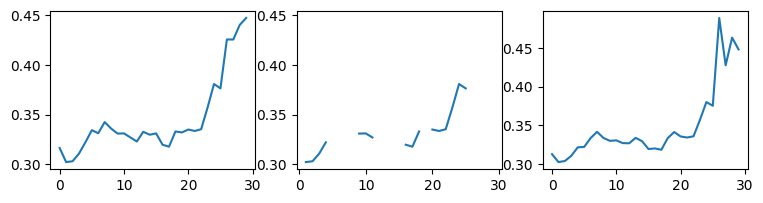

In [19]:
'对补全后数据进行画图'
x_plot = X_ori.cpu().numpy()

recove_plot = xT.permute(0, 2, 1).detach().cpu().numpy()

missing_plot = X_missed.cpu().numpy()

fig = plt.figure(figsize=(9,7))

plt.subplot(3,3,1)
plt.plot(x_plot[0][:,3])    

plt.subplot(3,3,2)
plt.plot(missing_plot[0][:,3])   

plt.subplot(3,3,3)
plt.plot(recove_plot[0][:,3])   

In [241]:
'使用其他数据集  上下两个数据用一个即可 zero-shot补全'

oneshot_data = np.loadtxt('AAL.csv',delimiter = ",")
norm_data = MinMaxScaler().fit_transform(oneshot_data)
x_oneshot = np.array(norm_data[10:40])    # 40-70     seed1 100-130
x_oneshot = torch.from_numpy(x_oneshot).float().cuda()
x_oneshot = x_oneshot.unsqueeze(dim=0)
print(x_oneshot.shape)



np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

X_ori, X_missed, missing_mask, indicating_mask = mcar(x_oneshot, 0.5, np.nan)
print(X_missed[0][0])

torch.Size([1, 30, 6])
tensor([   nan, 0.3359,    nan,    nan, 0.3304,    nan], device='cuda:0')


In [242]:
from tqdm import tqdm

import gc
gc.collect()
torch.cuda.empty_cache()


rmse_list =[]
imputation_list = []

for i in tqdm( range(10) ):             # 运行5次计算标准差
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    saits = SAITS(n_steps=30, n_features=6, n_layers=2, d_model=128, d_inner=64, n_heads=4, d_k=64, d_v=64, dropout=0.1, batch_size=10, epochs=1500)
    
    dataset = {"X": X_missed}
    
    saits.fit(dataset)               
    imputation = saits.impute(dataset)  
    imputation_list.append(imputation)
    
    imputation = torch.from_numpy(imputation).cuda()

    mae = cal_mae(imputation, X_ori, indicating_mask)    # 计算缺失位置的损失
    mse = cal_mse(imputation, X_ori, indicating_mask)
    rmse = cal_rmse(imputation, X_ori, indicating_mask)
    print(mae,mse, rmse)
    
    rmse_list.append(rmse)
    


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]2024-11-25 20:24:52 [INFO]: No given device, using default device: cuda
2024-11-25 20:24:52 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:24:52 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:24:52 [INFO]: epoch 0: training loss 0.8634
2024-11-25 20:24:52 [INFO]: epoch 1: training loss 0.8138
2024-11-25 20:24:52 [INFO]: epoch 2: training loss 0.4844
2024-11-25 20:24:52 [INFO]: epoch 3: training loss 0.5337
2024-11-25 20:24:52 [INFO]: epoch 4: training loss 0.4468
2024-11-25 20:24:52 [INFO]: epoch 5: training loss 0.4918
2024-11-25 20:24:52 [INFO]: epoch 6: training loss 0.4932
2024-11-25 20:24:52 [INFO]: epoch 7: training loss 0.4170
2024-11-25 20:24:52 [INFO]: epoch 8: training loss 0.3601
2024-11-25 20:24:52 [INFO]: epoch 9: training loss 0.4005
2024-11-25 20:24:5

2024-11-25 20:24:54 [INFO]: epoch 132: training loss 0.1030
2024-11-25 20:24:54 [INFO]: epoch 133: training loss 0.1198
2024-11-25 20:24:54 [INFO]: epoch 134: training loss 0.1177
2024-11-25 20:24:54 [INFO]: epoch 135: training loss 0.1138
2024-11-25 20:24:54 [INFO]: epoch 136: training loss 0.1085
2024-11-25 20:24:54 [INFO]: epoch 137: training loss 0.0919
2024-11-25 20:24:54 [INFO]: epoch 138: training loss 0.1240
2024-11-25 20:24:54 [INFO]: epoch 139: training loss 0.1018
2024-11-25 20:24:54 [INFO]: epoch 140: training loss 0.1100
2024-11-25 20:24:54 [INFO]: epoch 141: training loss 0.1061
2024-11-25 20:24:54 [INFO]: epoch 142: training loss 0.0910
2024-11-25 20:24:54 [INFO]: epoch 143: training loss 0.1138
2024-11-25 20:24:54 [INFO]: epoch 144: training loss 0.1246
2024-11-25 20:24:54 [INFO]: epoch 145: training loss 0.0992
2024-11-25 20:24:54 [INFO]: epoch 146: training loss 0.0914
2024-11-25 20:24:54 [INFO]: epoch 147: training loss 0.1148
2024-11-25 20:24:54 [INFO]: epoch 148: t

2024-11-25 20:24:56 [INFO]: epoch 269: training loss 0.0735
2024-11-25 20:24:56 [INFO]: epoch 270: training loss 0.0765
2024-11-25 20:24:56 [INFO]: epoch 271: training loss 0.0830
2024-11-25 20:24:56 [INFO]: epoch 272: training loss 0.0709
2024-11-25 20:24:56 [INFO]: epoch 273: training loss 0.0820
2024-11-25 20:24:56 [INFO]: epoch 274: training loss 0.0914
2024-11-25 20:24:56 [INFO]: epoch 275: training loss 0.0766
2024-11-25 20:24:56 [INFO]: epoch 276: training loss 0.0704
2024-11-25 20:24:56 [INFO]: epoch 277: training loss 0.0694
2024-11-25 20:24:56 [INFO]: epoch 278: training loss 0.0840
2024-11-25 20:24:56 [INFO]: epoch 279: training loss 0.0769
2024-11-25 20:24:56 [INFO]: epoch 280: training loss 0.0928
2024-11-25 20:24:56 [INFO]: epoch 281: training loss 0.0757
2024-11-25 20:24:56 [INFO]: epoch 282: training loss 0.0629
2024-11-25 20:24:56 [INFO]: epoch 283: training loss 0.0700
2024-11-25 20:24:56 [INFO]: epoch 284: training loss 0.0681
2024-11-25 20:24:56 [INFO]: epoch 285: t

2024-11-25 20:24:57 [INFO]: epoch 406: training loss 0.0559
2024-11-25 20:24:57 [INFO]: epoch 407: training loss 0.0530
2024-11-25 20:24:57 [INFO]: epoch 408: training loss 0.0580
2024-11-25 20:24:57 [INFO]: epoch 409: training loss 0.0533
2024-11-25 20:24:57 [INFO]: epoch 410: training loss 0.0545
2024-11-25 20:24:57 [INFO]: epoch 411: training loss 0.0501
2024-11-25 20:24:57 [INFO]: epoch 412: training loss 0.0486
2024-11-25 20:24:58 [INFO]: epoch 413: training loss 0.0566
2024-11-25 20:24:58 [INFO]: epoch 414: training loss 0.0491
2024-11-25 20:24:58 [INFO]: epoch 415: training loss 0.0617
2024-11-25 20:24:58 [INFO]: epoch 416: training loss 0.0574
2024-11-25 20:24:58 [INFO]: epoch 417: training loss 0.0466
2024-11-25 20:24:58 [INFO]: epoch 418: training loss 0.0455
2024-11-25 20:24:58 [INFO]: epoch 419: training loss 0.0484
2024-11-25 20:24:58 [INFO]: epoch 420: training loss 0.0504
2024-11-25 20:24:58 [INFO]: epoch 421: training loss 0.0481
2024-11-25 20:24:58 [INFO]: epoch 422: t

2024-11-25 20:24:59 [INFO]: epoch 543: training loss 0.0470
2024-11-25 20:24:59 [INFO]: epoch 544: training loss 0.0456
2024-11-25 20:24:59 [INFO]: epoch 545: training loss 0.0480
2024-11-25 20:24:59 [INFO]: epoch 546: training loss 0.0425
2024-11-25 20:24:59 [INFO]: epoch 547: training loss 0.0424
2024-11-25 20:24:59 [INFO]: epoch 548: training loss 0.0387
2024-11-25 20:24:59 [INFO]: epoch 549: training loss 0.0440
2024-11-25 20:24:59 [INFO]: epoch 550: training loss 0.0477
2024-11-25 20:24:59 [INFO]: epoch 551: training loss 0.0416
2024-11-25 20:24:59 [INFO]: epoch 552: training loss 0.0406
2024-11-25 20:24:59 [INFO]: epoch 553: training loss 0.0399
2024-11-25 20:24:59 [INFO]: epoch 554: training loss 0.0478
2024-11-25 20:24:59 [INFO]: epoch 555: training loss 0.0425
2024-11-25 20:24:59 [INFO]: epoch 556: training loss 0.0503
2024-11-25 20:24:59 [INFO]: epoch 557: training loss 0.0481
2024-11-25 20:25:00 [INFO]: epoch 558: training loss 0.0471
2024-11-25 20:25:00 [INFO]: epoch 559: t

2024-11-25 20:25:01 [INFO]: epoch 680: training loss 0.0346
2024-11-25 20:25:01 [INFO]: epoch 681: training loss 0.0316
2024-11-25 20:25:01 [INFO]: epoch 682: training loss 0.0353
2024-11-25 20:25:01 [INFO]: epoch 683: training loss 0.0324
2024-11-25 20:25:01 [INFO]: epoch 684: training loss 0.0339
2024-11-25 20:25:01 [INFO]: epoch 685: training loss 0.0421
2024-11-25 20:25:01 [INFO]: epoch 686: training loss 0.0341
2024-11-25 20:25:01 [INFO]: epoch 687: training loss 0.0312
2024-11-25 20:25:01 [INFO]: epoch 688: training loss 0.0355
2024-11-25 20:25:01 [INFO]: epoch 689: training loss 0.0340
2024-11-25 20:25:01 [INFO]: epoch 690: training loss 0.0284
2024-11-25 20:25:01 [INFO]: epoch 691: training loss 0.0399
2024-11-25 20:25:01 [INFO]: epoch 692: training loss 0.0364
2024-11-25 20:25:01 [INFO]: epoch 693: training loss 0.0329
2024-11-25 20:25:01 [INFO]: epoch 694: training loss 0.0341
2024-11-25 20:25:01 [INFO]: epoch 695: training loss 0.0348
2024-11-25 20:25:01 [INFO]: epoch 696: t

2024-11-25 20:25:03 [INFO]: epoch 817: training loss 0.0378
2024-11-25 20:25:03 [INFO]: epoch 818: training loss 0.0395
2024-11-25 20:25:03 [INFO]: epoch 819: training loss 0.0330
2024-11-25 20:25:03 [INFO]: epoch 820: training loss 0.0326
2024-11-25 20:25:03 [INFO]: epoch 821: training loss 0.0321
2024-11-25 20:25:03 [INFO]: epoch 822: training loss 0.0385
2024-11-25 20:25:03 [INFO]: epoch 823: training loss 0.0347
2024-11-25 20:25:03 [INFO]: epoch 824: training loss 0.0296
2024-11-25 20:25:03 [INFO]: epoch 825: training loss 0.0320
2024-11-25 20:25:03 [INFO]: epoch 826: training loss 0.0404
2024-11-25 20:25:03 [INFO]: epoch 827: training loss 0.0347
2024-11-25 20:25:03 [INFO]: epoch 828: training loss 0.0322
2024-11-25 20:25:03 [INFO]: epoch 829: training loss 0.0388
2024-11-25 20:25:03 [INFO]: epoch 830: training loss 0.0333
2024-11-25 20:25:03 [INFO]: epoch 831: training loss 0.0300
2024-11-25 20:25:03 [INFO]: epoch 832: training loss 0.0297
2024-11-25 20:25:03 [INFO]: epoch 833: t

2024-11-25 20:25:05 [INFO]: epoch 954: training loss 0.0317
2024-11-25 20:25:05 [INFO]: epoch 955: training loss 0.0324
2024-11-25 20:25:05 [INFO]: epoch 956: training loss 0.0333
2024-11-25 20:25:05 [INFO]: epoch 957: training loss 0.0290
2024-11-25 20:25:05 [INFO]: epoch 958: training loss 0.0301
2024-11-25 20:25:05 [INFO]: epoch 959: training loss 0.0315
2024-11-25 20:25:05 [INFO]: epoch 960: training loss 0.0285
2024-11-25 20:25:05 [INFO]: epoch 961: training loss 0.0286
2024-11-25 20:25:05 [INFO]: epoch 962: training loss 0.0262
2024-11-25 20:25:05 [INFO]: epoch 963: training loss 0.0314
2024-11-25 20:25:05 [INFO]: epoch 964: training loss 0.0321
2024-11-25 20:25:05 [INFO]: epoch 965: training loss 0.0329
2024-11-25 20:25:05 [INFO]: epoch 966: training loss 0.0313
2024-11-25 20:25:05 [INFO]: epoch 967: training loss 0.0306
2024-11-25 20:25:05 [INFO]: epoch 968: training loss 0.0268
2024-11-25 20:25:05 [INFO]: epoch 969: training loss 0.0338
2024-11-25 20:25:05 [INFO]: epoch 970: t

2024-11-25 20:25:07 [INFO]: epoch 1090: training loss 0.0316
2024-11-25 20:25:07 [INFO]: epoch 1091: training loss 0.0279
2024-11-25 20:25:07 [INFO]: epoch 1092: training loss 0.0265
2024-11-25 20:25:07 [INFO]: epoch 1093: training loss 0.0242
2024-11-25 20:25:07 [INFO]: epoch 1094: training loss 0.0309
2024-11-25 20:25:07 [INFO]: epoch 1095: training loss 0.0296
2024-11-25 20:25:07 [INFO]: epoch 1096: training loss 0.0249
2024-11-25 20:25:07 [INFO]: epoch 1097: training loss 0.0374
2024-11-25 20:25:07 [INFO]: epoch 1098: training loss 0.0264
2024-11-25 20:25:07 [INFO]: epoch 1099: training loss 0.0319
2024-11-25 20:25:07 [INFO]: epoch 1100: training loss 0.0313
2024-11-25 20:25:07 [INFO]: epoch 1101: training loss 0.0315
2024-11-25 20:25:07 [INFO]: epoch 1102: training loss 0.0312
2024-11-25 20:25:07 [INFO]: epoch 1103: training loss 0.0284
2024-11-25 20:25:07 [INFO]: epoch 1104: training loss 0.0278
2024-11-25 20:25:07 [INFO]: epoch 1105: training loss 0.0345
2024-11-25 20:25:07 [INF

2024-11-25 20:25:08 [INFO]: epoch 1225: training loss 0.0286
2024-11-25 20:25:08 [INFO]: epoch 1226: training loss 0.0266
2024-11-25 20:25:08 [INFO]: epoch 1227: training loss 0.0244
2024-11-25 20:25:08 [INFO]: epoch 1228: training loss 0.0219
2024-11-25 20:25:08 [INFO]: epoch 1229: training loss 0.0239
2024-11-25 20:25:08 [INFO]: epoch 1230: training loss 0.0215
2024-11-25 20:25:08 [INFO]: epoch 1231: training loss 0.0285
2024-11-25 20:25:08 [INFO]: epoch 1232: training loss 0.0251
2024-11-25 20:25:08 [INFO]: epoch 1233: training loss 0.0245
2024-11-25 20:25:08 [INFO]: epoch 1234: training loss 0.0254
2024-11-25 20:25:08 [INFO]: epoch 1235: training loss 0.0244
2024-11-25 20:25:08 [INFO]: epoch 1236: training loss 0.0270
2024-11-25 20:25:08 [INFO]: epoch 1237: training loss 0.0258
2024-11-25 20:25:09 [INFO]: epoch 1238: training loss 0.0228
2024-11-25 20:25:09 [INFO]: epoch 1239: training loss 0.0247
2024-11-25 20:25:09 [INFO]: epoch 1240: training loss 0.0250
2024-11-25 20:25:09 [INF

2024-11-25 20:25:10 [INFO]: epoch 1360: training loss 0.0234
2024-11-25 20:25:10 [INFO]: epoch 1361: training loss 0.0222
2024-11-25 20:25:10 [INFO]: epoch 1362: training loss 0.0279
2024-11-25 20:25:10 [INFO]: epoch 1363: training loss 0.0264
2024-11-25 20:25:10 [INFO]: epoch 1364: training loss 0.0197
2024-11-25 20:25:10 [INFO]: epoch 1365: training loss 0.0206
2024-11-25 20:25:10 [INFO]: epoch 1366: training loss 0.0214
2024-11-25 20:25:10 [INFO]: epoch 1367: training loss 0.0233
2024-11-25 20:25:10 [INFO]: epoch 1368: training loss 0.0258
2024-11-25 20:25:10 [INFO]: epoch 1369: training loss 0.0239
2024-11-25 20:25:10 [INFO]: epoch 1370: training loss 0.0331
2024-11-25 20:25:10 [INFO]: epoch 1371: training loss 0.0249
2024-11-25 20:25:10 [INFO]: epoch 1372: training loss 0.0257
2024-11-25 20:25:10 [INFO]: epoch 1373: training loss 0.0290
2024-11-25 20:25:10 [INFO]: epoch 1374: training loss 0.0266
2024-11-25 20:25:10 [INFO]: epoch 1375: training loss 0.0263
2024-11-25 20:25:10 [INF

2024-11-25 20:25:12 [INFO]: epoch 1495: training loss 0.0307
2024-11-25 20:25:12 [INFO]: epoch 1496: training loss 0.0254
2024-11-25 20:25:12 [INFO]: epoch 1497: training loss 0.0296
2024-11-25 20:25:12 [INFO]: epoch 1498: training loss 0.0222
2024-11-25 20:25:12 [INFO]: epoch 1499: training loss 0.0260
2024-11-25 20:25:12 [INFO]: Finished training.
 10%|████████▎                                                                          | 1/10 [00:20<03:03, 20.39s/it]2024-11-25 20:25:12 [INFO]: No given device, using default device: cuda


tensor(0.0192, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0224, device='cuda:0')


2024-11-25 20:25:12 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:12 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:12 [INFO]: epoch 0: training loss 0.8009
2024-11-25 20:25:12 [INFO]: epoch 1: training loss 0.8247
2024-11-25 20:25:12 [INFO]: epoch 2: training loss 0.7149
2024-11-25 20:25:12 [INFO]: epoch 3: training loss 0.5240
2024-11-25 20:25:12 [INFO]: epoch 4: training loss 0.5489
2024-11-25 20:25:12 [INFO]: epoch 5: training loss 0.3742
2024-11-25 20:25:12 [INFO]: epoch 6: training loss 0.4168
2024-11-25 20:25:12 [INFO]: epoch 7: training loss 0.2997
2024-11-25 20:25:12 [INFO]: epoch 8: training loss 0.3401
2024-11-25 20:25:12 [INFO]: epoch 9: training loss 0.3535
2024-11-25 20:25:12 [INFO]: epoch 10: training loss 0.3291
2024-11-25 20:25:12 [INFO]: epoch 11: training loss 0.3484
2024-11-25 20:25:12 [INFO]: epoch 12: training loss 0.3459
2024-11-25 20:25:12 [INFO]: epoc

2024-11-25 20:25:14 [INFO]: epoch 135: training loss 0.1282
2024-11-25 20:25:14 [INFO]: epoch 136: training loss 0.1148
2024-11-25 20:25:14 [INFO]: epoch 137: training loss 0.1191
2024-11-25 20:25:14 [INFO]: epoch 138: training loss 0.1326
2024-11-25 20:25:14 [INFO]: epoch 139: training loss 0.1390
2024-11-25 20:25:14 [INFO]: epoch 140: training loss 0.1297
2024-11-25 20:25:14 [INFO]: epoch 141: training loss 0.1478
2024-11-25 20:25:14 [INFO]: epoch 142: training loss 0.1280
2024-11-25 20:25:14 [INFO]: epoch 143: training loss 0.1265
2024-11-25 20:25:14 [INFO]: epoch 144: training loss 0.1235
2024-11-25 20:25:14 [INFO]: epoch 145: training loss 0.1431
2024-11-25 20:25:14 [INFO]: epoch 146: training loss 0.1083
2024-11-25 20:25:14 [INFO]: epoch 147: training loss 0.1107
2024-11-25 20:25:14 [INFO]: epoch 148: training loss 0.1072
2024-11-25 20:25:14 [INFO]: epoch 149: training loss 0.1157
2024-11-25 20:25:14 [INFO]: epoch 150: training loss 0.1048
2024-11-25 20:25:14 [INFO]: epoch 151: t

2024-11-25 20:25:16 [INFO]: epoch 272: training loss 0.0572
2024-11-25 20:25:16 [INFO]: epoch 273: training loss 0.0548
2024-11-25 20:25:16 [INFO]: epoch 274: training loss 0.0556
2024-11-25 20:25:16 [INFO]: epoch 275: training loss 0.0648
2024-11-25 20:25:16 [INFO]: epoch 276: training loss 0.0665
2024-11-25 20:25:16 [INFO]: epoch 277: training loss 0.0530
2024-11-25 20:25:16 [INFO]: epoch 278: training loss 0.0729
2024-11-25 20:25:16 [INFO]: epoch 279: training loss 0.0706
2024-11-25 20:25:16 [INFO]: epoch 280: training loss 0.0598
2024-11-25 20:25:16 [INFO]: epoch 281: training loss 0.0686
2024-11-25 20:25:16 [INFO]: epoch 282: training loss 0.0710
2024-11-25 20:25:16 [INFO]: epoch 283: training loss 0.0493
2024-11-25 20:25:16 [INFO]: epoch 284: training loss 0.0576
2024-11-25 20:25:16 [INFO]: epoch 285: training loss 0.0659
2024-11-25 20:25:16 [INFO]: epoch 286: training loss 0.0629
2024-11-25 20:25:16 [INFO]: epoch 287: training loss 0.0529
2024-11-25 20:25:16 [INFO]: epoch 288: t

2024-11-25 20:25:18 [INFO]: epoch 409: training loss 0.0376
2024-11-25 20:25:18 [INFO]: epoch 410: training loss 0.0428
2024-11-25 20:25:18 [INFO]: epoch 411: training loss 0.0417
2024-11-25 20:25:18 [INFO]: epoch 412: training loss 0.0555
2024-11-25 20:25:18 [INFO]: epoch 413: training loss 0.0421
2024-11-25 20:25:18 [INFO]: epoch 414: training loss 0.0353
2024-11-25 20:25:18 [INFO]: epoch 415: training loss 0.0450
2024-11-25 20:25:18 [INFO]: epoch 416: training loss 0.0502
2024-11-25 20:25:18 [INFO]: epoch 417: training loss 0.0472
2024-11-25 20:25:18 [INFO]: epoch 418: training loss 0.0519
2024-11-25 20:25:18 [INFO]: epoch 419: training loss 0.0522
2024-11-25 20:25:18 [INFO]: epoch 420: training loss 0.0503
2024-11-25 20:25:18 [INFO]: epoch 421: training loss 0.0599
2024-11-25 20:25:18 [INFO]: epoch 422: training loss 0.0403
2024-11-25 20:25:18 [INFO]: epoch 423: training loss 0.0574
2024-11-25 20:25:18 [INFO]: epoch 424: training loss 0.0517
2024-11-25 20:25:18 [INFO]: epoch 425: t

2024-11-25 20:25:19 [INFO]: epoch 546: training loss 0.0437
2024-11-25 20:25:19 [INFO]: epoch 547: training loss 0.0345
2024-11-25 20:25:20 [INFO]: epoch 548: training loss 0.0454
2024-11-25 20:25:20 [INFO]: epoch 549: training loss 0.0380
2024-11-25 20:25:20 [INFO]: epoch 550: training loss 0.0390
2024-11-25 20:25:20 [INFO]: epoch 551: training loss 0.0369
2024-11-25 20:25:20 [INFO]: epoch 552: training loss 0.0344
2024-11-25 20:25:20 [INFO]: epoch 553: training loss 0.0361
2024-11-25 20:25:20 [INFO]: epoch 554: training loss 0.0444
2024-11-25 20:25:20 [INFO]: epoch 555: training loss 0.0352
2024-11-25 20:25:20 [INFO]: epoch 556: training loss 0.0334
2024-11-25 20:25:20 [INFO]: epoch 557: training loss 0.0409
2024-11-25 20:25:20 [INFO]: epoch 558: training loss 0.0375
2024-11-25 20:25:20 [INFO]: epoch 559: training loss 0.0390
2024-11-25 20:25:20 [INFO]: epoch 560: training loss 0.0414
2024-11-25 20:25:20 [INFO]: epoch 561: training loss 0.0371
2024-11-25 20:25:20 [INFO]: epoch 562: t

2024-11-25 20:25:21 [INFO]: epoch 683: training loss 0.0383
2024-11-25 20:25:21 [INFO]: epoch 684: training loss 0.0295
2024-11-25 20:25:21 [INFO]: epoch 685: training loss 0.0311
2024-11-25 20:25:21 [INFO]: epoch 686: training loss 0.0342
2024-11-25 20:25:21 [INFO]: epoch 687: training loss 0.0319
2024-11-25 20:25:21 [INFO]: epoch 688: training loss 0.0264
2024-11-25 20:25:21 [INFO]: epoch 689: training loss 0.0312
2024-11-25 20:25:21 [INFO]: epoch 690: training loss 0.0292
2024-11-25 20:25:21 [INFO]: epoch 691: training loss 0.0262
2024-11-25 20:25:21 [INFO]: epoch 692: training loss 0.0289
2024-11-25 20:25:21 [INFO]: epoch 693: training loss 0.0305
2024-11-25 20:25:21 [INFO]: epoch 694: training loss 0.0321
2024-11-25 20:25:21 [INFO]: epoch 695: training loss 0.0304
2024-11-25 20:25:21 [INFO]: epoch 696: training loss 0.0350
2024-11-25 20:25:21 [INFO]: epoch 697: training loss 0.0344
2024-11-25 20:25:21 [INFO]: epoch 698: training loss 0.0344
2024-11-25 20:25:21 [INFO]: epoch 699: t

2024-11-25 20:25:23 [INFO]: epoch 820: training loss 0.0308
2024-11-25 20:25:23 [INFO]: epoch 821: training loss 0.0281
2024-11-25 20:25:23 [INFO]: epoch 822: training loss 0.0223
2024-11-25 20:25:23 [INFO]: epoch 823: training loss 0.0223
2024-11-25 20:25:23 [INFO]: epoch 824: training loss 0.0242
2024-11-25 20:25:23 [INFO]: epoch 825: training loss 0.0209
2024-11-25 20:25:23 [INFO]: epoch 826: training loss 0.0328
2024-11-25 20:25:23 [INFO]: epoch 827: training loss 0.0317
2024-11-25 20:25:23 [INFO]: epoch 828: training loss 0.0258
2024-11-25 20:25:23 [INFO]: epoch 829: training loss 0.0376
2024-11-25 20:25:23 [INFO]: epoch 830: training loss 0.0333
2024-11-25 20:25:23 [INFO]: epoch 831: training loss 0.0292
2024-11-25 20:25:23 [INFO]: epoch 832: training loss 0.0333
2024-11-25 20:25:23 [INFO]: epoch 833: training loss 0.0421
2024-11-25 20:25:23 [INFO]: epoch 834: training loss 0.0317
2024-11-25 20:25:23 [INFO]: epoch 835: training loss 0.0405
2024-11-25 20:25:23 [INFO]: epoch 836: t

2024-11-25 20:25:25 [INFO]: epoch 957: training loss 0.0294
2024-11-25 20:25:25 [INFO]: epoch 958: training loss 0.0321
2024-11-25 20:25:25 [INFO]: epoch 959: training loss 0.0207
2024-11-25 20:25:25 [INFO]: epoch 960: training loss 0.0273
2024-11-25 20:25:25 [INFO]: epoch 961: training loss 0.0243
2024-11-25 20:25:25 [INFO]: epoch 962: training loss 0.0222
2024-11-25 20:25:25 [INFO]: epoch 963: training loss 0.0296
2024-11-25 20:25:25 [INFO]: epoch 964: training loss 0.0225
2024-11-25 20:25:25 [INFO]: epoch 965: training loss 0.0283
2024-11-25 20:25:25 [INFO]: epoch 966: training loss 0.0302
2024-11-25 20:25:25 [INFO]: epoch 967: training loss 0.0270
2024-11-25 20:25:25 [INFO]: epoch 968: training loss 0.0255
2024-11-25 20:25:25 [INFO]: epoch 969: training loss 0.0271
2024-11-25 20:25:25 [INFO]: epoch 970: training loss 0.0243
2024-11-25 20:25:25 [INFO]: epoch 971: training loss 0.0294
2024-11-25 20:25:25 [INFO]: epoch 972: training loss 0.0249
2024-11-25 20:25:25 [INFO]: epoch 973: t

2024-11-25 20:25:27 [INFO]: epoch 1093: training loss 0.0224
2024-11-25 20:25:27 [INFO]: epoch 1094: training loss 0.0226
2024-11-25 20:25:27 [INFO]: epoch 1095: training loss 0.0302
2024-11-25 20:25:27 [INFO]: epoch 1096: training loss 0.0261
2024-11-25 20:25:27 [INFO]: epoch 1097: training loss 0.0246
2024-11-25 20:25:27 [INFO]: epoch 1098: training loss 0.0252
2024-11-25 20:25:27 [INFO]: epoch 1099: training loss 0.0258
2024-11-25 20:25:27 [INFO]: epoch 1100: training loss 0.0201
2024-11-25 20:25:27 [INFO]: epoch 1101: training loss 0.0216
2024-11-25 20:25:27 [INFO]: epoch 1102: training loss 0.0208
2024-11-25 20:25:27 [INFO]: epoch 1103: training loss 0.0251
2024-11-25 20:25:27 [INFO]: epoch 1104: training loss 0.0175
2024-11-25 20:25:27 [INFO]: epoch 1105: training loss 0.0214
2024-11-25 20:25:27 [INFO]: epoch 1106: training loss 0.0213
2024-11-25 20:25:27 [INFO]: epoch 1107: training loss 0.0255
2024-11-25 20:25:27 [INFO]: epoch 1108: training loss 0.0186
2024-11-25 20:25:27 [INF

2024-11-25 20:25:28 [INFO]: epoch 1228: training loss 0.0266
2024-11-25 20:25:28 [INFO]: epoch 1229: training loss 0.0258
2024-11-25 20:25:29 [INFO]: epoch 1230: training loss 0.0221
2024-11-25 20:25:29 [INFO]: epoch 1231: training loss 0.0304
2024-11-25 20:25:29 [INFO]: epoch 1232: training loss 0.0228
2024-11-25 20:25:29 [INFO]: epoch 1233: training loss 0.0210
2024-11-25 20:25:29 [INFO]: epoch 1234: training loss 0.0256
2024-11-25 20:25:29 [INFO]: epoch 1235: training loss 0.0217
2024-11-25 20:25:29 [INFO]: epoch 1236: training loss 0.0216
2024-11-25 20:25:29 [INFO]: epoch 1237: training loss 0.0250
2024-11-25 20:25:29 [INFO]: epoch 1238: training loss 0.0247
2024-11-25 20:25:29 [INFO]: epoch 1239: training loss 0.0209
2024-11-25 20:25:29 [INFO]: epoch 1240: training loss 0.0226
2024-11-25 20:25:29 [INFO]: epoch 1241: training loss 0.0220
2024-11-25 20:25:29 [INFO]: epoch 1242: training loss 0.0263
2024-11-25 20:25:29 [INFO]: epoch 1243: training loss 0.0254
2024-11-25 20:25:29 [INF

2024-11-25 20:25:30 [INFO]: epoch 1363: training loss 0.0218
2024-11-25 20:25:30 [INFO]: epoch 1364: training loss 0.0207
2024-11-25 20:25:30 [INFO]: epoch 1365: training loss 0.0205
2024-11-25 20:25:30 [INFO]: epoch 1366: training loss 0.0215
2024-11-25 20:25:30 [INFO]: epoch 1367: training loss 0.0251
2024-11-25 20:25:30 [INFO]: epoch 1368: training loss 0.0236
2024-11-25 20:25:30 [INFO]: epoch 1369: training loss 0.0198
2024-11-25 20:25:30 [INFO]: epoch 1370: training loss 0.0188
2024-11-25 20:25:30 [INFO]: epoch 1371: training loss 0.0227
2024-11-25 20:25:30 [INFO]: epoch 1372: training loss 0.0213
2024-11-25 20:25:30 [INFO]: epoch 1373: training loss 0.0267
2024-11-25 20:25:30 [INFO]: epoch 1374: training loss 0.0230
2024-11-25 20:25:30 [INFO]: epoch 1375: training loss 0.0203
2024-11-25 20:25:30 [INFO]: epoch 1376: training loss 0.0198
2024-11-25 20:25:30 [INFO]: epoch 1377: training loss 0.0253
2024-11-25 20:25:30 [INFO]: epoch 1378: training loss 0.0230
2024-11-25 20:25:30 [INF

2024-11-25 20:25:32 [INFO]: epoch 1498: training loss 0.0205
2024-11-25 20:25:32 [INFO]: epoch 1499: training loss 0.0228
2024-11-25 20:25:32 [INFO]: Finished training.
 20%|████████████████▌                                                                  | 2/10 [00:40<02:41, 20.21s/it]2024-11-25 20:25:32 [INFO]: No given device, using default device: cuda


tensor(0.0174, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0232, device='cuda:0')


2024-11-25 20:25:32 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:32 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:32 [INFO]: epoch 0: training loss 0.9249
2024-11-25 20:25:32 [INFO]: epoch 1: training loss 0.7177
2024-11-25 20:25:32 [INFO]: epoch 2: training loss 0.5547
2024-11-25 20:25:32 [INFO]: epoch 3: training loss 0.5652
2024-11-25 20:25:32 [INFO]: epoch 4: training loss 0.5936
2024-11-25 20:25:32 [INFO]: epoch 5: training loss 0.3627
2024-11-25 20:25:32 [INFO]: epoch 6: training loss 0.4208
2024-11-25 20:25:32 [INFO]: epoch 7: training loss 0.3984
2024-11-25 20:25:32 [INFO]: epoch 8: training loss 0.4904
2024-11-25 20:25:32 [INFO]: epoch 9: training loss 0.3865
2024-11-25 20:25:32 [INFO]: epoch 10: training loss 0.3243
2024-11-25 20:25:32 [INFO]: epoch 11: training loss 0.3434
2024-11-25 20:25:32 [INFO]: epoch 12: training loss 0.3722
2024-11-25 20:25:32 [INFO]: epoc

2024-11-25 20:25:34 [INFO]: epoch 135: training loss 0.1044
2024-11-25 20:25:34 [INFO]: epoch 136: training loss 0.1228
2024-11-25 20:25:34 [INFO]: epoch 137: training loss 0.1129
2024-11-25 20:25:34 [INFO]: epoch 138: training loss 0.0983
2024-11-25 20:25:34 [INFO]: epoch 139: training loss 0.0902
2024-11-25 20:25:34 [INFO]: epoch 140: training loss 0.1233
2024-11-25 20:25:34 [INFO]: epoch 141: training loss 0.0983
2024-11-25 20:25:34 [INFO]: epoch 142: training loss 0.0829
2024-11-25 20:25:34 [INFO]: epoch 143: training loss 0.0958
2024-11-25 20:25:34 [INFO]: epoch 144: training loss 0.0780
2024-11-25 20:25:34 [INFO]: epoch 145: training loss 0.0920
2024-11-25 20:25:34 [INFO]: epoch 146: training loss 0.0727
2024-11-25 20:25:34 [INFO]: epoch 147: training loss 0.0899
2024-11-25 20:25:34 [INFO]: epoch 148: training loss 0.0901
2024-11-25 20:25:34 [INFO]: epoch 149: training loss 0.1022
2024-11-25 20:25:34 [INFO]: epoch 150: training loss 0.0966
2024-11-25 20:25:34 [INFO]: epoch 151: t

2024-11-25 20:25:36 [INFO]: epoch 272: training loss 0.0623
2024-11-25 20:25:36 [INFO]: epoch 273: training loss 0.0536
2024-11-25 20:25:36 [INFO]: epoch 274: training loss 0.0610
2024-11-25 20:25:36 [INFO]: epoch 275: training loss 0.0588
2024-11-25 20:25:36 [INFO]: epoch 276: training loss 0.0626
2024-11-25 20:25:36 [INFO]: epoch 277: training loss 0.0641
2024-11-25 20:25:36 [INFO]: epoch 278: training loss 0.0506
2024-11-25 20:25:36 [INFO]: epoch 279: training loss 0.0520
2024-11-25 20:25:36 [INFO]: epoch 280: training loss 0.0556
2024-11-25 20:25:36 [INFO]: epoch 281: training loss 0.0573
2024-11-25 20:25:36 [INFO]: epoch 282: training loss 0.0594
2024-11-25 20:25:36 [INFO]: epoch 283: training loss 0.0683
2024-11-25 20:25:36 [INFO]: epoch 284: training loss 0.0546
2024-11-25 20:25:36 [INFO]: epoch 285: training loss 0.0670
2024-11-25 20:25:36 [INFO]: epoch 286: training loss 0.0659
2024-11-25 20:25:36 [INFO]: epoch 287: training loss 0.0517
2024-11-25 20:25:36 [INFO]: epoch 288: t

2024-11-25 20:25:38 [INFO]: epoch 409: training loss 0.0484
2024-11-25 20:25:38 [INFO]: epoch 410: training loss 0.0602
2024-11-25 20:25:38 [INFO]: epoch 411: training loss 0.0466
2024-11-25 20:25:38 [INFO]: epoch 412: training loss 0.0468
2024-11-25 20:25:38 [INFO]: epoch 413: training loss 0.0494
2024-11-25 20:25:38 [INFO]: epoch 414: training loss 0.0511
2024-11-25 20:25:38 [INFO]: epoch 415: training loss 0.0441
2024-11-25 20:25:38 [INFO]: epoch 416: training loss 0.0516
2024-11-25 20:25:38 [INFO]: epoch 417: training loss 0.0461
2024-11-25 20:25:38 [INFO]: epoch 418: training loss 0.0543
2024-11-25 20:25:38 [INFO]: epoch 419: training loss 0.0507
2024-11-25 20:25:38 [INFO]: epoch 420: training loss 0.0560
2024-11-25 20:25:38 [INFO]: epoch 421: training loss 0.0403
2024-11-25 20:25:38 [INFO]: epoch 422: training loss 0.0452
2024-11-25 20:25:38 [INFO]: epoch 423: training loss 0.0475
2024-11-25 20:25:38 [INFO]: epoch 424: training loss 0.0500
2024-11-25 20:25:38 [INFO]: epoch 425: t

2024-11-25 20:25:39 [INFO]: epoch 546: training loss 0.0365
2024-11-25 20:25:39 [INFO]: epoch 547: training loss 0.0377
2024-11-25 20:25:40 [INFO]: epoch 548: training loss 0.0364
2024-11-25 20:25:40 [INFO]: epoch 549: training loss 0.0373
2024-11-25 20:25:40 [INFO]: epoch 550: training loss 0.0367
2024-11-25 20:25:40 [INFO]: epoch 551: training loss 0.0366
2024-11-25 20:25:40 [INFO]: epoch 552: training loss 0.0318
2024-11-25 20:25:40 [INFO]: epoch 553: training loss 0.0379
2024-11-25 20:25:40 [INFO]: epoch 554: training loss 0.0389
2024-11-25 20:25:40 [INFO]: epoch 555: training loss 0.0357
2024-11-25 20:25:40 [INFO]: epoch 556: training loss 0.0412
2024-11-25 20:25:40 [INFO]: epoch 557: training loss 0.0357
2024-11-25 20:25:40 [INFO]: epoch 558: training loss 0.0393
2024-11-25 20:25:40 [INFO]: epoch 559: training loss 0.0339
2024-11-25 20:25:40 [INFO]: epoch 560: training loss 0.0423
2024-11-25 20:25:40 [INFO]: epoch 561: training loss 0.0361
2024-11-25 20:25:40 [INFO]: epoch 562: t

2024-11-25 20:25:41 [INFO]: epoch 683: training loss 0.0332
2024-11-25 20:25:41 [INFO]: epoch 684: training loss 0.0383
2024-11-25 20:25:41 [INFO]: epoch 685: training loss 0.0287
2024-11-25 20:25:41 [INFO]: epoch 686: training loss 0.0428
2024-11-25 20:25:41 [INFO]: epoch 687: training loss 0.0341
2024-11-25 20:25:41 [INFO]: epoch 688: training loss 0.0304
2024-11-25 20:25:41 [INFO]: epoch 689: training loss 0.0374
2024-11-25 20:25:41 [INFO]: epoch 690: training loss 0.0333
2024-11-25 20:25:41 [INFO]: epoch 691: training loss 0.0365
2024-11-25 20:25:41 [INFO]: epoch 692: training loss 0.0305
2024-11-25 20:25:41 [INFO]: epoch 693: training loss 0.0294
2024-11-25 20:25:41 [INFO]: epoch 694: training loss 0.0333
2024-11-25 20:25:41 [INFO]: epoch 695: training loss 0.0343
2024-11-25 20:25:41 [INFO]: epoch 696: training loss 0.0429
2024-11-25 20:25:41 [INFO]: epoch 697: training loss 0.0286
2024-11-25 20:25:41 [INFO]: epoch 698: training loss 0.0286
2024-11-25 20:25:41 [INFO]: epoch 699: t

2024-11-25 20:25:43 [INFO]: epoch 820: training loss 0.0278
2024-11-25 20:25:43 [INFO]: epoch 821: training loss 0.0393
2024-11-25 20:25:43 [INFO]: epoch 822: training loss 0.0347
2024-11-25 20:25:43 [INFO]: epoch 823: training loss 0.0322
2024-11-25 20:25:43 [INFO]: epoch 824: training loss 0.0399
2024-11-25 20:25:43 [INFO]: epoch 825: training loss 0.0344
2024-11-25 20:25:43 [INFO]: epoch 826: training loss 0.0298
2024-11-25 20:25:43 [INFO]: epoch 827: training loss 0.0311
2024-11-25 20:25:43 [INFO]: epoch 828: training loss 0.0322
2024-11-25 20:25:43 [INFO]: epoch 829: training loss 0.0333
2024-11-25 20:25:43 [INFO]: epoch 830: training loss 0.0317
2024-11-25 20:25:43 [INFO]: epoch 831: training loss 0.0318
2024-11-25 20:25:43 [INFO]: epoch 832: training loss 0.0379
2024-11-25 20:25:43 [INFO]: epoch 833: training loss 0.0332
2024-11-25 20:25:43 [INFO]: epoch 834: training loss 0.0338
2024-11-25 20:25:43 [INFO]: epoch 835: training loss 0.0325
2024-11-25 20:25:43 [INFO]: epoch 836: t

2024-11-25 20:25:45 [INFO]: epoch 957: training loss 0.0352
2024-11-25 20:25:45 [INFO]: epoch 958: training loss 0.0301
2024-11-25 20:25:45 [INFO]: epoch 959: training loss 0.0437
2024-11-25 20:25:45 [INFO]: epoch 960: training loss 0.0366
2024-11-25 20:25:45 [INFO]: epoch 961: training loss 0.0376
2024-11-25 20:25:45 [INFO]: epoch 962: training loss 0.0385
2024-11-25 20:25:45 [INFO]: epoch 963: training loss 0.0321
2024-11-25 20:25:45 [INFO]: epoch 964: training loss 0.0308
2024-11-25 20:25:45 [INFO]: epoch 965: training loss 0.0332
2024-11-25 20:25:45 [INFO]: epoch 966: training loss 0.0381
2024-11-25 20:25:45 [INFO]: epoch 967: training loss 0.0274
2024-11-25 20:25:45 [INFO]: epoch 968: training loss 0.0324
2024-11-25 20:25:45 [INFO]: epoch 969: training loss 0.0343
2024-11-25 20:25:45 [INFO]: epoch 970: training loss 0.0273
2024-11-25 20:25:45 [INFO]: epoch 971: training loss 0.0308
2024-11-25 20:25:45 [INFO]: epoch 972: training loss 0.0295
2024-11-25 20:25:45 [INFO]: epoch 973: t

2024-11-25 20:25:47 [INFO]: epoch 1093: training loss 0.0250
2024-11-25 20:25:47 [INFO]: epoch 1094: training loss 0.0250
2024-11-25 20:25:47 [INFO]: epoch 1095: training loss 0.0244
2024-11-25 20:25:47 [INFO]: epoch 1096: training loss 0.0247
2024-11-25 20:25:47 [INFO]: epoch 1097: training loss 0.0273
2024-11-25 20:25:47 [INFO]: epoch 1098: training loss 0.0271
2024-11-25 20:25:47 [INFO]: epoch 1099: training loss 0.0296
2024-11-25 20:25:47 [INFO]: epoch 1100: training loss 0.0275
2024-11-25 20:25:47 [INFO]: epoch 1101: training loss 0.0273
2024-11-25 20:25:47 [INFO]: epoch 1102: training loss 0.0263
2024-11-25 20:25:47 [INFO]: epoch 1103: training loss 0.0322
2024-11-25 20:25:47 [INFO]: epoch 1104: training loss 0.0245
2024-11-25 20:25:47 [INFO]: epoch 1105: training loss 0.0340
2024-11-25 20:25:47 [INFO]: epoch 1106: training loss 0.0280
2024-11-25 20:25:47 [INFO]: epoch 1107: training loss 0.0238
2024-11-25 20:25:47 [INFO]: epoch 1108: training loss 0.0290
2024-11-25 20:25:47 [INF

2024-11-25 20:25:49 [INFO]: epoch 1228: training loss 0.0259
2024-11-25 20:25:49 [INFO]: epoch 1229: training loss 0.0219
2024-11-25 20:25:49 [INFO]: epoch 1230: training loss 0.0283
2024-11-25 20:25:49 [INFO]: epoch 1231: training loss 0.0299
2024-11-25 20:25:49 [INFO]: epoch 1232: training loss 0.0248
2024-11-25 20:25:49 [INFO]: epoch 1233: training loss 0.0254
2024-11-25 20:25:49 [INFO]: epoch 1234: training loss 0.0228
2024-11-25 20:25:49 [INFO]: epoch 1235: training loss 0.0256
2024-11-25 20:25:49 [INFO]: epoch 1236: training loss 0.0253
2024-11-25 20:25:49 [INFO]: epoch 1237: training loss 0.0246
2024-11-25 20:25:49 [INFO]: epoch 1238: training loss 0.0234
2024-11-25 20:25:49 [INFO]: epoch 1239: training loss 0.0219
2024-11-25 20:25:49 [INFO]: epoch 1240: training loss 0.0247
2024-11-25 20:25:49 [INFO]: epoch 1241: training loss 0.0243
2024-11-25 20:25:49 [INFO]: epoch 1242: training loss 0.0339
2024-11-25 20:25:49 [INFO]: epoch 1243: training loss 0.0248
2024-11-25 20:25:49 [INF

2024-11-25 20:25:50 [INFO]: epoch 1363: training loss 0.0258
2024-11-25 20:25:50 [INFO]: epoch 1364: training loss 0.0273
2024-11-25 20:25:50 [INFO]: epoch 1365: training loss 0.0238
2024-11-25 20:25:50 [INFO]: epoch 1366: training loss 0.0284
2024-11-25 20:25:50 [INFO]: epoch 1367: training loss 0.0230
2024-11-25 20:25:50 [INFO]: epoch 1368: training loss 0.0337
2024-11-25 20:25:50 [INFO]: epoch 1369: training loss 0.0212
2024-11-25 20:25:51 [INFO]: epoch 1370: training loss 0.0253
2024-11-25 20:25:51 [INFO]: epoch 1371: training loss 0.0255
2024-11-25 20:25:51 [INFO]: epoch 1372: training loss 0.0209
2024-11-25 20:25:51 [INFO]: epoch 1373: training loss 0.0231
2024-11-25 20:25:51 [INFO]: epoch 1374: training loss 0.0205
2024-11-25 20:25:51 [INFO]: epoch 1375: training loss 0.0230
2024-11-25 20:25:51 [INFO]: epoch 1376: training loss 0.0265
2024-11-25 20:25:51 [INFO]: epoch 1377: training loss 0.0233
2024-11-25 20:25:51 [INFO]: epoch 1378: training loss 0.0271
2024-11-25 20:25:51 [INF

2024-11-25 20:25:52 [INFO]: epoch 1498: training loss 0.0257
2024-11-25 20:25:52 [INFO]: epoch 1499: training loss 0.0265
2024-11-25 20:25:52 [INFO]: Finished training.
 30%|████████████████████████▉                                                          | 3/10 [01:00<02:21, 20.22s/it]

tensor(0.0124, device='cuda:0') tensor(0.0004, device='cuda:0') tensor(0.0209, device='cuda:0')


2024-11-25 20:25:52 [INFO]: No given device, using default device: cuda
2024-11-25 20:25:52 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:52 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:52 [INFO]: epoch 0: training loss 0.7507
2024-11-25 20:25:52 [INFO]: epoch 1: training loss 0.6775
2024-11-25 20:25:53 [INFO]: epoch 2: training loss 0.8560
2024-11-25 20:25:53 [INFO]: epoch 3: training loss 0.7438
2024-11-25 20:25:53 [INFO]: epoch 4: training loss 0.4666
2024-11-25 20:25:53 [INFO]: epoch 5: training loss 0.4791
2024-11-25 20:25:53 [INFO]: epoch 6: training loss 0.4914
2024-11-25 20:25:53 [INFO]: epoch 7: training loss 0.4421
2024-11-25 20:25:53 [INFO]: epoch 8: training loss 0.5156
2024-11-25 20:25:53 [INFO]: epoch 9: training loss 0.4492
2024-11-25 20:25:53 [INFO]: epoch 10: training loss 0.3686
2024-11-25 20:25:53 [INFO]: epoch 11: training loss 0.4219
2024-11-25 20:25:53

2024-11-25 20:25:54 [INFO]: epoch 134: training loss 0.1120
2024-11-25 20:25:54 [INFO]: epoch 135: training loss 0.1463
2024-11-25 20:25:54 [INFO]: epoch 136: training loss 0.1478
2024-11-25 20:25:54 [INFO]: epoch 137: training loss 0.1679
2024-11-25 20:25:54 [INFO]: epoch 138: training loss 0.1538
2024-11-25 20:25:54 [INFO]: epoch 139: training loss 0.1629
2024-11-25 20:25:54 [INFO]: epoch 140: training loss 0.1649
2024-11-25 20:25:54 [INFO]: epoch 141: training loss 0.1459
2024-11-25 20:25:54 [INFO]: epoch 142: training loss 0.1282
2024-11-25 20:25:54 [INFO]: epoch 143: training loss 0.1235
2024-11-25 20:25:54 [INFO]: epoch 144: training loss 0.1510
2024-11-25 20:25:54 [INFO]: epoch 145: training loss 0.1402
2024-11-25 20:25:54 [INFO]: epoch 146: training loss 0.1289
2024-11-25 20:25:55 [INFO]: epoch 147: training loss 0.1230
2024-11-25 20:25:55 [INFO]: epoch 148: training loss 0.1317
2024-11-25 20:25:55 [INFO]: epoch 149: training loss 0.1127
2024-11-25 20:25:55 [INFO]: epoch 150: t

2024-11-25 20:25:56 [INFO]: epoch 271: training loss 0.0587
2024-11-25 20:25:56 [INFO]: epoch 272: training loss 0.0652
2024-11-25 20:25:56 [INFO]: epoch 273: training loss 0.0662
2024-11-25 20:25:56 [INFO]: epoch 274: training loss 0.0635
2024-11-25 20:25:56 [INFO]: epoch 275: training loss 0.0707
2024-11-25 20:25:56 [INFO]: epoch 276: training loss 0.0691
2024-11-25 20:25:56 [INFO]: epoch 277: training loss 0.0617
2024-11-25 20:25:56 [INFO]: epoch 278: training loss 0.0614
2024-11-25 20:25:56 [INFO]: epoch 279: training loss 0.0860
2024-11-25 20:25:56 [INFO]: epoch 280: training loss 0.0673
2024-11-25 20:25:56 [INFO]: epoch 281: training loss 0.0789
2024-11-25 20:25:56 [INFO]: epoch 282: training loss 0.0803
2024-11-25 20:25:56 [INFO]: epoch 283: training loss 0.0536
2024-11-25 20:25:56 [INFO]: epoch 284: training loss 0.0660
2024-11-25 20:25:56 [INFO]: epoch 285: training loss 0.0630
2024-11-25 20:25:57 [INFO]: epoch 286: training loss 0.0638
2024-11-25 20:25:57 [INFO]: epoch 287: t

2024-11-25 20:25:58 [INFO]: epoch 408: training loss 0.0469
2024-11-25 20:25:58 [INFO]: epoch 409: training loss 0.0485
2024-11-25 20:25:58 [INFO]: epoch 410: training loss 0.0443
2024-11-25 20:25:58 [INFO]: epoch 411: training loss 0.0439
2024-11-25 20:25:58 [INFO]: epoch 412: training loss 0.0465
2024-11-25 20:25:58 [INFO]: epoch 413: training loss 0.0444
2024-11-25 20:25:58 [INFO]: epoch 414: training loss 0.0466
2024-11-25 20:25:58 [INFO]: epoch 415: training loss 0.0434
2024-11-25 20:25:58 [INFO]: epoch 416: training loss 0.0428
2024-11-25 20:25:58 [INFO]: epoch 417: training loss 0.0587
2024-11-25 20:25:58 [INFO]: epoch 418: training loss 0.0544
2024-11-25 20:25:58 [INFO]: epoch 419: training loss 0.0477
2024-11-25 20:25:58 [INFO]: epoch 420: training loss 0.0456
2024-11-25 20:25:58 [INFO]: epoch 421: training loss 0.0519
2024-11-25 20:25:58 [INFO]: epoch 422: training loss 0.0532
2024-11-25 20:25:58 [INFO]: epoch 423: training loss 0.0495
2024-11-25 20:25:58 [INFO]: epoch 424: t

2024-11-25 20:26:00 [INFO]: epoch 545: training loss 0.0350
2024-11-25 20:26:00 [INFO]: epoch 546: training loss 0.0442
2024-11-25 20:26:00 [INFO]: epoch 547: training loss 0.0377
2024-11-25 20:26:00 [INFO]: epoch 548: training loss 0.0361
2024-11-25 20:26:00 [INFO]: epoch 549: training loss 0.0337
2024-11-25 20:26:00 [INFO]: epoch 550: training loss 0.0373
2024-11-25 20:26:00 [INFO]: epoch 551: training loss 0.0332
2024-11-25 20:26:00 [INFO]: epoch 552: training loss 0.0406
2024-11-25 20:26:00 [INFO]: epoch 553: training loss 0.0375
2024-11-25 20:26:00 [INFO]: epoch 554: training loss 0.0338
2024-11-25 20:26:00 [INFO]: epoch 555: training loss 0.0374
2024-11-25 20:26:00 [INFO]: epoch 556: training loss 0.0433
2024-11-25 20:26:00 [INFO]: epoch 557: training loss 0.0393
2024-11-25 20:26:00 [INFO]: epoch 558: training loss 0.0289
2024-11-25 20:26:00 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:26:00 [INFO]: epoch 560: training loss 0.0410
2024-11-25 20:26:00 [INFO]: epoch 561: t

2024-11-25 20:26:02 [INFO]: epoch 682: training loss 0.0291
2024-11-25 20:26:02 [INFO]: epoch 683: training loss 0.0296
2024-11-25 20:26:02 [INFO]: epoch 684: training loss 0.0332
2024-11-25 20:26:02 [INFO]: epoch 685: training loss 0.0280
2024-11-25 20:26:02 [INFO]: epoch 686: training loss 0.0287
2024-11-25 20:26:02 [INFO]: epoch 687: training loss 0.0337
2024-11-25 20:26:02 [INFO]: epoch 688: training loss 0.0333
2024-11-25 20:26:02 [INFO]: epoch 689: training loss 0.0339
2024-11-25 20:26:02 [INFO]: epoch 690: training loss 0.0400
2024-11-25 20:26:02 [INFO]: epoch 691: training loss 0.0379
2024-11-25 20:26:02 [INFO]: epoch 692: training loss 0.0296
2024-11-25 20:26:02 [INFO]: epoch 693: training loss 0.0303
2024-11-25 20:26:02 [INFO]: epoch 694: training loss 0.0278
2024-11-25 20:26:02 [INFO]: epoch 695: training loss 0.0238
2024-11-25 20:26:02 [INFO]: epoch 696: training loss 0.0271
2024-11-25 20:26:02 [INFO]: epoch 697: training loss 0.0301
2024-11-25 20:26:02 [INFO]: epoch 698: t

2024-11-25 20:26:04 [INFO]: epoch 819: training loss 0.0325
2024-11-25 20:26:04 [INFO]: epoch 820: training loss 0.0364
2024-11-25 20:26:04 [INFO]: epoch 821: training loss 0.0309
2024-11-25 20:26:04 [INFO]: epoch 822: training loss 0.0438
2024-11-25 20:26:04 [INFO]: epoch 823: training loss 0.0417
2024-11-25 20:26:04 [INFO]: epoch 824: training loss 0.0299
2024-11-25 20:26:04 [INFO]: epoch 825: training loss 0.0259
2024-11-25 20:26:04 [INFO]: epoch 826: training loss 0.0312
2024-11-25 20:26:04 [INFO]: epoch 827: training loss 0.0299
2024-11-25 20:26:04 [INFO]: epoch 828: training loss 0.0288
2024-11-25 20:26:04 [INFO]: epoch 829: training loss 0.0245
2024-11-25 20:26:04 [INFO]: epoch 830: training loss 0.0265
2024-11-25 20:26:04 [INFO]: epoch 831: training loss 0.0262
2024-11-25 20:26:04 [INFO]: epoch 832: training loss 0.0260
2024-11-25 20:26:04 [INFO]: epoch 833: training loss 0.0229
2024-11-25 20:26:04 [INFO]: epoch 834: training loss 0.0248
2024-11-25 20:26:04 [INFO]: epoch 835: t

2024-11-25 20:26:05 [INFO]: epoch 956: training loss 0.0303
2024-11-25 20:26:05 [INFO]: epoch 957: training loss 0.0322
2024-11-25 20:26:05 [INFO]: epoch 958: training loss 0.0197
2024-11-25 20:26:05 [INFO]: epoch 959: training loss 0.0326
2024-11-25 20:26:06 [INFO]: epoch 960: training loss 0.0378
2024-11-25 20:26:06 [INFO]: epoch 961: training loss 0.0282
2024-11-25 20:26:06 [INFO]: epoch 962: training loss 0.0277
2024-11-25 20:26:06 [INFO]: epoch 963: training loss 0.0379
2024-11-25 20:26:06 [INFO]: epoch 964: training loss 0.0301
2024-11-25 20:26:06 [INFO]: epoch 965: training loss 0.0248
2024-11-25 20:26:06 [INFO]: epoch 966: training loss 0.0316
2024-11-25 20:26:06 [INFO]: epoch 967: training loss 0.0324
2024-11-25 20:26:06 [INFO]: epoch 968: training loss 0.0235
2024-11-25 20:26:06 [INFO]: epoch 969: training loss 0.0314
2024-11-25 20:26:06 [INFO]: epoch 970: training loss 0.0287
2024-11-25 20:26:06 [INFO]: epoch 971: training loss 0.0288
2024-11-25 20:26:06 [INFO]: epoch 972: t

2024-11-25 20:26:07 [INFO]: epoch 1092: training loss 0.0243
2024-11-25 20:26:07 [INFO]: epoch 1093: training loss 0.0231
2024-11-25 20:26:07 [INFO]: epoch 1094: training loss 0.0228
2024-11-25 20:26:07 [INFO]: epoch 1095: training loss 0.0202
2024-11-25 20:26:07 [INFO]: epoch 1096: training loss 0.0292
2024-11-25 20:26:07 [INFO]: epoch 1097: training loss 0.0222
2024-11-25 20:26:07 [INFO]: epoch 1098: training loss 0.0248
2024-11-25 20:26:07 [INFO]: epoch 1099: training loss 0.0245
2024-11-25 20:26:07 [INFO]: epoch 1100: training loss 0.0281
2024-11-25 20:26:07 [INFO]: epoch 1101: training loss 0.0196
2024-11-25 20:26:07 [INFO]: epoch 1102: training loss 0.0229
2024-11-25 20:26:07 [INFO]: epoch 1103: training loss 0.0242
2024-11-25 20:26:07 [INFO]: epoch 1104: training loss 0.0224
2024-11-25 20:26:07 [INFO]: epoch 1105: training loss 0.0234
2024-11-25 20:26:07 [INFO]: epoch 1106: training loss 0.0240
2024-11-25 20:26:07 [INFO]: epoch 1107: training loss 0.0205
2024-11-25 20:26:07 [INF

2024-11-25 20:26:09 [INFO]: epoch 1227: training loss 0.0191
2024-11-25 20:26:09 [INFO]: epoch 1228: training loss 0.0213
2024-11-25 20:26:09 [INFO]: epoch 1229: training loss 0.0227
2024-11-25 20:26:09 [INFO]: epoch 1230: training loss 0.0207
2024-11-25 20:26:09 [INFO]: epoch 1231: training loss 0.0210
2024-11-25 20:26:09 [INFO]: epoch 1232: training loss 0.0252
2024-11-25 20:26:09 [INFO]: epoch 1233: training loss 0.0251
2024-11-25 20:26:09 [INFO]: epoch 1234: training loss 0.0214
2024-11-25 20:26:09 [INFO]: epoch 1235: training loss 0.0216
2024-11-25 20:26:09 [INFO]: epoch 1236: training loss 0.0301
2024-11-25 20:26:09 [INFO]: epoch 1237: training loss 0.0271
2024-11-25 20:26:09 [INFO]: epoch 1238: training loss 0.0218
2024-11-25 20:26:09 [INFO]: epoch 1239: training loss 0.0261
2024-11-25 20:26:09 [INFO]: epoch 1240: training loss 0.0234
2024-11-25 20:26:09 [INFO]: epoch 1241: training loss 0.0205
2024-11-25 20:26:09 [INFO]: epoch 1242: training loss 0.0253
2024-11-25 20:26:09 [INF

2024-11-25 20:26:11 [INFO]: epoch 1362: training loss 0.0189
2024-11-25 20:26:11 [INFO]: epoch 1363: training loss 0.0247
2024-11-25 20:26:11 [INFO]: epoch 1364: training loss 0.0201
2024-11-25 20:26:11 [INFO]: epoch 1365: training loss 0.0215
2024-11-25 20:26:11 [INFO]: epoch 1366: training loss 0.0210
2024-11-25 20:26:11 [INFO]: epoch 1367: training loss 0.0174
2024-11-25 20:26:11 [INFO]: epoch 1368: training loss 0.0174
2024-11-25 20:26:11 [INFO]: epoch 1369: training loss 0.0176
2024-11-25 20:26:11 [INFO]: epoch 1370: training loss 0.0201
2024-11-25 20:26:11 [INFO]: epoch 1371: training loss 0.0206
2024-11-25 20:26:11 [INFO]: epoch 1372: training loss 0.0224
2024-11-25 20:26:11 [INFO]: epoch 1373: training loss 0.0192
2024-11-25 20:26:11 [INFO]: epoch 1374: training loss 0.0182
2024-11-25 20:26:11 [INFO]: epoch 1375: training loss 0.0178
2024-11-25 20:26:11 [INFO]: epoch 1376: training loss 0.0185
2024-11-25 20:26:11 [INFO]: epoch 1377: training loss 0.0218
2024-11-25 20:26:11 [INF

2024-11-25 20:26:13 [INFO]: epoch 1497: training loss 0.0189
2024-11-25 20:26:13 [INFO]: epoch 1498: training loss 0.0224
2024-11-25 20:26:13 [INFO]: epoch 1499: training loss 0.0169
2024-11-25 20:26:13 [INFO]: Finished training.
 40%|█████████████████████████████████▏                                                 | 4/10 [01:21<02:01, 20.29s/it]2024-11-25 20:26:13 [INFO]: No given device, using default device: cuda


tensor(0.0122, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0156, device='cuda:0')


2024-11-25 20:26:13 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:13 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:13 [INFO]: epoch 0: training loss 1.1035
2024-11-25 20:26:13 [INFO]: epoch 1: training loss 0.6740
2024-11-25 20:26:13 [INFO]: epoch 2: training loss 0.6602
2024-11-25 20:26:13 [INFO]: epoch 3: training loss 0.6157
2024-11-25 20:26:13 [INFO]: epoch 4: training loss 0.5137
2024-11-25 20:26:13 [INFO]: epoch 5: training loss 0.5055
2024-11-25 20:26:13 [INFO]: epoch 6: training loss 0.4774
2024-11-25 20:26:13 [INFO]: epoch 7: training loss 0.4338
2024-11-25 20:26:13 [INFO]: epoch 8: training loss 0.4568
2024-11-25 20:26:13 [INFO]: epoch 9: training loss 0.4342
2024-11-25 20:26:13 [INFO]: epoch 10: training loss 0.4186
2024-11-25 20:26:13 [INFO]: epoch 11: training loss 0.3970
2024-11-25 20:26:13 [INFO]: epoch 12: training loss 0.4129
2024-11-25 20:26:13 [INFO]: epoc

2024-11-25 20:26:15 [INFO]: epoch 135: training loss 0.1618
2024-11-25 20:26:15 [INFO]: epoch 136: training loss 0.1545
2024-11-25 20:26:15 [INFO]: epoch 137: training loss 0.1569
2024-11-25 20:26:15 [INFO]: epoch 138: training loss 0.1499
2024-11-25 20:26:15 [INFO]: epoch 139: training loss 0.1396
2024-11-25 20:26:15 [INFO]: epoch 140: training loss 0.1277
2024-11-25 20:26:15 [INFO]: epoch 141: training loss 0.1468
2024-11-25 20:26:15 [INFO]: epoch 142: training loss 0.1549
2024-11-25 20:26:15 [INFO]: epoch 143: training loss 0.1493
2024-11-25 20:26:15 [INFO]: epoch 144: training loss 0.1491
2024-11-25 20:26:15 [INFO]: epoch 145: training loss 0.1434
2024-11-25 20:26:15 [INFO]: epoch 146: training loss 0.1597
2024-11-25 20:26:15 [INFO]: epoch 147: training loss 0.1297
2024-11-25 20:26:15 [INFO]: epoch 148: training loss 0.1382
2024-11-25 20:26:15 [INFO]: epoch 149: training loss 0.1577
2024-11-25 20:26:15 [INFO]: epoch 150: training loss 0.1346
2024-11-25 20:26:15 [INFO]: epoch 151: t

2024-11-25 20:26:17 [INFO]: epoch 272: training loss 0.0618
2024-11-25 20:26:17 [INFO]: epoch 273: training loss 0.0744
2024-11-25 20:26:17 [INFO]: epoch 274: training loss 0.0885
2024-11-25 20:26:17 [INFO]: epoch 275: training loss 0.0579
2024-11-25 20:26:17 [INFO]: epoch 276: training loss 0.0763
2024-11-25 20:26:17 [INFO]: epoch 277: training loss 0.0743
2024-11-25 20:26:17 [INFO]: epoch 278: training loss 0.0766
2024-11-25 20:26:17 [INFO]: epoch 279: training loss 0.0806
2024-11-25 20:26:17 [INFO]: epoch 280: training loss 0.0907
2024-11-25 20:26:17 [INFO]: epoch 281: training loss 0.0494
2024-11-25 20:26:17 [INFO]: epoch 282: training loss 0.0697
2024-11-25 20:26:17 [INFO]: epoch 283: training loss 0.0718
2024-11-25 20:26:17 [INFO]: epoch 284: training loss 0.0749
2024-11-25 20:26:17 [INFO]: epoch 285: training loss 0.0638
2024-11-25 20:26:17 [INFO]: epoch 286: training loss 0.0714
2024-11-25 20:26:17 [INFO]: epoch 287: training loss 0.0551
2024-11-25 20:26:17 [INFO]: epoch 288: t

2024-11-25 20:26:18 [INFO]: epoch 409: training loss 0.0435
2024-11-25 20:26:18 [INFO]: epoch 410: training loss 0.0508
2024-11-25 20:26:18 [INFO]: epoch 411: training loss 0.0433
2024-11-25 20:26:18 [INFO]: epoch 412: training loss 0.0447
2024-11-25 20:26:18 [INFO]: epoch 413: training loss 0.0445
2024-11-25 20:26:18 [INFO]: epoch 414: training loss 0.0434
2024-11-25 20:26:18 [INFO]: epoch 415: training loss 0.0383
2024-11-25 20:26:18 [INFO]: epoch 416: training loss 0.0498
2024-11-25 20:26:18 [INFO]: epoch 417: training loss 0.0426
2024-11-25 20:26:18 [INFO]: epoch 418: training loss 0.0427
2024-11-25 20:26:18 [INFO]: epoch 419: training loss 0.0525
2024-11-25 20:26:18 [INFO]: epoch 420: training loss 0.0529
2024-11-25 20:26:18 [INFO]: epoch 421: training loss 0.0497
2024-11-25 20:26:18 [INFO]: epoch 422: training loss 0.0603
2024-11-25 20:26:19 [INFO]: epoch 423: training loss 0.0376
2024-11-25 20:26:19 [INFO]: epoch 424: training loss 0.0584
2024-11-25 20:26:19 [INFO]: epoch 425: t

2024-11-25 20:26:20 [INFO]: epoch 546: training loss 0.0356
2024-11-25 20:26:20 [INFO]: epoch 547: training loss 0.0419
2024-11-25 20:26:20 [INFO]: epoch 548: training loss 0.0367
2024-11-25 20:26:20 [INFO]: epoch 549: training loss 0.0453
2024-11-25 20:26:20 [INFO]: epoch 550: training loss 0.0558
2024-11-25 20:26:20 [INFO]: epoch 551: training loss 0.0324
2024-11-25 20:26:20 [INFO]: epoch 552: training loss 0.0427
2024-11-25 20:26:20 [INFO]: epoch 553: training loss 0.0595
2024-11-25 20:26:20 [INFO]: epoch 554: training loss 0.0394
2024-11-25 20:26:20 [INFO]: epoch 555: training loss 0.0503
2024-11-25 20:26:20 [INFO]: epoch 556: training loss 0.0582
2024-11-25 20:26:20 [INFO]: epoch 557: training loss 0.0433
2024-11-25 20:26:20 [INFO]: epoch 558: training loss 0.0382
2024-11-25 20:26:20 [INFO]: epoch 559: training loss 0.0453
2024-11-25 20:26:20 [INFO]: epoch 560: training loss 0.0384
2024-11-25 20:26:20 [INFO]: epoch 561: training loss 0.0401
2024-11-25 20:26:20 [INFO]: epoch 562: t

2024-11-25 20:26:22 [INFO]: epoch 683: training loss 0.0382
2024-11-25 20:26:22 [INFO]: epoch 684: training loss 0.0362
2024-11-25 20:26:22 [INFO]: epoch 685: training loss 0.0367
2024-11-25 20:26:22 [INFO]: epoch 686: training loss 0.0304
2024-11-25 20:26:22 [INFO]: epoch 687: training loss 0.0307
2024-11-25 20:26:22 [INFO]: epoch 688: training loss 0.0386
2024-11-25 20:26:22 [INFO]: epoch 689: training loss 0.0403
2024-11-25 20:26:22 [INFO]: epoch 690: training loss 0.0311
2024-11-25 20:26:22 [INFO]: epoch 691: training loss 0.0377
2024-11-25 20:26:22 [INFO]: epoch 692: training loss 0.0333
2024-11-25 20:26:22 [INFO]: epoch 693: training loss 0.0348
2024-11-25 20:26:22 [INFO]: epoch 694: training loss 0.0312
2024-11-25 20:26:22 [INFO]: epoch 695: training loss 0.0381
2024-11-25 20:26:22 [INFO]: epoch 696: training loss 0.0320
2024-11-25 20:26:22 [INFO]: epoch 697: training loss 0.0283
2024-11-25 20:26:22 [INFO]: epoch 698: training loss 0.0336
2024-11-25 20:26:22 [INFO]: epoch 699: t

2024-11-25 20:26:24 [INFO]: epoch 820: training loss 0.0342
2024-11-25 20:26:24 [INFO]: epoch 821: training loss 0.0326
2024-11-25 20:26:24 [INFO]: epoch 822: training loss 0.0378
2024-11-25 20:26:24 [INFO]: epoch 823: training loss 0.0248
2024-11-25 20:26:24 [INFO]: epoch 824: training loss 0.0270
2024-11-25 20:26:24 [INFO]: epoch 825: training loss 0.0345
2024-11-25 20:26:24 [INFO]: epoch 826: training loss 0.0344
2024-11-25 20:26:24 [INFO]: epoch 827: training loss 0.0289
2024-11-25 20:26:24 [INFO]: epoch 828: training loss 0.0235
2024-11-25 20:26:24 [INFO]: epoch 829: training loss 0.0302
2024-11-25 20:26:24 [INFO]: epoch 830: training loss 0.0351
2024-11-25 20:26:24 [INFO]: epoch 831: training loss 0.0340
2024-11-25 20:26:24 [INFO]: epoch 832: training loss 0.0314
2024-11-25 20:26:24 [INFO]: epoch 833: training loss 0.0275
2024-11-25 20:26:24 [INFO]: epoch 834: training loss 0.0294
2024-11-25 20:26:24 [INFO]: epoch 835: training loss 0.0353
2024-11-25 20:26:24 [INFO]: epoch 836: t

2024-11-25 20:26:26 [INFO]: epoch 957: training loss 0.0287
2024-11-25 20:26:26 [INFO]: epoch 958: training loss 0.0218
2024-11-25 20:26:26 [INFO]: epoch 959: training loss 0.0284
2024-11-25 20:26:26 [INFO]: epoch 960: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 961: training loss 0.0253
2024-11-25 20:26:26 [INFO]: epoch 962: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 963: training loss 0.0265
2024-11-25 20:26:26 [INFO]: epoch 964: training loss 0.0245
2024-11-25 20:26:26 [INFO]: epoch 965: training loss 0.0301
2024-11-25 20:26:26 [INFO]: epoch 966: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 967: training loss 0.0286
2024-11-25 20:26:26 [INFO]: epoch 968: training loss 0.0333
2024-11-25 20:26:26 [INFO]: epoch 969: training loss 0.0259
2024-11-25 20:26:26 [INFO]: epoch 970: training loss 0.0263
2024-11-25 20:26:26 [INFO]: epoch 971: training loss 0.0360
2024-11-25 20:26:26 [INFO]: epoch 972: training loss 0.0309
2024-11-25 20:26:26 [INFO]: epoch 973: t

2024-11-25 20:26:27 [INFO]: epoch 1093: training loss 0.0272
2024-11-25 20:26:27 [INFO]: epoch 1094: training loss 0.0244
2024-11-25 20:26:27 [INFO]: epoch 1095: training loss 0.0253
2024-11-25 20:26:27 [INFO]: epoch 1096: training loss 0.0269
2024-11-25 20:26:27 [INFO]: epoch 1097: training loss 0.0241
2024-11-25 20:26:27 [INFO]: epoch 1098: training loss 0.0233
2024-11-25 20:26:27 [INFO]: epoch 1099: training loss 0.0275
2024-11-25 20:26:28 [INFO]: epoch 1100: training loss 0.0247
2024-11-25 20:26:28 [INFO]: epoch 1101: training loss 0.0283
2024-11-25 20:26:28 [INFO]: epoch 1102: training loss 0.0252
2024-11-25 20:26:28 [INFO]: epoch 1103: training loss 0.0272
2024-11-25 20:26:28 [INFO]: epoch 1104: training loss 0.0231
2024-11-25 20:26:28 [INFO]: epoch 1105: training loss 0.0250
2024-11-25 20:26:28 [INFO]: epoch 1106: training loss 0.0287
2024-11-25 20:26:28 [INFO]: epoch 1107: training loss 0.0313
2024-11-25 20:26:28 [INFO]: epoch 1108: training loss 0.0258
2024-11-25 20:26:28 [INF

2024-11-25 20:26:29 [INFO]: epoch 1228: training loss 0.0221
2024-11-25 20:26:29 [INFO]: epoch 1229: training loss 0.0246
2024-11-25 20:26:29 [INFO]: epoch 1230: training loss 0.0207
2024-11-25 20:26:29 [INFO]: epoch 1231: training loss 0.0206
2024-11-25 20:26:29 [INFO]: epoch 1232: training loss 0.0193
2024-11-25 20:26:29 [INFO]: epoch 1233: training loss 0.0212
2024-11-25 20:26:29 [INFO]: epoch 1234: training loss 0.0233
2024-11-25 20:26:29 [INFO]: epoch 1235: training loss 0.0193
2024-11-25 20:26:29 [INFO]: epoch 1236: training loss 0.0205
2024-11-25 20:26:29 [INFO]: epoch 1237: training loss 0.0224
2024-11-25 20:26:29 [INFO]: epoch 1238: training loss 0.0226
2024-11-25 20:26:29 [INFO]: epoch 1239: training loss 0.0227
2024-11-25 20:26:29 [INFO]: epoch 1240: training loss 0.0189
2024-11-25 20:26:29 [INFO]: epoch 1241: training loss 0.0229
2024-11-25 20:26:29 [INFO]: epoch 1242: training loss 0.0234
2024-11-25 20:26:29 [INFO]: epoch 1243: training loss 0.0213
2024-11-25 20:26:29 [INF

2024-11-25 20:26:31 [INFO]: epoch 1363: training loss 0.0230
2024-11-25 20:26:31 [INFO]: epoch 1364: training loss 0.0207
2024-11-25 20:26:31 [INFO]: epoch 1365: training loss 0.0205
2024-11-25 20:26:31 [INFO]: epoch 1366: training loss 0.0186
2024-11-25 20:26:31 [INFO]: epoch 1367: training loss 0.0193
2024-11-25 20:26:31 [INFO]: epoch 1368: training loss 0.0197
2024-11-25 20:26:31 [INFO]: epoch 1369: training loss 0.0203
2024-11-25 20:26:31 [INFO]: epoch 1370: training loss 0.0215
2024-11-25 20:26:31 [INFO]: epoch 1371: training loss 0.0200
2024-11-25 20:26:31 [INFO]: epoch 1372: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1373: training loss 0.0220
2024-11-25 20:26:31 [INFO]: epoch 1374: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1375: training loss 0.0217
2024-11-25 20:26:31 [INFO]: epoch 1376: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1377: training loss 0.0233
2024-11-25 20:26:31 [INFO]: epoch 1378: training loss 0.0198
2024-11-25 20:26:31 [INF

2024-11-25 20:26:33 [INFO]: epoch 1498: training loss 0.0173
2024-11-25 20:26:33 [INFO]: epoch 1499: training loss 0.0277
2024-11-25 20:26:33 [INFO]: Finished training.
 50%|█████████████████████████████████████████▌                                         | 5/10 [01:41<01:41, 20.23s/it]2024-11-25 20:26:33 [INFO]: No given device, using default device: cuda


tensor(0.0104, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0133, device='cuda:0')


2024-11-25 20:26:33 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:33 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:33 [INFO]: epoch 0: training loss 0.8248
2024-11-25 20:26:33 [INFO]: epoch 1: training loss 0.6788
2024-11-25 20:26:33 [INFO]: epoch 2: training loss 0.7506
2024-11-25 20:26:33 [INFO]: epoch 3: training loss 0.7568
2024-11-25 20:26:33 [INFO]: epoch 4: training loss 0.6841
2024-11-25 20:26:33 [INFO]: epoch 5: training loss 0.4783
2024-11-25 20:26:33 [INFO]: epoch 6: training loss 0.4834
2024-11-25 20:26:33 [INFO]: epoch 7: training loss 0.5317
2024-11-25 20:26:33 [INFO]: epoch 8: training loss 0.4100
2024-11-25 20:26:33 [INFO]: epoch 9: training loss 0.5269
2024-11-25 20:26:33 [INFO]: epoch 10: training loss 0.4781
2024-11-25 20:26:33 [INFO]: epoch 11: training loss 0.4355
2024-11-25 20:26:33 [INFO]: epoch 12: training loss 0.3925
2024-11-25 20:26:33 [INFO]: epoc

2024-11-25 20:26:35 [INFO]: epoch 135: training loss 0.1037
2024-11-25 20:26:35 [INFO]: epoch 136: training loss 0.1134
2024-11-25 20:26:35 [INFO]: epoch 137: training loss 0.0913
2024-11-25 20:26:35 [INFO]: epoch 138: training loss 0.1097
2024-11-25 20:26:35 [INFO]: epoch 139: training loss 0.0837
2024-11-25 20:26:35 [INFO]: epoch 140: training loss 0.1026
2024-11-25 20:26:35 [INFO]: epoch 141: training loss 0.1212
2024-11-25 20:26:35 [INFO]: epoch 142: training loss 0.0999
2024-11-25 20:26:35 [INFO]: epoch 143: training loss 0.1076
2024-11-25 20:26:35 [INFO]: epoch 144: training loss 0.0835
2024-11-25 20:26:35 [INFO]: epoch 145: training loss 0.0876
2024-11-25 20:26:35 [INFO]: epoch 146: training loss 0.0977
2024-11-25 20:26:35 [INFO]: epoch 147: training loss 0.0950
2024-11-25 20:26:35 [INFO]: epoch 148: training loss 0.0958
2024-11-25 20:26:35 [INFO]: epoch 149: training loss 0.1016
2024-11-25 20:26:35 [INFO]: epoch 150: training loss 0.0780
2024-11-25 20:26:35 [INFO]: epoch 151: t

2024-11-25 20:26:37 [INFO]: epoch 272: training loss 0.0716
2024-11-25 20:26:37 [INFO]: epoch 273: training loss 0.0592
2024-11-25 20:26:37 [INFO]: epoch 274: training loss 0.0545
2024-11-25 20:26:37 [INFO]: epoch 275: training loss 0.0552
2024-11-25 20:26:37 [INFO]: epoch 276: training loss 0.0634
2024-11-25 20:26:37 [INFO]: epoch 277: training loss 0.0566
2024-11-25 20:26:37 [INFO]: epoch 278: training loss 0.0601
2024-11-25 20:26:37 [INFO]: epoch 279: training loss 0.0644
2024-11-25 20:26:37 [INFO]: epoch 280: training loss 0.0618
2024-11-25 20:26:37 [INFO]: epoch 281: training loss 0.0738
2024-11-25 20:26:37 [INFO]: epoch 282: training loss 0.0597
2024-11-25 20:26:37 [INFO]: epoch 283: training loss 0.0650
2024-11-25 20:26:37 [INFO]: epoch 284: training loss 0.0673
2024-11-25 20:26:37 [INFO]: epoch 285: training loss 0.0737
2024-11-25 20:26:37 [INFO]: epoch 286: training loss 0.0585
2024-11-25 20:26:37 [INFO]: epoch 287: training loss 0.0580
2024-11-25 20:26:37 [INFO]: epoch 288: t

2024-11-25 20:26:38 [INFO]: epoch 409: training loss 0.0472
2024-11-25 20:26:38 [INFO]: epoch 410: training loss 0.0477
2024-11-25 20:26:38 [INFO]: epoch 411: training loss 0.0520
2024-11-25 20:26:38 [INFO]: epoch 412: training loss 0.0426
2024-11-25 20:26:38 [INFO]: epoch 413: training loss 0.0466
2024-11-25 20:26:38 [INFO]: epoch 414: training loss 0.0544
2024-11-25 20:26:39 [INFO]: epoch 415: training loss 0.0491
2024-11-25 20:26:39 [INFO]: epoch 416: training loss 0.0474
2024-11-25 20:26:39 [INFO]: epoch 417: training loss 0.0463
2024-11-25 20:26:39 [INFO]: epoch 418: training loss 0.0553
2024-11-25 20:26:39 [INFO]: epoch 419: training loss 0.0464
2024-11-25 20:26:39 [INFO]: epoch 420: training loss 0.0485
2024-11-25 20:26:39 [INFO]: epoch 421: training loss 0.0609
2024-11-25 20:26:39 [INFO]: epoch 422: training loss 0.0417
2024-11-25 20:26:39 [INFO]: epoch 423: training loss 0.0441
2024-11-25 20:26:39 [INFO]: epoch 424: training loss 0.0494
2024-11-25 20:26:39 [INFO]: epoch 425: t

2024-11-25 20:26:40 [INFO]: epoch 546: training loss 0.0482
2024-11-25 20:26:40 [INFO]: epoch 547: training loss 0.0444
2024-11-25 20:26:40 [INFO]: epoch 548: training loss 0.0459
2024-11-25 20:26:40 [INFO]: epoch 549: training loss 0.0393
2024-11-25 20:26:40 [INFO]: epoch 550: training loss 0.0470
2024-11-25 20:26:40 [INFO]: epoch 551: training loss 0.0435
2024-11-25 20:26:40 [INFO]: epoch 552: training loss 0.0402
2024-11-25 20:26:40 [INFO]: epoch 553: training loss 0.0441
2024-11-25 20:26:40 [INFO]: epoch 554: training loss 0.0517
2024-11-25 20:26:40 [INFO]: epoch 555: training loss 0.0476
2024-11-25 20:26:40 [INFO]: epoch 556: training loss 0.0418
2024-11-25 20:26:40 [INFO]: epoch 557: training loss 0.0444
2024-11-25 20:26:40 [INFO]: epoch 558: training loss 0.0388
2024-11-25 20:26:40 [INFO]: epoch 559: training loss 0.0438
2024-11-25 20:26:40 [INFO]: epoch 560: training loss 0.0449
2024-11-25 20:26:40 [INFO]: epoch 561: training loss 0.0397
2024-11-25 20:26:40 [INFO]: epoch 562: t

2024-11-25 20:26:42 [INFO]: epoch 683: training loss 0.0442
2024-11-25 20:26:42 [INFO]: epoch 684: training loss 0.0292
2024-11-25 20:26:42 [INFO]: epoch 685: training loss 0.0332
2024-11-25 20:26:42 [INFO]: epoch 686: training loss 0.0346
2024-11-25 20:26:42 [INFO]: epoch 687: training loss 0.0391
2024-11-25 20:26:42 [INFO]: epoch 688: training loss 0.0370
2024-11-25 20:26:42 [INFO]: epoch 689: training loss 0.0369
2024-11-25 20:26:42 [INFO]: epoch 690: training loss 0.0430
2024-11-25 20:26:42 [INFO]: epoch 691: training loss 0.0353
2024-11-25 20:26:42 [INFO]: epoch 692: training loss 0.0448
2024-11-25 20:26:42 [INFO]: epoch 693: training loss 0.0493
2024-11-25 20:26:42 [INFO]: epoch 694: training loss 0.0387
2024-11-25 20:26:42 [INFO]: epoch 695: training loss 0.0410
2024-11-25 20:26:42 [INFO]: epoch 696: training loss 0.0458
2024-11-25 20:26:42 [INFO]: epoch 697: training loss 0.0423
2024-11-25 20:26:42 [INFO]: epoch 698: training loss 0.0392
2024-11-25 20:26:42 [INFO]: epoch 699: t

2024-11-25 20:26:44 [INFO]: epoch 820: training loss 0.0314
2024-11-25 20:26:44 [INFO]: epoch 821: training loss 0.0306
2024-11-25 20:26:44 [INFO]: epoch 822: training loss 0.0332
2024-11-25 20:26:44 [INFO]: epoch 823: training loss 0.0433
2024-11-25 20:26:44 [INFO]: epoch 824: training loss 0.0384
2024-11-25 20:26:44 [INFO]: epoch 825: training loss 0.0405
2024-11-25 20:26:44 [INFO]: epoch 826: training loss 0.0393
2024-11-25 20:26:44 [INFO]: epoch 827: training loss 0.0387
2024-11-25 20:26:44 [INFO]: epoch 828: training loss 0.0290
2024-11-25 20:26:44 [INFO]: epoch 829: training loss 0.0305
2024-11-25 20:26:44 [INFO]: epoch 830: training loss 0.0341
2024-11-25 20:26:44 [INFO]: epoch 831: training loss 0.0407
2024-11-25 20:26:44 [INFO]: epoch 832: training loss 0.0327
2024-11-25 20:26:44 [INFO]: epoch 833: training loss 0.0291
2024-11-25 20:26:44 [INFO]: epoch 834: training loss 0.0352
2024-11-25 20:26:44 [INFO]: epoch 835: training loss 0.0323
2024-11-25 20:26:44 [INFO]: epoch 836: t

2024-11-25 20:26:46 [INFO]: epoch 957: training loss 0.0339
2024-11-25 20:26:46 [INFO]: epoch 958: training loss 0.0317
2024-11-25 20:26:46 [INFO]: epoch 959: training loss 0.0286
2024-11-25 20:26:46 [INFO]: epoch 960: training loss 0.0281
2024-11-25 20:26:46 [INFO]: epoch 961: training loss 0.0304
2024-11-25 20:26:46 [INFO]: epoch 962: training loss 0.0284
2024-11-25 20:26:46 [INFO]: epoch 963: training loss 0.0277
2024-11-25 20:26:46 [INFO]: epoch 964: training loss 0.0353
2024-11-25 20:26:46 [INFO]: epoch 965: training loss 0.0282
2024-11-25 20:26:46 [INFO]: epoch 966: training loss 0.0307
2024-11-25 20:26:46 [INFO]: epoch 967: training loss 0.0310
2024-11-25 20:26:46 [INFO]: epoch 968: training loss 0.0295
2024-11-25 20:26:46 [INFO]: epoch 969: training loss 0.0294
2024-11-25 20:26:46 [INFO]: epoch 970: training loss 0.0304
2024-11-25 20:26:46 [INFO]: epoch 971: training loss 0.0279
2024-11-25 20:26:46 [INFO]: epoch 972: training loss 0.0283
2024-11-25 20:26:46 [INFO]: epoch 973: t

2024-11-25 20:26:48 [INFO]: epoch 1093: training loss 0.0254
2024-11-25 20:26:48 [INFO]: epoch 1094: training loss 0.0317
2024-11-25 20:26:48 [INFO]: epoch 1095: training loss 0.0369
2024-11-25 20:26:48 [INFO]: epoch 1096: training loss 0.0269
2024-11-25 20:26:48 [INFO]: epoch 1097: training loss 0.0264
2024-11-25 20:26:48 [INFO]: epoch 1098: training loss 0.0264
2024-11-25 20:26:48 [INFO]: epoch 1099: training loss 0.0248
2024-11-25 20:26:48 [INFO]: epoch 1100: training loss 0.0299
2024-11-25 20:26:48 [INFO]: epoch 1101: training loss 0.0253
2024-11-25 20:26:48 [INFO]: epoch 1102: training loss 0.0334
2024-11-25 20:26:48 [INFO]: epoch 1103: training loss 0.0257
2024-11-25 20:26:48 [INFO]: epoch 1104: training loss 0.0280
2024-11-25 20:26:48 [INFO]: epoch 1105: training loss 0.0248
2024-11-25 20:26:48 [INFO]: epoch 1106: training loss 0.0250
2024-11-25 20:26:48 [INFO]: epoch 1107: training loss 0.0255
2024-11-25 20:26:48 [INFO]: epoch 1108: training loss 0.0243
2024-11-25 20:26:48 [INF

2024-11-25 20:26:49 [INFO]: epoch 1228: training loss 0.0245
2024-11-25 20:26:49 [INFO]: epoch 1229: training loss 0.0244
2024-11-25 20:26:49 [INFO]: epoch 1230: training loss 0.0248
2024-11-25 20:26:49 [INFO]: epoch 1231: training loss 0.0304
2024-11-25 20:26:49 [INFO]: epoch 1232: training loss 0.0262
2024-11-25 20:26:49 [INFO]: epoch 1233: training loss 0.0267
2024-11-25 20:26:49 [INFO]: epoch 1234: training loss 0.0256
2024-11-25 20:26:49 [INFO]: epoch 1235: training loss 0.0254
2024-11-25 20:26:49 [INFO]: epoch 1236: training loss 0.0204
2024-11-25 20:26:49 [INFO]: epoch 1237: training loss 0.0271
2024-11-25 20:26:49 [INFO]: epoch 1238: training loss 0.0261
2024-11-25 20:26:49 [INFO]: epoch 1239: training loss 0.0247
2024-11-25 20:26:49 [INFO]: epoch 1240: training loss 0.0322
2024-11-25 20:26:49 [INFO]: epoch 1241: training loss 0.0259
2024-11-25 20:26:49 [INFO]: epoch 1242: training loss 0.0254
2024-11-25 20:26:50 [INFO]: epoch 1243: training loss 0.0305
2024-11-25 20:26:50 [INF

2024-11-25 20:26:51 [INFO]: epoch 1363: training loss 0.0253
2024-11-25 20:26:51 [INFO]: epoch 1364: training loss 0.0239
2024-11-25 20:26:51 [INFO]: epoch 1365: training loss 0.0249
2024-11-25 20:26:51 [INFO]: epoch 1366: training loss 0.0234
2024-11-25 20:26:51 [INFO]: epoch 1367: training loss 0.0234
2024-11-25 20:26:51 [INFO]: epoch 1368: training loss 0.0227
2024-11-25 20:26:51 [INFO]: epoch 1369: training loss 0.0254
2024-11-25 20:26:51 [INFO]: epoch 1370: training loss 0.0191
2024-11-25 20:26:51 [INFO]: epoch 1371: training loss 0.0201
2024-11-25 20:26:51 [INFO]: epoch 1372: training loss 0.0221
2024-11-25 20:26:51 [INFO]: epoch 1373: training loss 0.0284
2024-11-25 20:26:51 [INFO]: epoch 1374: training loss 0.0261
2024-11-25 20:26:51 [INFO]: epoch 1375: training loss 0.0229
2024-11-25 20:26:51 [INFO]: epoch 1376: training loss 0.0299
2024-11-25 20:26:51 [INFO]: epoch 1377: training loss 0.0247
2024-11-25 20:26:51 [INFO]: epoch 1378: training loss 0.0238
2024-11-25 20:26:51 [INF

2024-11-25 20:26:53 [INFO]: epoch 1498: training loss 0.0201
2024-11-25 20:26:53 [INFO]: epoch 1499: training loss 0.0205
2024-11-25 20:26:53 [INFO]: Finished training.
 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:20, 20.18s/it]2024-11-25 20:26:53 [INFO]: No given device, using default device: cuda


tensor(0.0127, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0166, device='cuda:0')


2024-11-25 20:26:53 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:53 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:53 [INFO]: epoch 0: training loss 1.4049
2024-11-25 20:26:53 [INFO]: epoch 1: training loss 0.5305
2024-11-25 20:26:53 [INFO]: epoch 2: training loss 0.8157
2024-11-25 20:26:53 [INFO]: epoch 3: training loss 0.6361
2024-11-25 20:26:53 [INFO]: epoch 4: training loss 0.4509
2024-11-25 20:26:53 [INFO]: epoch 5: training loss 0.3247
2024-11-25 20:26:53 [INFO]: epoch 6: training loss 0.3861
2024-11-25 20:26:53 [INFO]: epoch 7: training loss 0.4551
2024-11-25 20:26:53 [INFO]: epoch 8: training loss 0.3750
2024-11-25 20:26:53 [INFO]: epoch 9: training loss 0.3669
2024-11-25 20:26:53 [INFO]: epoch 10: training loss 0.3814
2024-11-25 20:26:53 [INFO]: epoch 11: training loss 0.3508
2024-11-25 20:26:53 [INFO]: epoch 12: training loss 0.3205
2024-11-25 20:26:53 [INFO]: epoc

2024-11-25 20:26:55 [INFO]: epoch 135: training loss 0.1326
2024-11-25 20:26:55 [INFO]: epoch 136: training loss 0.1284
2024-11-25 20:26:55 [INFO]: epoch 137: training loss 0.1268
2024-11-25 20:26:55 [INFO]: epoch 138: training loss 0.1064
2024-11-25 20:26:55 [INFO]: epoch 139: training loss 0.1072
2024-11-25 20:26:55 [INFO]: epoch 140: training loss 0.1167
2024-11-25 20:26:55 [INFO]: epoch 141: training loss 0.1175
2024-11-25 20:26:55 [INFO]: epoch 142: training loss 0.1214
2024-11-25 20:26:55 [INFO]: epoch 143: training loss 0.1259
2024-11-25 20:26:55 [INFO]: epoch 144: training loss 0.1236
2024-11-25 20:26:55 [INFO]: epoch 145: training loss 0.1068
2024-11-25 20:26:55 [INFO]: epoch 146: training loss 0.1343
2024-11-25 20:26:55 [INFO]: epoch 147: training loss 0.1272
2024-11-25 20:26:55 [INFO]: epoch 148: training loss 0.1260
2024-11-25 20:26:55 [INFO]: epoch 149: training loss 0.1324
2024-11-25 20:26:55 [INFO]: epoch 150: training loss 0.1228
2024-11-25 20:26:55 [INFO]: epoch 151: t

2024-11-25 20:26:57 [INFO]: epoch 272: training loss 0.0791
2024-11-25 20:26:57 [INFO]: epoch 273: training loss 0.0901
2024-11-25 20:26:57 [INFO]: epoch 274: training loss 0.0813
2024-11-25 20:26:57 [INFO]: epoch 275: training loss 0.0698
2024-11-25 20:26:57 [INFO]: epoch 276: training loss 0.0610
2024-11-25 20:26:57 [INFO]: epoch 277: training loss 0.0610
2024-11-25 20:26:57 [INFO]: epoch 278: training loss 0.0664
2024-11-25 20:26:57 [INFO]: epoch 279: training loss 0.0793
2024-11-25 20:26:57 [INFO]: epoch 280: training loss 0.0639
2024-11-25 20:26:57 [INFO]: epoch 281: training loss 0.0641
2024-11-25 20:26:57 [INFO]: epoch 282: training loss 0.0588
2024-11-25 20:26:57 [INFO]: epoch 283: training loss 0.0823
2024-11-25 20:26:57 [INFO]: epoch 284: training loss 0.0820
2024-11-25 20:26:57 [INFO]: epoch 285: training loss 0.0680
2024-11-25 20:26:57 [INFO]: epoch 286: training loss 0.0666
2024-11-25 20:26:57 [INFO]: epoch 287: training loss 0.0692
2024-11-25 20:26:57 [INFO]: epoch 288: t

2024-11-25 20:26:59 [INFO]: epoch 409: training loss 0.0563
2024-11-25 20:26:59 [INFO]: epoch 410: training loss 0.0593
2024-11-25 20:26:59 [INFO]: epoch 411: training loss 0.0600
2024-11-25 20:26:59 [INFO]: epoch 412: training loss 0.0511
2024-11-25 20:26:59 [INFO]: epoch 413: training loss 0.0689
2024-11-25 20:26:59 [INFO]: epoch 414: training loss 0.0590
2024-11-25 20:26:59 [INFO]: epoch 415: training loss 0.0498
2024-11-25 20:26:59 [INFO]: epoch 416: training loss 0.0651
2024-11-25 20:26:59 [INFO]: epoch 417: training loss 0.0543
2024-11-25 20:26:59 [INFO]: epoch 418: training loss 0.0589
2024-11-25 20:26:59 [INFO]: epoch 419: training loss 0.0479
2024-11-25 20:26:59 [INFO]: epoch 420: training loss 0.0603
2024-11-25 20:26:59 [INFO]: epoch 421: training loss 0.0609
2024-11-25 20:26:59 [INFO]: epoch 422: training loss 0.0592
2024-11-25 20:26:59 [INFO]: epoch 423: training loss 0.0654
2024-11-25 20:26:59 [INFO]: epoch 424: training loss 0.0596
2024-11-25 20:26:59 [INFO]: epoch 425: t

2024-11-25 20:27:00 [INFO]: epoch 546: training loss 0.0479
2024-11-25 20:27:00 [INFO]: epoch 547: training loss 0.0483
2024-11-25 20:27:00 [INFO]: epoch 548: training loss 0.0431
2024-11-25 20:27:00 [INFO]: epoch 549: training loss 0.0424
2024-11-25 20:27:00 [INFO]: epoch 550: training loss 0.0533
2024-11-25 20:27:00 [INFO]: epoch 551: training loss 0.0464
2024-11-25 20:27:00 [INFO]: epoch 552: training loss 0.0486
2024-11-25 20:27:00 [INFO]: epoch 553: training loss 0.0422
2024-11-25 20:27:00 [INFO]: epoch 554: training loss 0.0447
2024-11-25 20:27:00 [INFO]: epoch 555: training loss 0.0491
2024-11-25 20:27:00 [INFO]: epoch 556: training loss 0.0399
2024-11-25 20:27:01 [INFO]: epoch 557: training loss 0.0479
2024-11-25 20:27:01 [INFO]: epoch 558: training loss 0.0389
2024-11-25 20:27:01 [INFO]: epoch 559: training loss 0.0494
2024-11-25 20:27:01 [INFO]: epoch 560: training loss 0.0493
2024-11-25 20:27:01 [INFO]: epoch 561: training loss 0.0459
2024-11-25 20:27:01 [INFO]: epoch 562: t

2024-11-25 20:27:02 [INFO]: epoch 683: training loss 0.0449
2024-11-25 20:27:02 [INFO]: epoch 684: training loss 0.0409
2024-11-25 20:27:02 [INFO]: epoch 685: training loss 0.0410
2024-11-25 20:27:02 [INFO]: epoch 686: training loss 0.0361
2024-11-25 20:27:02 [INFO]: epoch 687: training loss 0.0453
2024-11-25 20:27:02 [INFO]: epoch 688: training loss 0.0363
2024-11-25 20:27:02 [INFO]: epoch 689: training loss 0.0366
2024-11-25 20:27:02 [INFO]: epoch 690: training loss 0.0426
2024-11-25 20:27:02 [INFO]: epoch 691: training loss 0.0403
2024-11-25 20:27:02 [INFO]: epoch 692: training loss 0.0416
2024-11-25 20:27:02 [INFO]: epoch 693: training loss 0.0430
2024-11-25 20:27:02 [INFO]: epoch 694: training loss 0.0483
2024-11-25 20:27:02 [INFO]: epoch 695: training loss 0.0406
2024-11-25 20:27:02 [INFO]: epoch 696: training loss 0.0421
2024-11-25 20:27:02 [INFO]: epoch 697: training loss 0.0416
2024-11-25 20:27:02 [INFO]: epoch 698: training loss 0.0408
2024-11-25 20:27:02 [INFO]: epoch 699: t

2024-11-25 20:27:04 [INFO]: epoch 820: training loss 0.0298
2024-11-25 20:27:04 [INFO]: epoch 821: training loss 0.0374
2024-11-25 20:27:04 [INFO]: epoch 822: training loss 0.0471
2024-11-25 20:27:04 [INFO]: epoch 823: training loss 0.0506
2024-11-25 20:27:04 [INFO]: epoch 824: training loss 0.0373
2024-11-25 20:27:04 [INFO]: epoch 825: training loss 0.0483
2024-11-25 20:27:04 [INFO]: epoch 826: training loss 0.0556
2024-11-25 20:27:04 [INFO]: epoch 827: training loss 0.0408
2024-11-25 20:27:04 [INFO]: epoch 828: training loss 0.0427
2024-11-25 20:27:04 [INFO]: epoch 829: training loss 0.0572
2024-11-25 20:27:04 [INFO]: epoch 830: training loss 0.0449
2024-11-25 20:27:04 [INFO]: epoch 831: training loss 0.0359
2024-11-25 20:27:04 [INFO]: epoch 832: training loss 0.0367
2024-11-25 20:27:04 [INFO]: epoch 833: training loss 0.0489
2024-11-25 20:27:04 [INFO]: epoch 834: training loss 0.0403
2024-11-25 20:27:04 [INFO]: epoch 835: training loss 0.0347
2024-11-25 20:27:04 [INFO]: epoch 836: t

2024-11-25 20:27:06 [INFO]: epoch 957: training loss 0.0337
2024-11-25 20:27:06 [INFO]: epoch 958: training loss 0.0363
2024-11-25 20:27:06 [INFO]: epoch 959: training loss 0.0336
2024-11-25 20:27:06 [INFO]: epoch 960: training loss 0.0342
2024-11-25 20:27:06 [INFO]: epoch 961: training loss 0.0327
2024-11-25 20:27:06 [INFO]: epoch 962: training loss 0.0301
2024-11-25 20:27:06 [INFO]: epoch 963: training loss 0.0377
2024-11-25 20:27:06 [INFO]: epoch 964: training loss 0.0333
2024-11-25 20:27:06 [INFO]: epoch 965: training loss 0.0321
2024-11-25 20:27:06 [INFO]: epoch 966: training loss 0.0327
2024-11-25 20:27:06 [INFO]: epoch 967: training loss 0.0366
2024-11-25 20:27:06 [INFO]: epoch 968: training loss 0.0299
2024-11-25 20:27:06 [INFO]: epoch 969: training loss 0.0386
2024-11-25 20:27:06 [INFO]: epoch 970: training loss 0.0419
2024-11-25 20:27:06 [INFO]: epoch 971: training loss 0.0315
2024-11-25 20:27:06 [INFO]: epoch 972: training loss 0.0286
2024-11-25 20:27:06 [INFO]: epoch 973: t

2024-11-25 20:27:08 [INFO]: epoch 1093: training loss 0.0408
2024-11-25 20:27:08 [INFO]: epoch 1094: training loss 0.0328
2024-11-25 20:27:08 [INFO]: epoch 1095: training loss 0.0332
2024-11-25 20:27:08 [INFO]: epoch 1096: training loss 0.0351
2024-11-25 20:27:08 [INFO]: epoch 1097: training loss 0.0342
2024-11-25 20:27:08 [INFO]: epoch 1098: training loss 0.0308
2024-11-25 20:27:08 [INFO]: epoch 1099: training loss 0.0282
2024-11-25 20:27:08 [INFO]: epoch 1100: training loss 0.0327
2024-11-25 20:27:08 [INFO]: epoch 1101: training loss 0.0308
2024-11-25 20:27:08 [INFO]: epoch 1102: training loss 0.0265
2024-11-25 20:27:08 [INFO]: epoch 1103: training loss 0.0267
2024-11-25 20:27:08 [INFO]: epoch 1104: training loss 0.0365
2024-11-25 20:27:08 [INFO]: epoch 1105: training loss 0.0366
2024-11-25 20:27:08 [INFO]: epoch 1106: training loss 0.0272
2024-11-25 20:27:08 [INFO]: epoch 1107: training loss 0.0359
2024-11-25 20:27:08 [INFO]: epoch 1108: training loss 0.0353
2024-11-25 20:27:08 [INF

2024-11-25 20:27:09 [INFO]: epoch 1228: training loss 0.0274
2024-11-25 20:27:09 [INFO]: epoch 1229: training loss 0.0271
2024-11-25 20:27:09 [INFO]: epoch 1230: training loss 0.0313
2024-11-25 20:27:09 [INFO]: epoch 1231: training loss 0.0184
2024-11-25 20:27:09 [INFO]: epoch 1232: training loss 0.0277
2024-11-25 20:27:09 [INFO]: epoch 1233: training loss 0.0284
2024-11-25 20:27:09 [INFO]: epoch 1234: training loss 0.0276
2024-11-25 20:27:09 [INFO]: epoch 1235: training loss 0.0293
2024-11-25 20:27:09 [INFO]: epoch 1236: training loss 0.0250
2024-11-25 20:27:09 [INFO]: epoch 1237: training loss 0.0277
2024-11-25 20:27:09 [INFO]: epoch 1238: training loss 0.0303
2024-11-25 20:27:09 [INFO]: epoch 1239: training loss 0.0229
2024-11-25 20:27:09 [INFO]: epoch 1240: training loss 0.0250
2024-11-25 20:27:09 [INFO]: epoch 1241: training loss 0.0255
2024-11-25 20:27:09 [INFO]: epoch 1242: training loss 0.0261
2024-11-25 20:27:09 [INFO]: epoch 1243: training loss 0.0235
2024-11-25 20:27:10 [INF

2024-11-25 20:27:11 [INFO]: epoch 1363: training loss 0.0251
2024-11-25 20:27:11 [INFO]: epoch 1364: training loss 0.0242
2024-11-25 20:27:11 [INFO]: epoch 1365: training loss 0.0265
2024-11-25 20:27:11 [INFO]: epoch 1366: training loss 0.0324
2024-11-25 20:27:11 [INFO]: epoch 1367: training loss 0.0234
2024-11-25 20:27:11 [INFO]: epoch 1368: training loss 0.0230
2024-11-25 20:27:11 [INFO]: epoch 1369: training loss 0.0235
2024-11-25 20:27:11 [INFO]: epoch 1370: training loss 0.0271
2024-11-25 20:27:11 [INFO]: epoch 1371: training loss 0.0279
2024-11-25 20:27:11 [INFO]: epoch 1372: training loss 0.0246
2024-11-25 20:27:11 [INFO]: epoch 1373: training loss 0.0242
2024-11-25 20:27:11 [INFO]: epoch 1374: training loss 0.0277
2024-11-25 20:27:11 [INFO]: epoch 1375: training loss 0.0281
2024-11-25 20:27:11 [INFO]: epoch 1376: training loss 0.0237
2024-11-25 20:27:11 [INFO]: epoch 1377: training loss 0.0235
2024-11-25 20:27:11 [INFO]: epoch 1378: training loss 0.0225
2024-11-25 20:27:11 [INF

2024-11-25 20:27:13 [INFO]: epoch 1498: training loss 0.0195
2024-11-25 20:27:13 [INFO]: epoch 1499: training loss 0.0221
2024-11-25 20:27:13 [INFO]: Finished training.
 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:21<01:00, 20.13s/it]2024-11-25 20:27:13 [INFO]: No given device, using default device: cuda


tensor(0.0170, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0221, device='cuda:0')


2024-11-25 20:27:13 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:13 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:13 [INFO]: epoch 0: training loss 0.9293
2024-11-25 20:27:13 [INFO]: epoch 1: training loss 0.5773
2024-11-25 20:27:13 [INFO]: epoch 2: training loss 0.6214
2024-11-25 20:27:13 [INFO]: epoch 3: training loss 0.5822
2024-11-25 20:27:13 [INFO]: epoch 4: training loss 0.5589
2024-11-25 20:27:13 [INFO]: epoch 5: training loss 0.4920
2024-11-25 20:27:13 [INFO]: epoch 6: training loss 0.4120
2024-11-25 20:27:13 [INFO]: epoch 7: training loss 0.4700
2024-11-25 20:27:13 [INFO]: epoch 8: training loss 0.4733
2024-11-25 20:27:13 [INFO]: epoch 9: training loss 0.4158
2024-11-25 20:27:13 [INFO]: epoch 10: training loss 0.3730
2024-11-25 20:27:13 [INFO]: epoch 11: training loss 0.3575
2024-11-25 20:27:13 [INFO]: epoch 12: training loss 0.3954
2024-11-25 20:27:13 [INFO]: epoc

2024-11-25 20:27:15 [INFO]: epoch 135: training loss 0.1884
2024-11-25 20:27:15 [INFO]: epoch 136: training loss 0.1888
2024-11-25 20:27:15 [INFO]: epoch 137: training loss 0.1961
2024-11-25 20:27:15 [INFO]: epoch 138: training loss 0.1727
2024-11-25 20:27:15 [INFO]: epoch 139: training loss 0.1985
2024-11-25 20:27:15 [INFO]: epoch 140: training loss 0.2080
2024-11-25 20:27:15 [INFO]: epoch 141: training loss 0.1938
2024-11-25 20:27:15 [INFO]: epoch 142: training loss 0.1943
2024-11-25 20:27:15 [INFO]: epoch 143: training loss 0.2121
2024-11-25 20:27:15 [INFO]: epoch 144: training loss 0.1894
2024-11-25 20:27:15 [INFO]: epoch 145: training loss 0.2014
2024-11-25 20:27:15 [INFO]: epoch 146: training loss 0.1977
2024-11-25 20:27:15 [INFO]: epoch 147: training loss 0.2308
2024-11-25 20:27:15 [INFO]: epoch 148: training loss 0.1988
2024-11-25 20:27:15 [INFO]: epoch 149: training loss 0.1803
2024-11-25 20:27:15 [INFO]: epoch 150: training loss 0.2004
2024-11-25 20:27:15 [INFO]: epoch 151: t

2024-11-25 20:27:17 [INFO]: epoch 272: training loss 0.1478
2024-11-25 20:27:17 [INFO]: epoch 273: training loss 0.1431
2024-11-25 20:27:17 [INFO]: epoch 274: training loss 0.1601
2024-11-25 20:27:17 [INFO]: epoch 275: training loss 0.1293
2024-11-25 20:27:17 [INFO]: epoch 276: training loss 0.1209
2024-11-25 20:27:17 [INFO]: epoch 277: training loss 0.1328
2024-11-25 20:27:17 [INFO]: epoch 278: training loss 0.1355
2024-11-25 20:27:17 [INFO]: epoch 279: training loss 0.1442
2024-11-25 20:27:17 [INFO]: epoch 280: training loss 0.1384
2024-11-25 20:27:17 [INFO]: epoch 281: training loss 0.1305
2024-11-25 20:27:17 [INFO]: epoch 282: training loss 0.1396
2024-11-25 20:27:17 [INFO]: epoch 283: training loss 0.1343
2024-11-25 20:27:17 [INFO]: epoch 284: training loss 0.1389
2024-11-25 20:27:17 [INFO]: epoch 285: training loss 0.1322
2024-11-25 20:27:17 [INFO]: epoch 286: training loss 0.1378
2024-11-25 20:27:17 [INFO]: epoch 287: training loss 0.1358
2024-11-25 20:27:17 [INFO]: epoch 288: t

2024-11-25 20:27:19 [INFO]: epoch 409: training loss 0.1001
2024-11-25 20:27:19 [INFO]: epoch 410: training loss 0.1080
2024-11-25 20:27:19 [INFO]: epoch 411: training loss 0.1069
2024-11-25 20:27:19 [INFO]: epoch 412: training loss 0.1020
2024-11-25 20:27:19 [INFO]: epoch 413: training loss 0.1075
2024-11-25 20:27:19 [INFO]: epoch 414: training loss 0.1066
2024-11-25 20:27:19 [INFO]: epoch 415: training loss 0.1011
2024-11-25 20:27:19 [INFO]: epoch 416: training loss 0.0968
2024-11-25 20:27:19 [INFO]: epoch 417: training loss 0.1056
2024-11-25 20:27:19 [INFO]: epoch 418: training loss 0.1061
2024-11-25 20:27:19 [INFO]: epoch 419: training loss 0.1039
2024-11-25 20:27:19 [INFO]: epoch 420: training loss 0.1105
2024-11-25 20:27:19 [INFO]: epoch 421: training loss 0.0963
2024-11-25 20:27:19 [INFO]: epoch 422: training loss 0.1027
2024-11-25 20:27:19 [INFO]: epoch 423: training loss 0.1077
2024-11-25 20:27:19 [INFO]: epoch 424: training loss 0.1129
2024-11-25 20:27:19 [INFO]: epoch 425: t

2024-11-25 20:27:20 [INFO]: epoch 546: training loss 0.0829
2024-11-25 20:27:20 [INFO]: epoch 547: training loss 0.0789
2024-11-25 20:27:20 [INFO]: epoch 548: training loss 0.0838
2024-11-25 20:27:20 [INFO]: epoch 549: training loss 0.0796
2024-11-25 20:27:20 [INFO]: epoch 550: training loss 0.0875
2024-11-25 20:27:20 [INFO]: epoch 551: training loss 0.0841
2024-11-25 20:27:20 [INFO]: epoch 552: training loss 0.0826
2024-11-25 20:27:20 [INFO]: epoch 553: training loss 0.0813
2024-11-25 20:27:20 [INFO]: epoch 554: training loss 0.0820
2024-11-25 20:27:20 [INFO]: epoch 555: training loss 0.0778
2024-11-25 20:27:20 [INFO]: epoch 556: training loss 0.0754
2024-11-25 20:27:20 [INFO]: epoch 557: training loss 0.0794
2024-11-25 20:27:21 [INFO]: epoch 558: training loss 0.0791
2024-11-25 20:27:21 [INFO]: epoch 559: training loss 0.0860
2024-11-25 20:27:21 [INFO]: epoch 560: training loss 0.0834
2024-11-25 20:27:21 [INFO]: epoch 561: training loss 0.0787
2024-11-25 20:27:21 [INFO]: epoch 562: t

2024-11-25 20:27:22 [INFO]: epoch 683: training loss 0.0691
2024-11-25 20:27:22 [INFO]: epoch 684: training loss 0.0696
2024-11-25 20:27:22 [INFO]: epoch 685: training loss 0.0665
2024-11-25 20:27:22 [INFO]: epoch 686: training loss 0.0740
2024-11-25 20:27:22 [INFO]: epoch 687: training loss 0.0676
2024-11-25 20:27:22 [INFO]: epoch 688: training loss 0.0626
2024-11-25 20:27:22 [INFO]: epoch 689: training loss 0.0649
2024-11-25 20:27:22 [INFO]: epoch 690: training loss 0.0629
2024-11-25 20:27:22 [INFO]: epoch 691: training loss 0.0604
2024-11-25 20:27:22 [INFO]: epoch 692: training loss 0.0744
2024-11-25 20:27:22 [INFO]: epoch 693: training loss 0.0712
2024-11-25 20:27:22 [INFO]: epoch 694: training loss 0.0758
2024-11-25 20:27:22 [INFO]: epoch 695: training loss 0.0666
2024-11-25 20:27:22 [INFO]: epoch 696: training loss 0.0712
2024-11-25 20:27:22 [INFO]: epoch 697: training loss 0.0665
2024-11-25 20:27:22 [INFO]: epoch 698: training loss 0.0695
2024-11-25 20:27:22 [INFO]: epoch 699: t

2024-11-25 20:27:24 [INFO]: epoch 820: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 821: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 822: training loss 0.0575
2024-11-25 20:27:24 [INFO]: epoch 823: training loss 0.0554
2024-11-25 20:27:24 [INFO]: epoch 824: training loss 0.0597
2024-11-25 20:27:24 [INFO]: epoch 825: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 826: training loss 0.0533
2024-11-25 20:27:24 [INFO]: epoch 827: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 828: training loss 0.0572
2024-11-25 20:27:24 [INFO]: epoch 829: training loss 0.0530
2024-11-25 20:27:24 [INFO]: epoch 830: training loss 0.0521
2024-11-25 20:27:24 [INFO]: epoch 831: training loss 0.0535
2024-11-25 20:27:24 [INFO]: epoch 832: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 833: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 834: training loss 0.0597
2024-11-25 20:27:24 [INFO]: epoch 835: training loss 0.0619
2024-11-25 20:27:24 [INFO]: epoch 836: t

2024-11-25 20:27:26 [INFO]: epoch 957: training loss 0.0410
2024-11-25 20:27:26 [INFO]: epoch 958: training loss 0.0478
2024-11-25 20:27:26 [INFO]: epoch 959: training loss 0.0475
2024-11-25 20:27:26 [INFO]: epoch 960: training loss 0.0420
2024-11-25 20:27:26 [INFO]: epoch 961: training loss 0.0437
2024-11-25 20:27:26 [INFO]: epoch 962: training loss 0.0514
2024-11-25 20:27:26 [INFO]: epoch 963: training loss 0.0450
2024-11-25 20:27:26 [INFO]: epoch 964: training loss 0.0412
2024-11-25 20:27:26 [INFO]: epoch 965: training loss 0.0504
2024-11-25 20:27:26 [INFO]: epoch 966: training loss 0.0512
2024-11-25 20:27:26 [INFO]: epoch 967: training loss 0.0440
2024-11-25 20:27:26 [INFO]: epoch 968: training loss 0.0420
2024-11-25 20:27:26 [INFO]: epoch 969: training loss 0.0438
2024-11-25 20:27:26 [INFO]: epoch 970: training loss 0.0502
2024-11-25 20:27:26 [INFO]: epoch 971: training loss 0.0443
2024-11-25 20:27:26 [INFO]: epoch 972: training loss 0.0490
2024-11-25 20:27:26 [INFO]: epoch 973: t

2024-11-25 20:27:28 [INFO]: epoch 1093: training loss 0.0464
2024-11-25 20:27:28 [INFO]: epoch 1094: training loss 0.0459
2024-11-25 20:27:28 [INFO]: epoch 1095: training loss 0.0507
2024-11-25 20:27:28 [INFO]: epoch 1096: training loss 0.0440
2024-11-25 20:27:28 [INFO]: epoch 1097: training loss 0.0463
2024-11-25 20:27:28 [INFO]: epoch 1098: training loss 0.0405
2024-11-25 20:27:28 [INFO]: epoch 1099: training loss 0.0385
2024-11-25 20:27:28 [INFO]: epoch 1100: training loss 0.0444
2024-11-25 20:27:28 [INFO]: epoch 1101: training loss 0.0416
2024-11-25 20:27:28 [INFO]: epoch 1102: training loss 0.0426
2024-11-25 20:27:28 [INFO]: epoch 1103: training loss 0.0388
2024-11-25 20:27:28 [INFO]: epoch 1104: training loss 0.0431
2024-11-25 20:27:28 [INFO]: epoch 1105: training loss 0.0412
2024-11-25 20:27:28 [INFO]: epoch 1106: training loss 0.0485
2024-11-25 20:27:28 [INFO]: epoch 1107: training loss 0.0453
2024-11-25 20:27:28 [INFO]: epoch 1108: training loss 0.0437
2024-11-25 20:27:28 [INF

2024-11-25 20:27:29 [INFO]: epoch 1228: training loss 0.0471
2024-11-25 20:27:29 [INFO]: epoch 1229: training loss 0.0412
2024-11-25 20:27:29 [INFO]: epoch 1230: training loss 0.0438
2024-11-25 20:27:29 [INFO]: epoch 1231: training loss 0.0367
2024-11-25 20:27:30 [INFO]: epoch 1232: training loss 0.0407
2024-11-25 20:27:30 [INFO]: epoch 1233: training loss 0.0435
2024-11-25 20:27:30 [INFO]: epoch 1234: training loss 0.0474
2024-11-25 20:27:30 [INFO]: epoch 1235: training loss 0.0443
2024-11-25 20:27:30 [INFO]: epoch 1236: training loss 0.0438
2024-11-25 20:27:30 [INFO]: epoch 1237: training loss 0.0426
2024-11-25 20:27:30 [INFO]: epoch 1238: training loss 0.0406
2024-11-25 20:27:30 [INFO]: epoch 1239: training loss 0.0448
2024-11-25 20:27:30 [INFO]: epoch 1240: training loss 0.0434
2024-11-25 20:27:30 [INFO]: epoch 1241: training loss 0.0389
2024-11-25 20:27:30 [INFO]: epoch 1242: training loss 0.0500
2024-11-25 20:27:30 [INFO]: epoch 1243: training loss 0.0549
2024-11-25 20:27:30 [INF

2024-11-25 20:27:31 [INFO]: epoch 1363: training loss 0.0408
2024-11-25 20:27:31 [INFO]: epoch 1364: training loss 0.0422
2024-11-25 20:27:31 [INFO]: epoch 1365: training loss 0.0413
2024-11-25 20:27:31 [INFO]: epoch 1366: training loss 0.0436
2024-11-25 20:27:31 [INFO]: epoch 1367: training loss 0.0407
2024-11-25 20:27:31 [INFO]: epoch 1368: training loss 0.0400
2024-11-25 20:27:31 [INFO]: epoch 1369: training loss 0.0410
2024-11-25 20:27:31 [INFO]: epoch 1370: training loss 0.0438
2024-11-25 20:27:31 [INFO]: epoch 1371: training loss 0.0444
2024-11-25 20:27:31 [INFO]: epoch 1372: training loss 0.0465
2024-11-25 20:27:31 [INFO]: epoch 1373: training loss 0.0417
2024-11-25 20:27:31 [INFO]: epoch 1374: training loss 0.0391
2024-11-25 20:27:31 [INFO]: epoch 1375: training loss 0.0361
2024-11-25 20:27:31 [INFO]: epoch 1376: training loss 0.0391
2024-11-25 20:27:31 [INFO]: epoch 1377: training loss 0.0426
2024-11-25 20:27:31 [INFO]: epoch 1378: training loss 0.0415
2024-11-25 20:27:31 [INF

2024-11-25 20:27:33 [INFO]: epoch 1498: training loss 0.0378
2024-11-25 20:27:33 [INFO]: epoch 1499: training loss 0.0366
2024-11-25 20:27:33 [INFO]: Finished training.
 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:41<00:40, 20.14s/it]2024-11-25 20:27:33 [INFO]: No given device, using default device: cuda


tensor(0.0157, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0221, device='cuda:0')


2024-11-25 20:27:33 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:33 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:33 [INFO]: epoch 0: training loss 0.8817
2024-11-25 20:27:33 [INFO]: epoch 1: training loss 0.5563
2024-11-25 20:27:33 [INFO]: epoch 2: training loss 0.5251
2024-11-25 20:27:33 [INFO]: epoch 3: training loss 0.4179
2024-11-25 20:27:33 [INFO]: epoch 4: training loss 0.4608
2024-11-25 20:27:33 [INFO]: epoch 5: training loss 0.3769
2024-11-25 20:27:33 [INFO]: epoch 6: training loss 0.2776
2024-11-25 20:27:33 [INFO]: epoch 7: training loss 0.2380
2024-11-25 20:27:33 [INFO]: epoch 8: training loss 0.2899
2024-11-25 20:27:33 [INFO]: epoch 9: training loss 0.3192
2024-11-25 20:27:33 [INFO]: epoch 10: training loss 0.3426
2024-11-25 20:27:33 [INFO]: epoch 11: training loss 0.3196
2024-11-25 20:27:33 [INFO]: epoch 12: training loss 0.3726
2024-11-25 20:27:33 [INFO]: epoc

2024-11-25 20:27:35 [INFO]: epoch 135: training loss 0.0762
2024-11-25 20:27:35 [INFO]: epoch 136: training loss 0.0840
2024-11-25 20:27:35 [INFO]: epoch 137: training loss 0.1009
2024-11-25 20:27:35 [INFO]: epoch 138: training loss 0.0785
2024-11-25 20:27:35 [INFO]: epoch 139: training loss 0.0850
2024-11-25 20:27:35 [INFO]: epoch 140: training loss 0.0856
2024-11-25 20:27:35 [INFO]: epoch 141: training loss 0.0892
2024-11-25 20:27:35 [INFO]: epoch 142: training loss 0.0808
2024-11-25 20:27:35 [INFO]: epoch 143: training loss 0.0834
2024-11-25 20:27:35 [INFO]: epoch 144: training loss 0.0886
2024-11-25 20:27:35 [INFO]: epoch 145: training loss 0.0754
2024-11-25 20:27:35 [INFO]: epoch 146: training loss 0.0980
2024-11-25 20:27:35 [INFO]: epoch 147: training loss 0.1038
2024-11-25 20:27:35 [INFO]: epoch 148: training loss 0.0921
2024-11-25 20:27:35 [INFO]: epoch 149: training loss 0.1080
2024-11-25 20:27:35 [INFO]: epoch 150: training loss 0.1063
2024-11-25 20:27:35 [INFO]: epoch 151: t

2024-11-25 20:27:37 [INFO]: epoch 272: training loss 0.0612
2024-11-25 20:27:37 [INFO]: epoch 273: training loss 0.0543
2024-11-25 20:27:37 [INFO]: epoch 274: training loss 0.0517
2024-11-25 20:27:37 [INFO]: epoch 275: training loss 0.0552
2024-11-25 20:27:37 [INFO]: epoch 276: training loss 0.0604
2024-11-25 20:27:37 [INFO]: epoch 277: training loss 0.0597
2024-11-25 20:27:37 [INFO]: epoch 278: training loss 0.0643
2024-11-25 20:27:37 [INFO]: epoch 279: training loss 0.0465
2024-11-25 20:27:37 [INFO]: epoch 280: training loss 0.0676
2024-11-25 20:27:37 [INFO]: epoch 281: training loss 0.0545
2024-11-25 20:27:37 [INFO]: epoch 282: training loss 0.0607
2024-11-25 20:27:37 [INFO]: epoch 283: training loss 0.0607
2024-11-25 20:27:37 [INFO]: epoch 284: training loss 0.0515
2024-11-25 20:27:37 [INFO]: epoch 285: training loss 0.0549
2024-11-25 20:27:37 [INFO]: epoch 286: training loss 0.0444
2024-11-25 20:27:37 [INFO]: epoch 287: training loss 0.0403
2024-11-25 20:27:37 [INFO]: epoch 288: t

2024-11-25 20:27:39 [INFO]: epoch 409: training loss 0.0455
2024-11-25 20:27:39 [INFO]: epoch 410: training loss 0.0400
2024-11-25 20:27:39 [INFO]: epoch 411: training loss 0.0421
2024-11-25 20:27:39 [INFO]: epoch 412: training loss 0.0444
2024-11-25 20:27:39 [INFO]: epoch 413: training loss 0.0537
2024-11-25 20:27:39 [INFO]: epoch 414: training loss 0.0435
2024-11-25 20:27:39 [INFO]: epoch 415: training loss 0.0475
2024-11-25 20:27:39 [INFO]: epoch 416: training loss 0.0509
2024-11-25 20:27:39 [INFO]: epoch 417: training loss 0.0496
2024-11-25 20:27:39 [INFO]: epoch 418: training loss 0.0429
2024-11-25 20:27:39 [INFO]: epoch 419: training loss 0.0437
2024-11-25 20:27:39 [INFO]: epoch 420: training loss 0.0376
2024-11-25 20:27:39 [INFO]: epoch 421: training loss 0.0401
2024-11-25 20:27:39 [INFO]: epoch 422: training loss 0.0378
2024-11-25 20:27:39 [INFO]: epoch 423: training loss 0.0404
2024-11-25 20:27:39 [INFO]: epoch 424: training loss 0.0422
2024-11-25 20:27:39 [INFO]: epoch 425: t

2024-11-25 20:27:41 [INFO]: epoch 546: training loss 0.0318
2024-11-25 20:27:41 [INFO]: epoch 547: training loss 0.0356
2024-11-25 20:27:41 [INFO]: epoch 548: training loss 0.0345
2024-11-25 20:27:41 [INFO]: epoch 549: training loss 0.0332
2024-11-25 20:27:41 [INFO]: epoch 550: training loss 0.0386
2024-11-25 20:27:41 [INFO]: epoch 551: training loss 0.0358
2024-11-25 20:27:41 [INFO]: epoch 552: training loss 0.0349
2024-11-25 20:27:41 [INFO]: epoch 553: training loss 0.0401
2024-11-25 20:27:41 [INFO]: epoch 554: training loss 0.0334
2024-11-25 20:27:41 [INFO]: epoch 555: training loss 0.0349
2024-11-25 20:27:41 [INFO]: epoch 556: training loss 0.0302
2024-11-25 20:27:41 [INFO]: epoch 557: training loss 0.0296
2024-11-25 20:27:41 [INFO]: epoch 558: training loss 0.0325
2024-11-25 20:27:41 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:27:41 [INFO]: epoch 560: training loss 0.0341
2024-11-25 20:27:41 [INFO]: epoch 561: training loss 0.0291
2024-11-25 20:27:41 [INFO]: epoch 562: t

2024-11-25 20:27:42 [INFO]: epoch 683: training loss 0.0284
2024-11-25 20:27:42 [INFO]: epoch 684: training loss 0.0274
2024-11-25 20:27:42 [INFO]: epoch 685: training loss 0.0268
2024-11-25 20:27:42 [INFO]: epoch 686: training loss 0.0307
2024-11-25 20:27:42 [INFO]: epoch 687: training loss 0.0293
2024-11-25 20:27:42 [INFO]: epoch 688: training loss 0.0275
2024-11-25 20:27:42 [INFO]: epoch 689: training loss 0.0232
2024-11-25 20:27:42 [INFO]: epoch 690: training loss 0.0263
2024-11-25 20:27:43 [INFO]: epoch 691: training loss 0.0302
2024-11-25 20:27:43 [INFO]: epoch 692: training loss 0.0277
2024-11-25 20:27:43 [INFO]: epoch 693: training loss 0.0263
2024-11-25 20:27:43 [INFO]: epoch 694: training loss 0.0269
2024-11-25 20:27:43 [INFO]: epoch 695: training loss 0.0302
2024-11-25 20:27:43 [INFO]: epoch 696: training loss 0.0308
2024-11-25 20:27:43 [INFO]: epoch 697: training loss 0.0291
2024-11-25 20:27:43 [INFO]: epoch 698: training loss 0.0306
2024-11-25 20:27:43 [INFO]: epoch 699: t

2024-11-25 20:27:44 [INFO]: epoch 820: training loss 0.0274
2024-11-25 20:27:44 [INFO]: epoch 821: training loss 0.0412
2024-11-25 20:27:44 [INFO]: epoch 822: training loss 0.0390
2024-11-25 20:27:44 [INFO]: epoch 823: training loss 0.0259
2024-11-25 20:27:44 [INFO]: epoch 824: training loss 0.0312
2024-11-25 20:27:44 [INFO]: epoch 825: training loss 0.0531
2024-11-25 20:27:44 [INFO]: epoch 826: training loss 0.0287
2024-11-25 20:27:44 [INFO]: epoch 827: training loss 0.0277
2024-11-25 20:27:44 [INFO]: epoch 828: training loss 0.0295
2024-11-25 20:27:44 [INFO]: epoch 829: training loss 0.0379
2024-11-25 20:27:44 [INFO]: epoch 830: training loss 0.0297
2024-11-25 20:27:44 [INFO]: epoch 831: training loss 0.0244
2024-11-25 20:27:44 [INFO]: epoch 832: training loss 0.0325
2024-11-25 20:27:44 [INFO]: epoch 833: training loss 0.0339
2024-11-25 20:27:44 [INFO]: epoch 834: training loss 0.0285
2024-11-25 20:27:44 [INFO]: epoch 835: training loss 0.0341
2024-11-25 20:27:44 [INFO]: epoch 836: t

2024-11-25 20:27:46 [INFO]: epoch 957: training loss 0.0246
2024-11-25 20:27:46 [INFO]: epoch 958: training loss 0.0258
2024-11-25 20:27:46 [INFO]: epoch 959: training loss 0.0316
2024-11-25 20:27:46 [INFO]: epoch 960: training loss 0.0245
2024-11-25 20:27:46 [INFO]: epoch 961: training loss 0.0222
2024-11-25 20:27:46 [INFO]: epoch 962: training loss 0.0228
2024-11-25 20:27:46 [INFO]: epoch 963: training loss 0.0314
2024-11-25 20:27:46 [INFO]: epoch 964: training loss 0.0254
2024-11-25 20:27:46 [INFO]: epoch 965: training loss 0.0191
2024-11-25 20:27:46 [INFO]: epoch 966: training loss 0.0243
2024-11-25 20:27:46 [INFO]: epoch 967: training loss 0.0309
2024-11-25 20:27:46 [INFO]: epoch 968: training loss 0.0258
2024-11-25 20:27:46 [INFO]: epoch 969: training loss 0.0260
2024-11-25 20:27:46 [INFO]: epoch 970: training loss 0.0338
2024-11-25 20:27:46 [INFO]: epoch 971: training loss 0.0234
2024-11-25 20:27:46 [INFO]: epoch 972: training loss 0.0283
2024-11-25 20:27:46 [INFO]: epoch 973: t

2024-11-25 20:27:48 [INFO]: epoch 1093: training loss 0.0202
2024-11-25 20:27:48 [INFO]: epoch 1094: training loss 0.0214
2024-11-25 20:27:48 [INFO]: epoch 1095: training loss 0.0274
2024-11-25 20:27:48 [INFO]: epoch 1096: training loss 0.0261
2024-11-25 20:27:48 [INFO]: epoch 1097: training loss 0.0203
2024-11-25 20:27:48 [INFO]: epoch 1098: training loss 0.0259
2024-11-25 20:27:48 [INFO]: epoch 1099: training loss 0.0224
2024-11-25 20:27:48 [INFO]: epoch 1100: training loss 0.0261
2024-11-25 20:27:48 [INFO]: epoch 1101: training loss 0.0235
2024-11-25 20:27:48 [INFO]: epoch 1102: training loss 0.0209
2024-11-25 20:27:48 [INFO]: epoch 1103: training loss 0.0191
2024-11-25 20:27:48 [INFO]: epoch 1104: training loss 0.0221
2024-11-25 20:27:48 [INFO]: epoch 1105: training loss 0.0201
2024-11-25 20:27:48 [INFO]: epoch 1106: training loss 0.0184
2024-11-25 20:27:48 [INFO]: epoch 1107: training loss 0.0198
2024-11-25 20:27:48 [INFO]: epoch 1108: training loss 0.0222
2024-11-25 20:27:48 [INF

2024-11-25 20:27:50 [INFO]: epoch 1228: training loss 0.0190
2024-11-25 20:27:50 [INFO]: epoch 1229: training loss 0.0193
2024-11-25 20:27:50 [INFO]: epoch 1230: training loss 0.0203
2024-11-25 20:27:50 [INFO]: epoch 1231: training loss 0.0222
2024-11-25 20:27:50 [INFO]: epoch 1232: training loss 0.0181
2024-11-25 20:27:50 [INFO]: epoch 1233: training loss 0.0200
2024-11-25 20:27:50 [INFO]: epoch 1234: training loss 0.0188
2024-11-25 20:27:50 [INFO]: epoch 1235: training loss 0.0221
2024-11-25 20:27:50 [INFO]: epoch 1236: training loss 0.0211
2024-11-25 20:27:50 [INFO]: epoch 1237: training loss 0.0217
2024-11-25 20:27:50 [INFO]: epoch 1238: training loss 0.0221
2024-11-25 20:27:50 [INFO]: epoch 1239: training loss 0.0229
2024-11-25 20:27:50 [INFO]: epoch 1240: training loss 0.0165
2024-11-25 20:27:50 [INFO]: epoch 1241: training loss 0.0315
2024-11-25 20:27:50 [INFO]: epoch 1242: training loss 0.0198
2024-11-25 20:27:50 [INFO]: epoch 1243: training loss 0.0167
2024-11-25 20:27:50 [INF

2024-11-25 20:27:51 [INFO]: epoch 1363: training loss 0.0182
2024-11-25 20:27:51 [INFO]: epoch 1364: training loss 0.0211
2024-11-25 20:27:51 [INFO]: epoch 1365: training loss 0.0210
2024-11-25 20:27:51 [INFO]: epoch 1366: training loss 0.0161
2024-11-25 20:27:52 [INFO]: epoch 1367: training loss 0.0160
2024-11-25 20:27:52 [INFO]: epoch 1368: training loss 0.0172
2024-11-25 20:27:52 [INFO]: epoch 1369: training loss 0.0210
2024-11-25 20:27:52 [INFO]: epoch 1370: training loss 0.0169
2024-11-25 20:27:52 [INFO]: epoch 1371: training loss 0.0160
2024-11-25 20:27:52 [INFO]: epoch 1372: training loss 0.0210
2024-11-25 20:27:52 [INFO]: epoch 1373: training loss 0.0212
2024-11-25 20:27:52 [INFO]: epoch 1374: training loss 0.0157
2024-11-25 20:27:52 [INFO]: epoch 1375: training loss 0.0190
2024-11-25 20:27:52 [INFO]: epoch 1376: training loss 0.0190
2024-11-25 20:27:52 [INFO]: epoch 1377: training loss 0.0188
2024-11-25 20:27:52 [INFO]: epoch 1378: training loss 0.0264
2024-11-25 20:27:52 [INF

2024-11-25 20:27:53 [INFO]: epoch 1498: training loss 0.0164
2024-11-25 20:27:53 [INFO]: epoch 1499: training loss 0.0187
2024-11-25 20:27:53 [INFO]: Finished training.
 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:01<00:20, 20.15s/it]2024-11-25 20:27:53 [INFO]: No given device, using default device: cuda


tensor(0.0121, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0169, device='cuda:0')


2024-11-25 20:27:53 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:53 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:53 [INFO]: epoch 0: training loss 1.1930
2024-11-25 20:27:53 [INFO]: epoch 1: training loss 0.7848
2024-11-25 20:27:53 [INFO]: epoch 2: training loss 0.5471
2024-11-25 20:27:53 [INFO]: epoch 3: training loss 0.6450
2024-11-25 20:27:53 [INFO]: epoch 4: training loss 0.6040
2024-11-25 20:27:53 [INFO]: epoch 5: training loss 0.6301
2024-11-25 20:27:54 [INFO]: epoch 6: training loss 0.6144
2024-11-25 20:27:54 [INFO]: epoch 7: training loss 0.5588
2024-11-25 20:27:54 [INFO]: epoch 8: training loss 0.4822
2024-11-25 20:27:54 [INFO]: epoch 9: training loss 0.5004
2024-11-25 20:27:54 [INFO]: epoch 10: training loss 0.5115
2024-11-25 20:27:54 [INFO]: epoch 11: training loss 0.4685
2024-11-25 20:27:54 [INFO]: epoch 12: training loss 0.4280
2024-11-25 20:27:54 [INFO]: epoc

2024-11-25 20:27:55 [INFO]: epoch 135: training loss 0.1808
2024-11-25 20:27:55 [INFO]: epoch 136: training loss 0.1798
2024-11-25 20:27:55 [INFO]: epoch 137: training loss 0.1951
2024-11-25 20:27:55 [INFO]: epoch 138: training loss 0.1777
2024-11-25 20:27:55 [INFO]: epoch 139: training loss 0.1635
2024-11-25 20:27:55 [INFO]: epoch 140: training loss 0.2082
2024-11-25 20:27:55 [INFO]: epoch 141: training loss 0.1939
2024-11-25 20:27:55 [INFO]: epoch 142: training loss 0.1812
2024-11-25 20:27:55 [INFO]: epoch 143: training loss 0.1934
2024-11-25 20:27:55 [INFO]: epoch 144: training loss 0.2101
2024-11-25 20:27:55 [INFO]: epoch 145: training loss 0.2163
2024-11-25 20:27:55 [INFO]: epoch 146: training loss 0.2056
2024-11-25 20:27:55 [INFO]: epoch 147: training loss 0.1899
2024-11-25 20:27:55 [INFO]: epoch 148: training loss 0.2100
2024-11-25 20:27:55 [INFO]: epoch 149: training loss 0.2377
2024-11-25 20:27:55 [INFO]: epoch 150: training loss 0.1558
2024-11-25 20:27:55 [INFO]: epoch 151: t

2024-11-25 20:27:57 [INFO]: epoch 272: training loss 0.0912
2024-11-25 20:27:57 [INFO]: epoch 273: training loss 0.0892
2024-11-25 20:27:57 [INFO]: epoch 274: training loss 0.0985
2024-11-25 20:27:57 [INFO]: epoch 275: training loss 0.0919
2024-11-25 20:27:57 [INFO]: epoch 276: training loss 0.0941
2024-11-25 20:27:57 [INFO]: epoch 277: training loss 0.0923
2024-11-25 20:27:57 [INFO]: epoch 278: training loss 0.1017
2024-11-25 20:27:57 [INFO]: epoch 279: training loss 0.0973
2024-11-25 20:27:57 [INFO]: epoch 280: training loss 0.1182
2024-11-25 20:27:57 [INFO]: epoch 281: training loss 0.0964
2024-11-25 20:27:57 [INFO]: epoch 282: training loss 0.0927
2024-11-25 20:27:57 [INFO]: epoch 283: training loss 0.1051
2024-11-25 20:27:57 [INFO]: epoch 284: training loss 0.0850
2024-11-25 20:27:57 [INFO]: epoch 285: training loss 0.0934
2024-11-25 20:27:57 [INFO]: epoch 286: training loss 0.0934
2024-11-25 20:27:57 [INFO]: epoch 287: training loss 0.0875
2024-11-25 20:27:57 [INFO]: epoch 288: t

2024-11-25 20:27:59 [INFO]: epoch 409: training loss 0.0506
2024-11-25 20:27:59 [INFO]: epoch 410: training loss 0.0645
2024-11-25 20:27:59 [INFO]: epoch 411: training loss 0.0584
2024-11-25 20:27:59 [INFO]: epoch 412: training loss 0.0581
2024-11-25 20:27:59 [INFO]: epoch 413: training loss 0.0640
2024-11-25 20:27:59 [INFO]: epoch 414: training loss 0.0532
2024-11-25 20:27:59 [INFO]: epoch 415: training loss 0.0436
2024-11-25 20:27:59 [INFO]: epoch 416: training loss 0.0444
2024-11-25 20:27:59 [INFO]: epoch 417: training loss 0.0522
2024-11-25 20:27:59 [INFO]: epoch 418: training loss 0.0532
2024-11-25 20:27:59 [INFO]: epoch 419: training loss 0.0604
2024-11-25 20:27:59 [INFO]: epoch 420: training loss 0.0608
2024-11-25 20:27:59 [INFO]: epoch 421: training loss 0.0624
2024-11-25 20:27:59 [INFO]: epoch 422: training loss 0.0501
2024-11-25 20:27:59 [INFO]: epoch 423: training loss 0.0489
2024-11-25 20:27:59 [INFO]: epoch 424: training loss 0.0575
2024-11-25 20:27:59 [INFO]: epoch 425: t

2024-11-25 20:28:01 [INFO]: epoch 546: training loss 0.0390
2024-11-25 20:28:01 [INFO]: epoch 547: training loss 0.0446
2024-11-25 20:28:01 [INFO]: epoch 548: training loss 0.0369
2024-11-25 20:28:01 [INFO]: epoch 549: training loss 0.0427
2024-11-25 20:28:01 [INFO]: epoch 550: training loss 0.0474
2024-11-25 20:28:01 [INFO]: epoch 551: training loss 0.0368
2024-11-25 20:28:01 [INFO]: epoch 552: training loss 0.0392
2024-11-25 20:28:01 [INFO]: epoch 553: training loss 0.0532
2024-11-25 20:28:01 [INFO]: epoch 554: training loss 0.0473
2024-11-25 20:28:01 [INFO]: epoch 555: training loss 0.0362
2024-11-25 20:28:01 [INFO]: epoch 556: training loss 0.0398
2024-11-25 20:28:01 [INFO]: epoch 557: training loss 0.0354
2024-11-25 20:28:01 [INFO]: epoch 558: training loss 0.0362
2024-11-25 20:28:01 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:28:01 [INFO]: epoch 560: training loss 0.0412
2024-11-25 20:28:01 [INFO]: epoch 561: training loss 0.0326
2024-11-25 20:28:01 [INFO]: epoch 562: t

2024-11-25 20:28:02 [INFO]: epoch 683: training loss 0.0309
2024-11-25 20:28:02 [INFO]: epoch 684: training loss 0.0314
2024-11-25 20:28:02 [INFO]: epoch 685: training loss 0.0326
2024-11-25 20:28:02 [INFO]: epoch 686: training loss 0.0355
2024-11-25 20:28:02 [INFO]: epoch 687: training loss 0.0349
2024-11-25 20:28:02 [INFO]: epoch 688: training loss 0.0393
2024-11-25 20:28:02 [INFO]: epoch 689: training loss 0.0332
2024-11-25 20:28:02 [INFO]: epoch 690: training loss 0.0322
2024-11-25 20:28:03 [INFO]: epoch 691: training loss 0.0465
2024-11-25 20:28:03 [INFO]: epoch 692: training loss 0.0363
2024-11-25 20:28:03 [INFO]: epoch 693: training loss 0.0370
2024-11-25 20:28:03 [INFO]: epoch 694: training loss 0.0358
2024-11-25 20:28:03 [INFO]: epoch 695: training loss 0.0324
2024-11-25 20:28:03 [INFO]: epoch 696: training loss 0.0340
2024-11-25 20:28:03 [INFO]: epoch 697: training loss 0.0359
2024-11-25 20:28:03 [INFO]: epoch 698: training loss 0.0409
2024-11-25 20:28:03 [INFO]: epoch 699: t

2024-11-25 20:28:04 [INFO]: epoch 820: training loss 0.0315
2024-11-25 20:28:04 [INFO]: epoch 821: training loss 0.0333
2024-11-25 20:28:04 [INFO]: epoch 822: training loss 0.0333
2024-11-25 20:28:04 [INFO]: epoch 823: training loss 0.0327
2024-11-25 20:28:04 [INFO]: epoch 824: training loss 0.0279
2024-11-25 20:28:04 [INFO]: epoch 825: training loss 0.0308
2024-11-25 20:28:04 [INFO]: epoch 826: training loss 0.0284
2024-11-25 20:28:04 [INFO]: epoch 827: training loss 0.0295
2024-11-25 20:28:04 [INFO]: epoch 828: training loss 0.0311
2024-11-25 20:28:04 [INFO]: epoch 829: training loss 0.0297
2024-11-25 20:28:04 [INFO]: epoch 830: training loss 0.0324
2024-11-25 20:28:04 [INFO]: epoch 831: training loss 0.0312
2024-11-25 20:28:04 [INFO]: epoch 832: training loss 0.0309
2024-11-25 20:28:04 [INFO]: epoch 833: training loss 0.0260
2024-11-25 20:28:04 [INFO]: epoch 834: training loss 0.0281
2024-11-25 20:28:04 [INFO]: epoch 835: training loss 0.0291
2024-11-25 20:28:04 [INFO]: epoch 836: t

2024-11-25 20:28:06 [INFO]: epoch 957: training loss 0.0241
2024-11-25 20:28:06 [INFO]: epoch 958: training loss 0.0237
2024-11-25 20:28:06 [INFO]: epoch 959: training loss 0.0297
2024-11-25 20:28:06 [INFO]: epoch 960: training loss 0.0229
2024-11-25 20:28:06 [INFO]: epoch 961: training loss 0.0229
2024-11-25 20:28:06 [INFO]: epoch 962: training loss 0.0251
2024-11-25 20:28:06 [INFO]: epoch 963: training loss 0.0282
2024-11-25 20:28:06 [INFO]: epoch 964: training loss 0.0258
2024-11-25 20:28:06 [INFO]: epoch 965: training loss 0.0353
2024-11-25 20:28:06 [INFO]: epoch 966: training loss 0.0261
2024-11-25 20:28:06 [INFO]: epoch 967: training loss 0.0278
2024-11-25 20:28:06 [INFO]: epoch 968: training loss 0.0273
2024-11-25 20:28:06 [INFO]: epoch 969: training loss 0.0308
2024-11-25 20:28:06 [INFO]: epoch 970: training loss 0.0321
2024-11-25 20:28:06 [INFO]: epoch 971: training loss 0.0288
2024-11-25 20:28:06 [INFO]: epoch 972: training loss 0.0239
2024-11-25 20:28:06 [INFO]: epoch 973: t

2024-11-25 20:28:08 [INFO]: epoch 1093: training loss 0.0461
2024-11-25 20:28:08 [INFO]: epoch 1094: training loss 0.0276
2024-11-25 20:28:08 [INFO]: epoch 1095: training loss 0.0331
2024-11-25 20:28:08 [INFO]: epoch 1096: training loss 0.0419
2024-11-25 20:28:08 [INFO]: epoch 1097: training loss 0.0358
2024-11-25 20:28:08 [INFO]: epoch 1098: training loss 0.0265
2024-11-25 20:28:08 [INFO]: epoch 1099: training loss 0.0330
2024-11-25 20:28:08 [INFO]: epoch 1100: training loss 0.0285
2024-11-25 20:28:08 [INFO]: epoch 1101: training loss 0.0232
2024-11-25 20:28:08 [INFO]: epoch 1102: training loss 0.0298
2024-11-25 20:28:08 [INFO]: epoch 1103: training loss 0.0327
2024-11-25 20:28:08 [INFO]: epoch 1104: training loss 0.0237
2024-11-25 20:28:08 [INFO]: epoch 1105: training loss 0.0282
2024-11-25 20:28:08 [INFO]: epoch 1106: training loss 0.0306
2024-11-25 20:28:08 [INFO]: epoch 1107: training loss 0.0241
2024-11-25 20:28:08 [INFO]: epoch 1108: training loss 0.0211
2024-11-25 20:28:08 [INF

2024-11-25 20:28:10 [INFO]: epoch 1228: training loss 0.0321
2024-11-25 20:28:10 [INFO]: epoch 1229: training loss 0.0242
2024-11-25 20:28:10 [INFO]: epoch 1230: training loss 0.0203
2024-11-25 20:28:10 [INFO]: epoch 1231: training loss 0.0286
2024-11-25 20:28:10 [INFO]: epoch 1232: training loss 0.0256
2024-11-25 20:28:10 [INFO]: epoch 1233: training loss 0.0238
2024-11-25 20:28:10 [INFO]: epoch 1234: training loss 0.0217
2024-11-25 20:28:10 [INFO]: epoch 1235: training loss 0.0262
2024-11-25 20:28:10 [INFO]: epoch 1236: training loss 0.0299
2024-11-25 20:28:10 [INFO]: epoch 1237: training loss 0.0241
2024-11-25 20:28:10 [INFO]: epoch 1238: training loss 0.0260
2024-11-25 20:28:10 [INFO]: epoch 1239: training loss 0.0244
2024-11-25 20:28:10 [INFO]: epoch 1240: training loss 0.0230
2024-11-25 20:28:10 [INFO]: epoch 1241: training loss 0.0249
2024-11-25 20:28:10 [INFO]: epoch 1242: training loss 0.0233
2024-11-25 20:28:10 [INFO]: epoch 1243: training loss 0.0196
2024-11-25 20:28:10 [INF

2024-11-25 20:28:11 [INFO]: epoch 1363: training loss 0.0188
2024-11-25 20:28:11 [INFO]: epoch 1364: training loss 0.0185
2024-11-25 20:28:11 [INFO]: epoch 1365: training loss 0.0198
2024-11-25 20:28:11 [INFO]: epoch 1366: training loss 0.0215
2024-11-25 20:28:11 [INFO]: epoch 1367: training loss 0.0238
2024-11-25 20:28:11 [INFO]: epoch 1368: training loss 0.0203
2024-11-25 20:28:11 [INFO]: epoch 1369: training loss 0.0189
2024-11-25 20:28:11 [INFO]: epoch 1370: training loss 0.0225
2024-11-25 20:28:11 [INFO]: epoch 1371: training loss 0.0169
2024-11-25 20:28:11 [INFO]: epoch 1372: training loss 0.0271
2024-11-25 20:28:11 [INFO]: epoch 1373: training loss 0.0241
2024-11-25 20:28:12 [INFO]: epoch 1374: training loss 0.0214
2024-11-25 20:28:12 [INFO]: epoch 1375: training loss 0.0246
2024-11-25 20:28:12 [INFO]: epoch 1376: training loss 0.0228
2024-11-25 20:28:12 [INFO]: epoch 1377: training loss 0.0193
2024-11-25 20:28:12 [INFO]: epoch 1378: training loss 0.0227
2024-11-25 20:28:12 [INF

2024-11-25 20:28:13 [INFO]: epoch 1498: training loss 0.0168
2024-11-25 20:28:13 [INFO]: epoch 1499: training loss 0.0242
2024-11-25 20:28:13 [INFO]: Finished training.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:21<00:00, 20.16s/it]

tensor(0.0152, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0229, device='cuda:0')


In [243]:
print(len(imputation_list))

imp = np.array(imputation_list).reshape((10,30,6)) 

print(imp.shape)

np.save('saits_s1_missed.npy', X_missed.cpu().numpy())
# np.save('saits_s1_s10_e600.npy', imp)
np.save('saits_s1_s10_e1500.npy', imp)

# np.save('saits_s2_missed.npy', X_missed.cpu().numpy())
# np.save('saits_s2_s10_e600.npy', imp)
# np.save('saits_s2_s10_e1500.npy', imp)


10
(10, 30, 6)


In [244]:
res = torch.from_numpy(imp)

fig = plt.figure(figsize=(7,4))

# res1_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res1_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res1_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res1_005.shape)


res2_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
res2_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
res2_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
print(res2_005.shape)


# res3_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res3_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res3_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res3_005.shape)


# res4_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res4_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res4_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res4_005.shape)


(30, 6)


<Figure size 700x400 with 0 Axes>

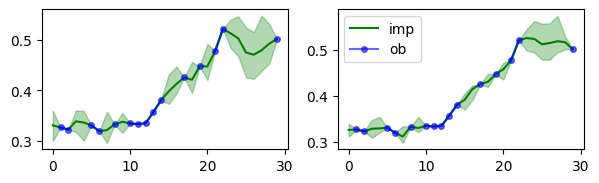

In [245]:
fig = plt.figure(figsize=(7,4))

X_missed1 = X_missed

plt.subplot(2,2,1)
plt.plot(res1_05[:,3], color = 'g', label='imp') 
plt.fill_between( range(0,30), res1_005[:,3], res1_095[:,3], color='g', alpha=0.3)  # alpha是透明程度
plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob') # 观测值的蓝色把之前的值覆盖了 生成区域的值还是之前的0.5分位数的

plt.subplot(2,2,2)
plt.plot(res2_05[:,3], color = 'g', label='imp') 
plt.fill_between( range(0,30), res2_005[:,3], res2_095[:,3], color='g', alpha=0.3)  
plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')


# X_missed2 = X_missed

# plt.subplot(2,2,3)
# plt.plot(res3_05[:,3], color = 'g', label='imp') 
# plt.fill_between( range(0,30), res3_005[:,3], res3_095[:,3], color='g', alpha=0.3)  
# plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')


# plt.subplot(2,2,4)
# plt.plot(res4_05[:,3], color = 'g', label='imp') 
# plt.fill_between( range(0,30), res4_005[:,3], res4_095[:,3], color='g', alpha=0.3)  
# plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')

plt.legend()

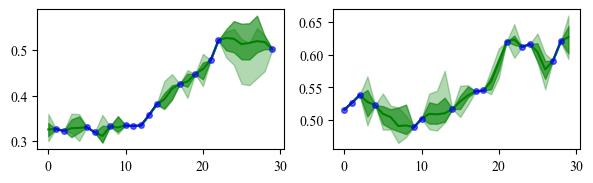

In [255]:
fig = plt.figure(figsize=(7,4))

plt.subplot(2,2,1)

X_missed1 = X_missed

plt.plot(res2_05[:,3], color = 'g') 

plt.fill_between( range(0,30), res1_005[:,3], res1_095[:,3], color='g', alpha=0.3, label = 'SAITS')  # alpha是透明程度

plt.fill_between( range(0,30), res2_005[:,3], res2_095[:,3], color='g', alpha=0.6, label = 'ours')  

plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4')

plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')



plt.subplot(2,2,2)

# X_missed2 = X_missed

plt.plot(res4_05[:,3], color = 'g') 

plt.fill_between( range(0,30), res3_005[:,3], res3_095[:,3], color='g', alpha=0.3)  

plt.fill_between( range(0,30), res4_005[:,3], res4_095[:,3], color='g', alpha=0.6)  


plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4')



plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')

# plt.legend()

plt.savefig('./sp500_分位数.pdf')